# Prepearing the environment

In [188]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import math
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
import warnings

# Data Preparation
from sklearn import preprocessing as pp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize, StandardScaler
from scipy.stats import pearsonr
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, \
    auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

# ML Algorithms to be used
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
import keras_tuner
from kerastuner import RandomSearch

## Configuring the GPU

In [189]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.list_physical_devices('GPU'))
else:
  print("GPU is not available")

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Pre-processing

## Loading the data

In [190]:
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "lithium-ion batteries.csv")
    data_eu_raw = pd.read_csv(data_path)
    return data_eu_raw
data_raw = read_Data()
data_raw.head()

Materials Id       Formula Spacegroup  Formation Energy (eV)   
0    mp-849394     Li2MnSiO4         Pc                 -2.699  \
1    mp-783909     Li2MnSiO4      P21/c                 -2.696   
2    mp-761311    Li4MnSi2O7         Cc                 -2.775   
3    mp-761598  Li4Mn2Si3O10       C2/c                 -2.783   
4    mp-767709  Li2Mn3Si3O10       C2/c                 -2.747   

   E Above Hull (eV)  Band Gap (eV)  Nsites  Density (gm/cc)   Volume   
0              0.006          3.462      16            2.993  178.513  \
1              0.008          2.879      32            2.926  365.272   
2              0.012          3.653      28            2.761  301.775   
3              0.013          3.015      38            2.908  436.183   
4              0.016          2.578      36            3.334  421.286   

   Has Bandstructure Crystal System  
0               True     monoclinic  
1               True     monoclinic  
2               True     monoclinic  
3               True     monoclinic  
4               True     monoclinic

# Data Exploration and Preparation

In [191]:
data_raw.describe()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)      Nsites   
count             339.000000         339.000000     339.000000  339.000000  \
mean               -2.616950           0.058215       2.079740   38.837758   
std                 0.183809           0.030363       1.087968   23.133142   
min                -2.985000           0.000000       0.000000   10.000000   
25%                -2.757500           0.035500       1.265500   26.000000   
50%                -2.605000           0.062000       2.499000   31.000000   
75%                -2.525500           0.081500       2.968000   52.000000   
max                -2.012000           0.190000       3.823000  132.000000   

       Density (gm/cc)       Volume  
count       339.000000   339.000000  
mean          2.984003   467.765619  
std           0.353968   292.674559  
min           2.200000   122.581000  
25%           2.760500   286.381500  
50%           2.947000   358.537000  
75%           3.106000   601.696500  
max           4.201000  1518.850000

In [192]:
data_raw.columns

Index(['Materials Id', 'Formula', 'Spacegroup', 'Formation Energy (eV)',
       'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)',
       'Volume', 'Has Bandstructure', 'Crystal System'],
      dtype='object')

In [193]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Materials Id           339 non-null    object 
 1   Formula                339 non-null    object 
 2   Spacegroup             339 non-null    object 
 3   Formation Energy (eV)  339 non-null    float64
 4   E Above Hull (eV)      339 non-null    float64
 5   Band Gap (eV)          339 non-null    float64
 6   Nsites                 339 non-null    int64  
 7   Density (gm/cc)        339 non-null    float64
 8   Volume                 339 non-null    float64
 9   Has Bandstructure      339 non-null    bool   
 10  Crystal System         339 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(4)
memory usage: 26.9+ KB


In [194]:
data_raw.shape

(339, 11)

### Data Visualization

        Since the first three columns ('Materials Id', 'Formula', and 'Spacegroup') contain string or categorical data, it's not appropriate to plot them as histograms. Instead, you can use bar plots to visualize the frequency of each category. For the other columns, you can continue to use histograms.

        For better visualization and understanding, you can add y-labels as "Frequency of [feature_name]" to each histogram. Here's a modified version of the plot_histograms function to handle categorical columns and add y-labels:

#### Histograms

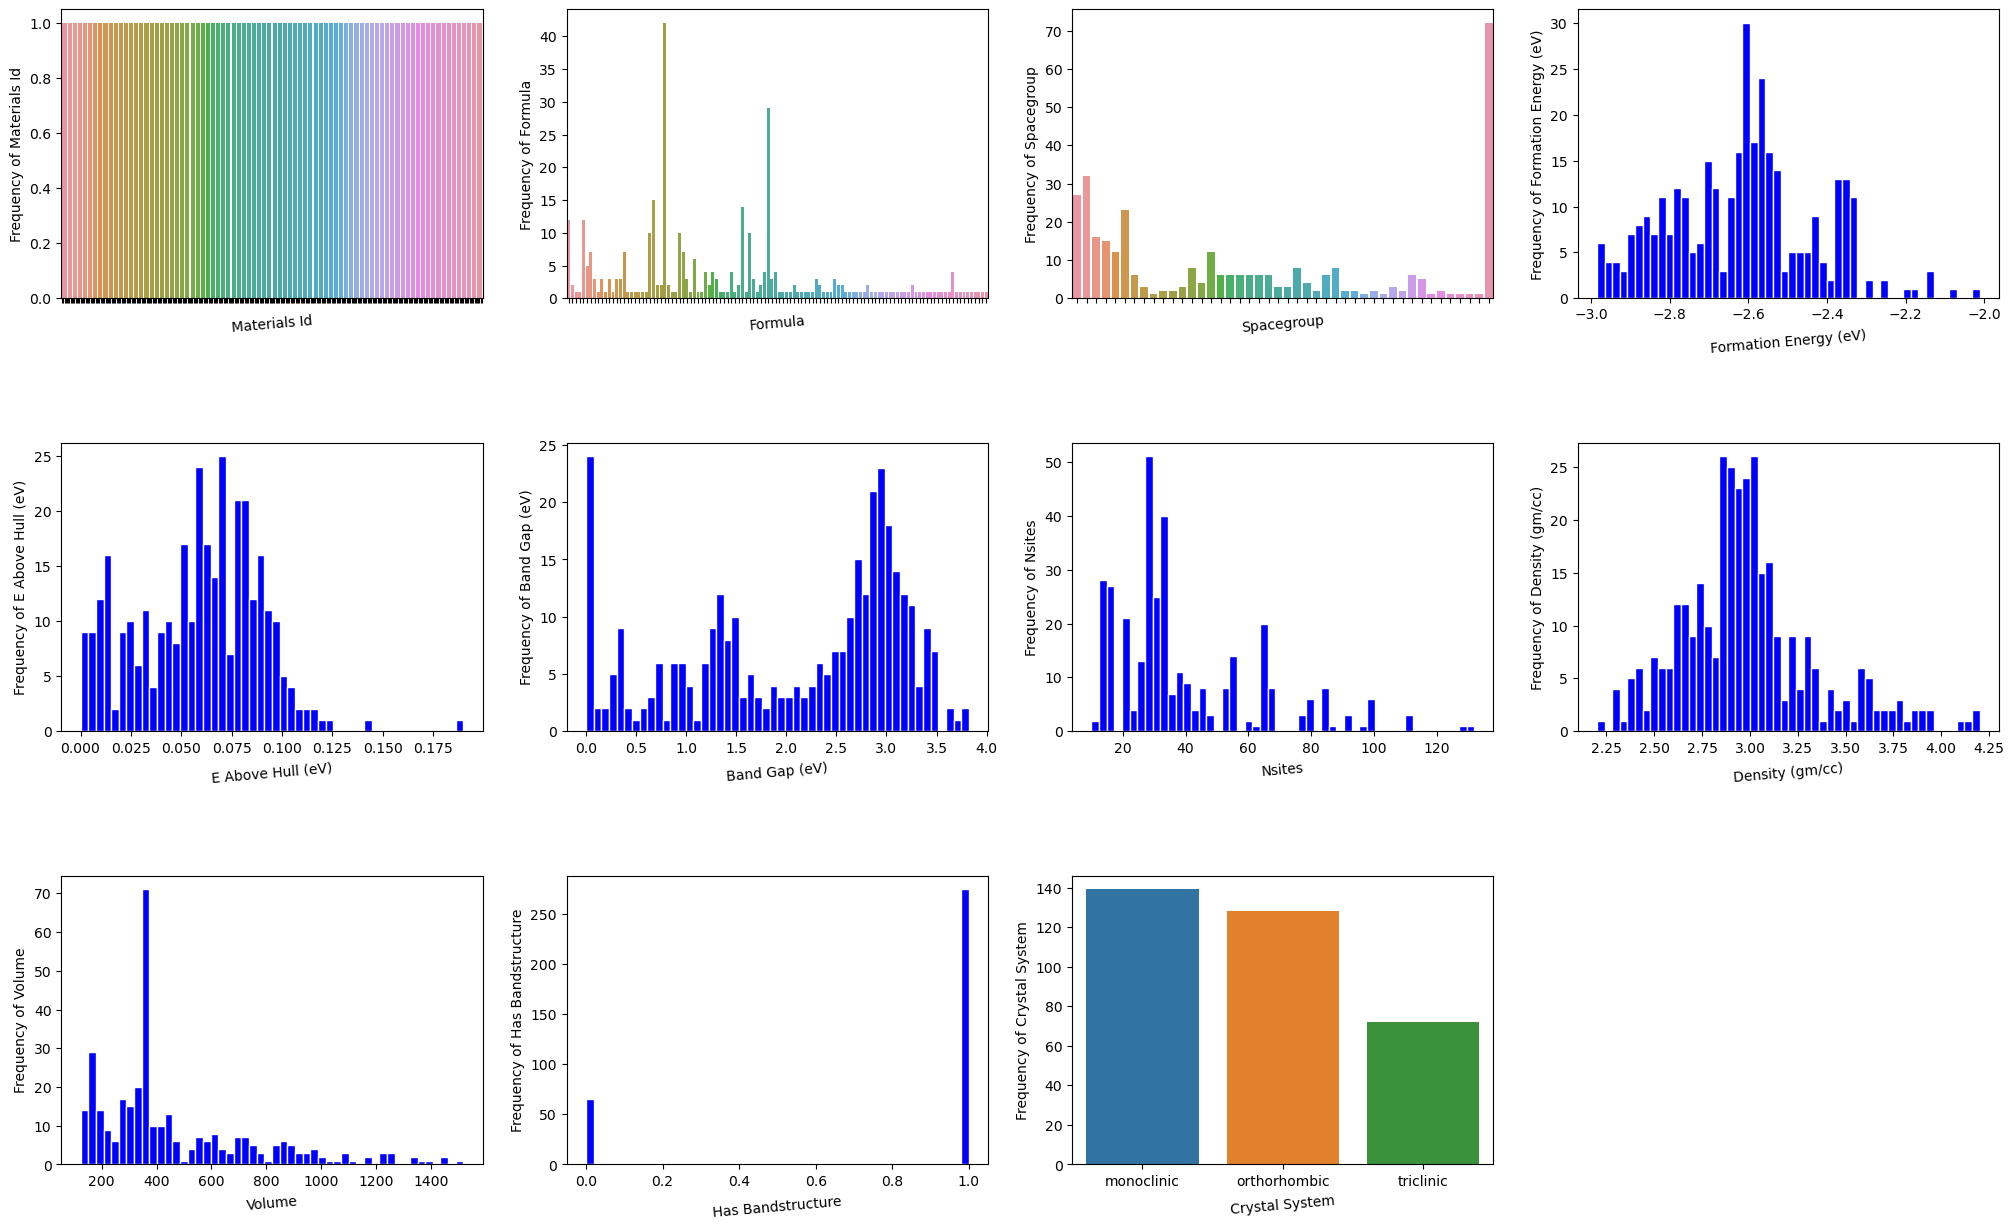

In [195]:
def plot_histograms_1(dataframe, fig_size=(20, 14)):
    """
    Plot histograms for all columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    col_names = dataframe.columns
    num_subplots = len(col_names)
    num_cols = min(num_subplots, 4)
    num_rows = math.ceil(num_subplots / num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)

    for i in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    for i, col_name in enumerate(col_names):
        if col_name is None:
            continue
        try:
            row = i // num_cols
            col = i % num_cols
            data = dataframe[col_name]

            if data.dtype == bool:
                data = data.astype(int)

            if data.dtype == object or data.dtype.name == 'category':
                sns.countplot(x=data, ax=axs[row, col])
                if i < 3:  # Remove x-axis labels for the first two bar charts
                    axs[row, col].set_xticklabels([])
            else:
                axs[row, col].hist(data, bins=50, facecolor='b', edgecolor='white')

            xlabel = col_name.split('_')[0]
            axs[row, col].set_xlabel(xlabel, rotation=5)
            axs[row, col].set_ylabel(f"Frequency of {col_name}")

        except ValueError:
            print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")

    fig.subplots_adjust(hspace=0.5)
    plt.show()

def plot_top_categories_1(data, col_name, top_n=50, figsize=(10, 5)):
    """
    Plot a bar chart for the top N categories of a Pandas DataFrame column.

    Parameters:
    data (pandas.Series): The input data column.
    col_name (str): The name of the column.
    top_n (int): The number of top categories to display (default: 50).
    figsize (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    # Get the top N most frequent categories
    top_categories = data.value_counts().nlargest(top_n)

    # Aggregate the remaining categories into 'Others'
    others_count = data.nunique() - top_n
    if others_count > 0:
        top_categories['Others'] = data.value_counts().nsmallest(others_count).sum()

    plt.figure(figsize=figsize)
    top_categories.plot(kind='bar', facecolor='b', edgecolor='white')
    plt.xlabel(col_name.split('_')[0], rotation=5)
    plt.ylabel(f"Frequency of {col_name}")
    plt.show()
    
def plot_top_categories_2(data, col_name, num_histograms=6, categories_per_histogram=10, figsize=(10, 5)):
    """
    Plot multiple bar charts for the top N categories of a Pandas DataFrame column.

    Parameters:
    data (pandas.Series): The input data column.
    col_name (str): The name of the column.
    num_histograms (int): The number of histograms to display (default: 6).
    categories_per_histogram (int): The number of categories to display in each histogram (default: 10).
    figsize (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    value_counts = data.value_counts()

    for i in range(num_histograms):
        start = i * categories_per_histogram
        end = (i + 1) * categories_per_histogram
        top_categories = value_counts.iloc[start:end]

        plt.figure(figsize=figsize)
        top_categories.plot(kind='bar', facecolor='b', edgecolor='white')
        plt.xlabel(col_name.split('_')[0], rotation=5)
        plt.ylabel(f"Frequency of {col_name}")
        plt.title(f"Histogram {i + 1}: {col_name} categories {start + 1} to {end}")
        plt.show()

plot_histograms_1(data_raw, fig_size=(25, 15)) 

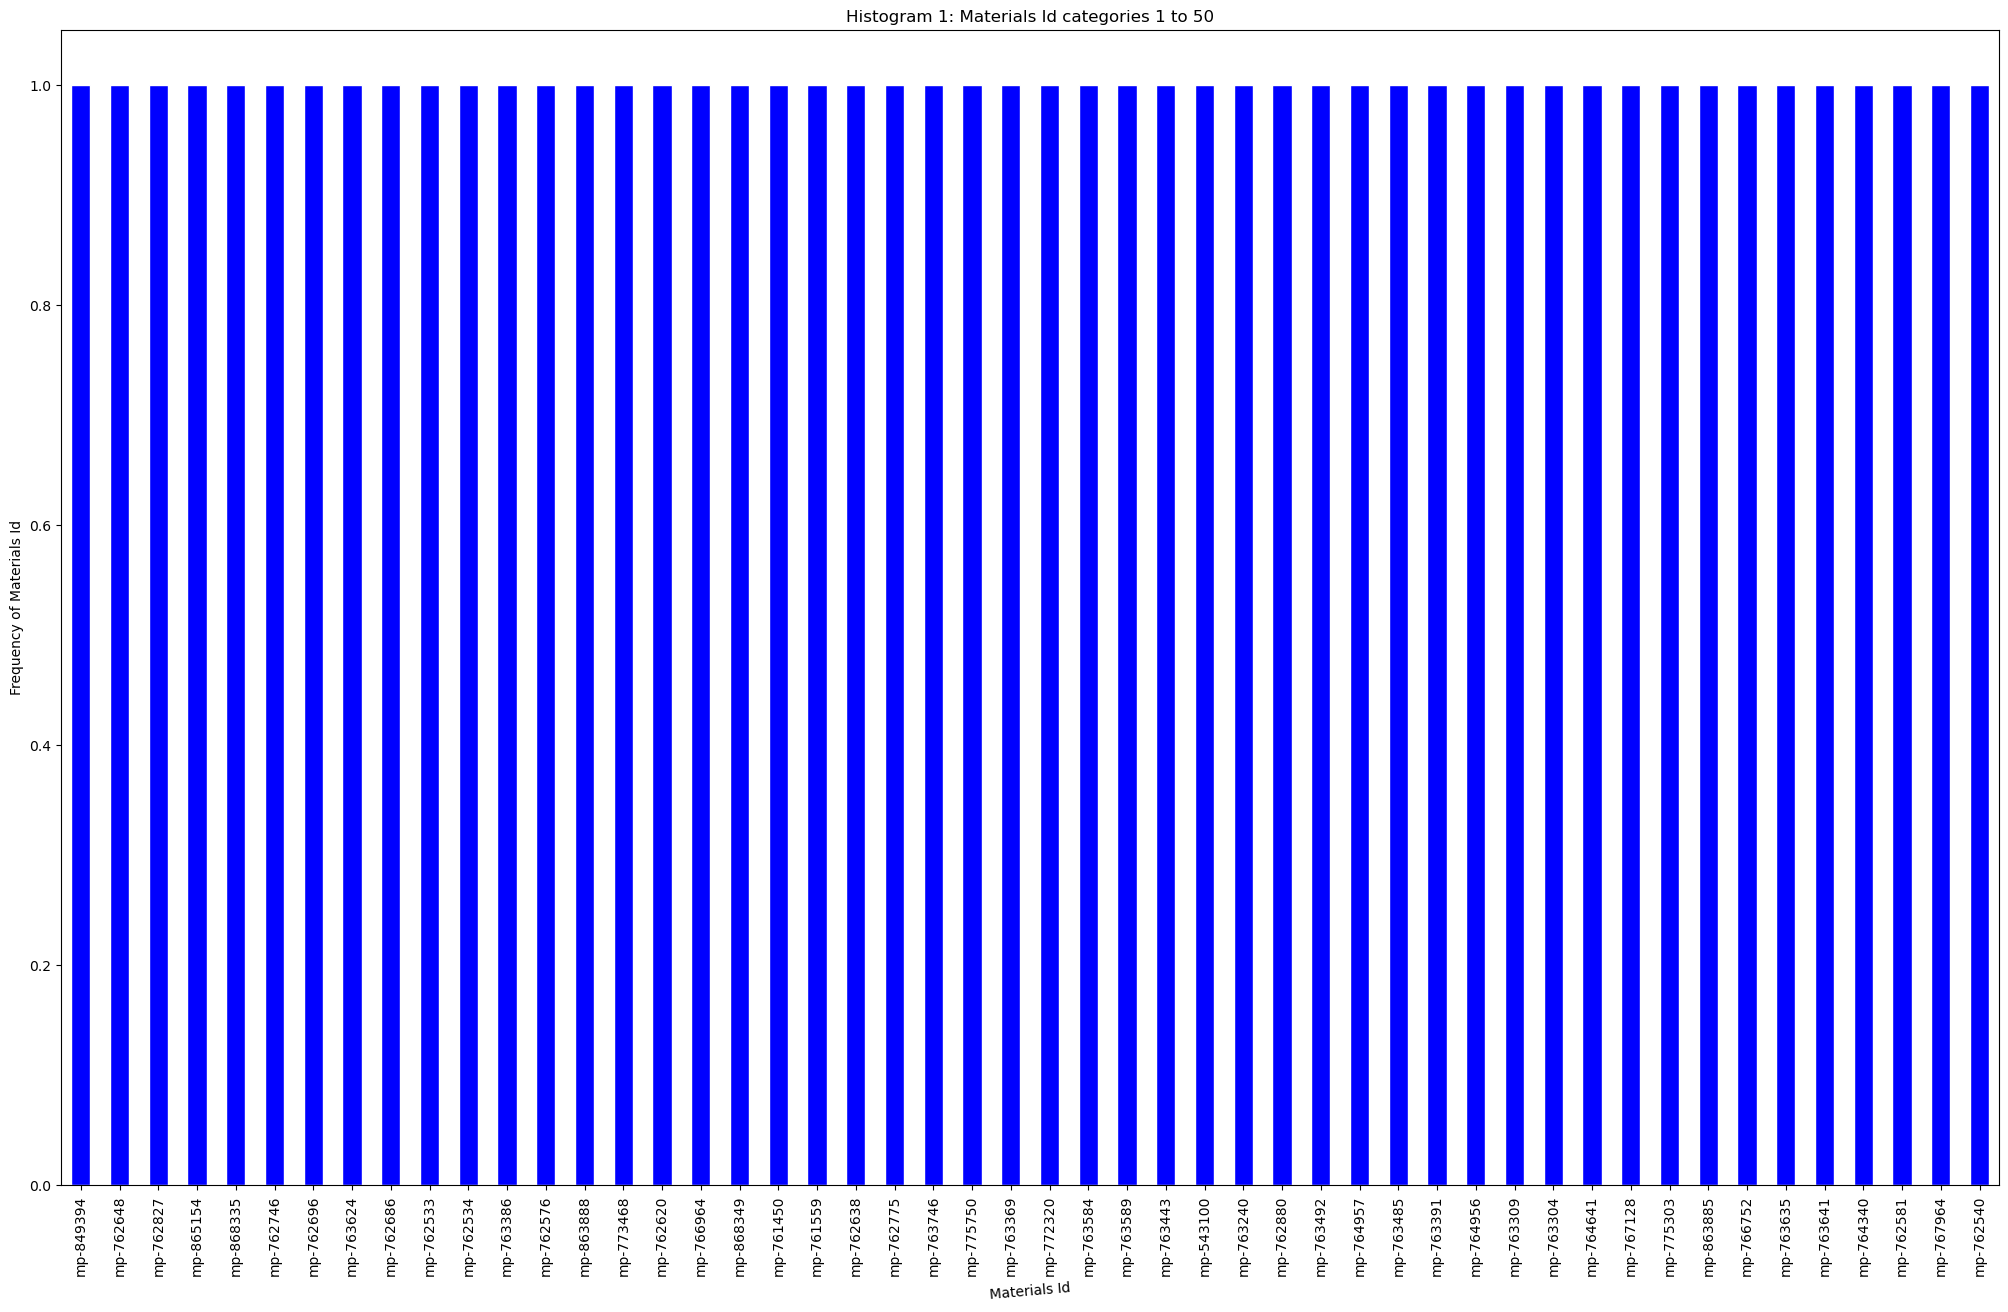

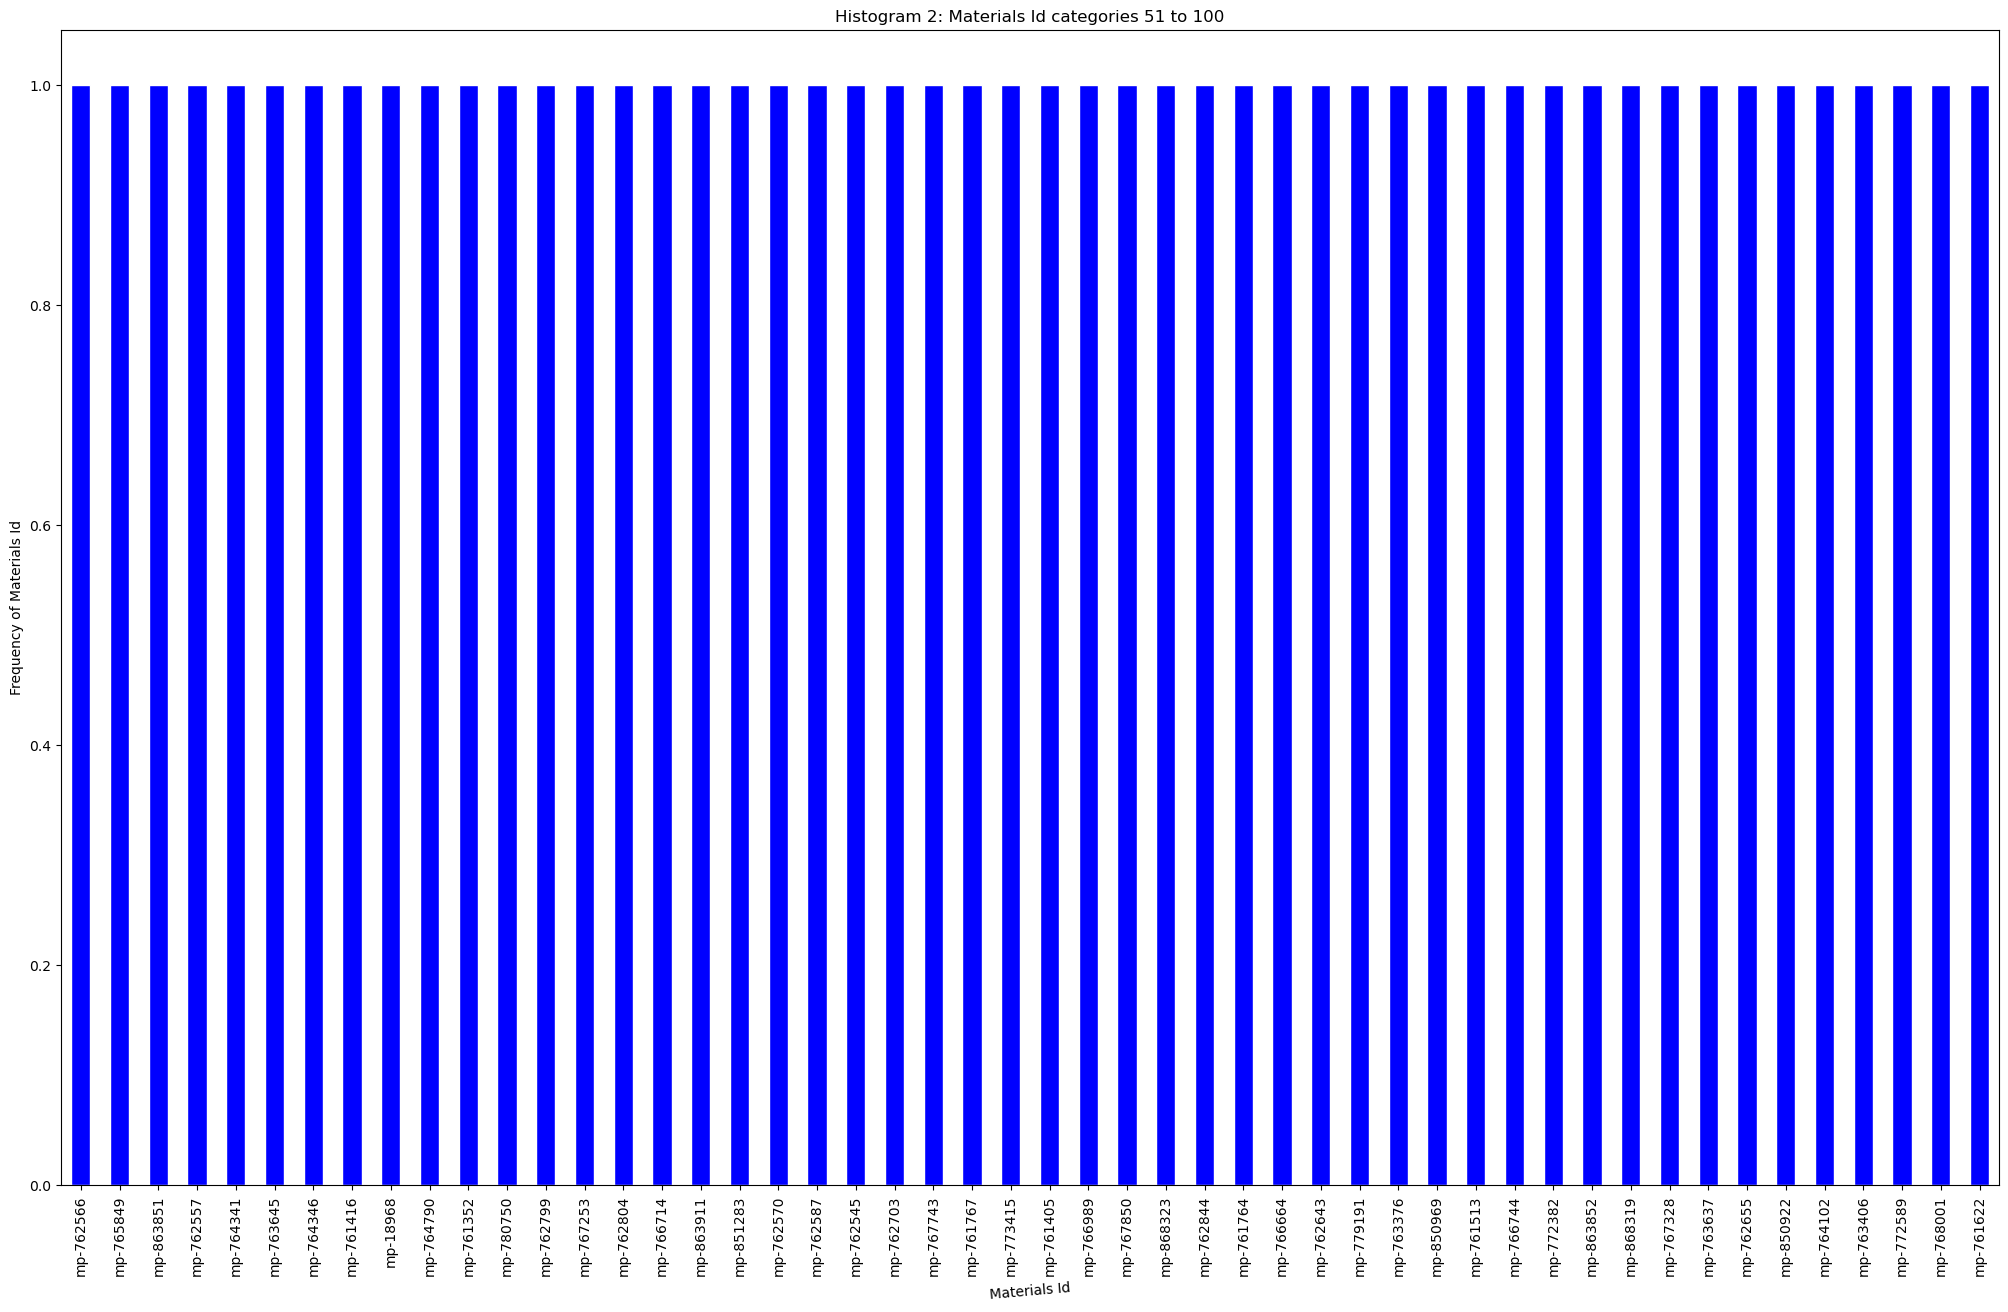

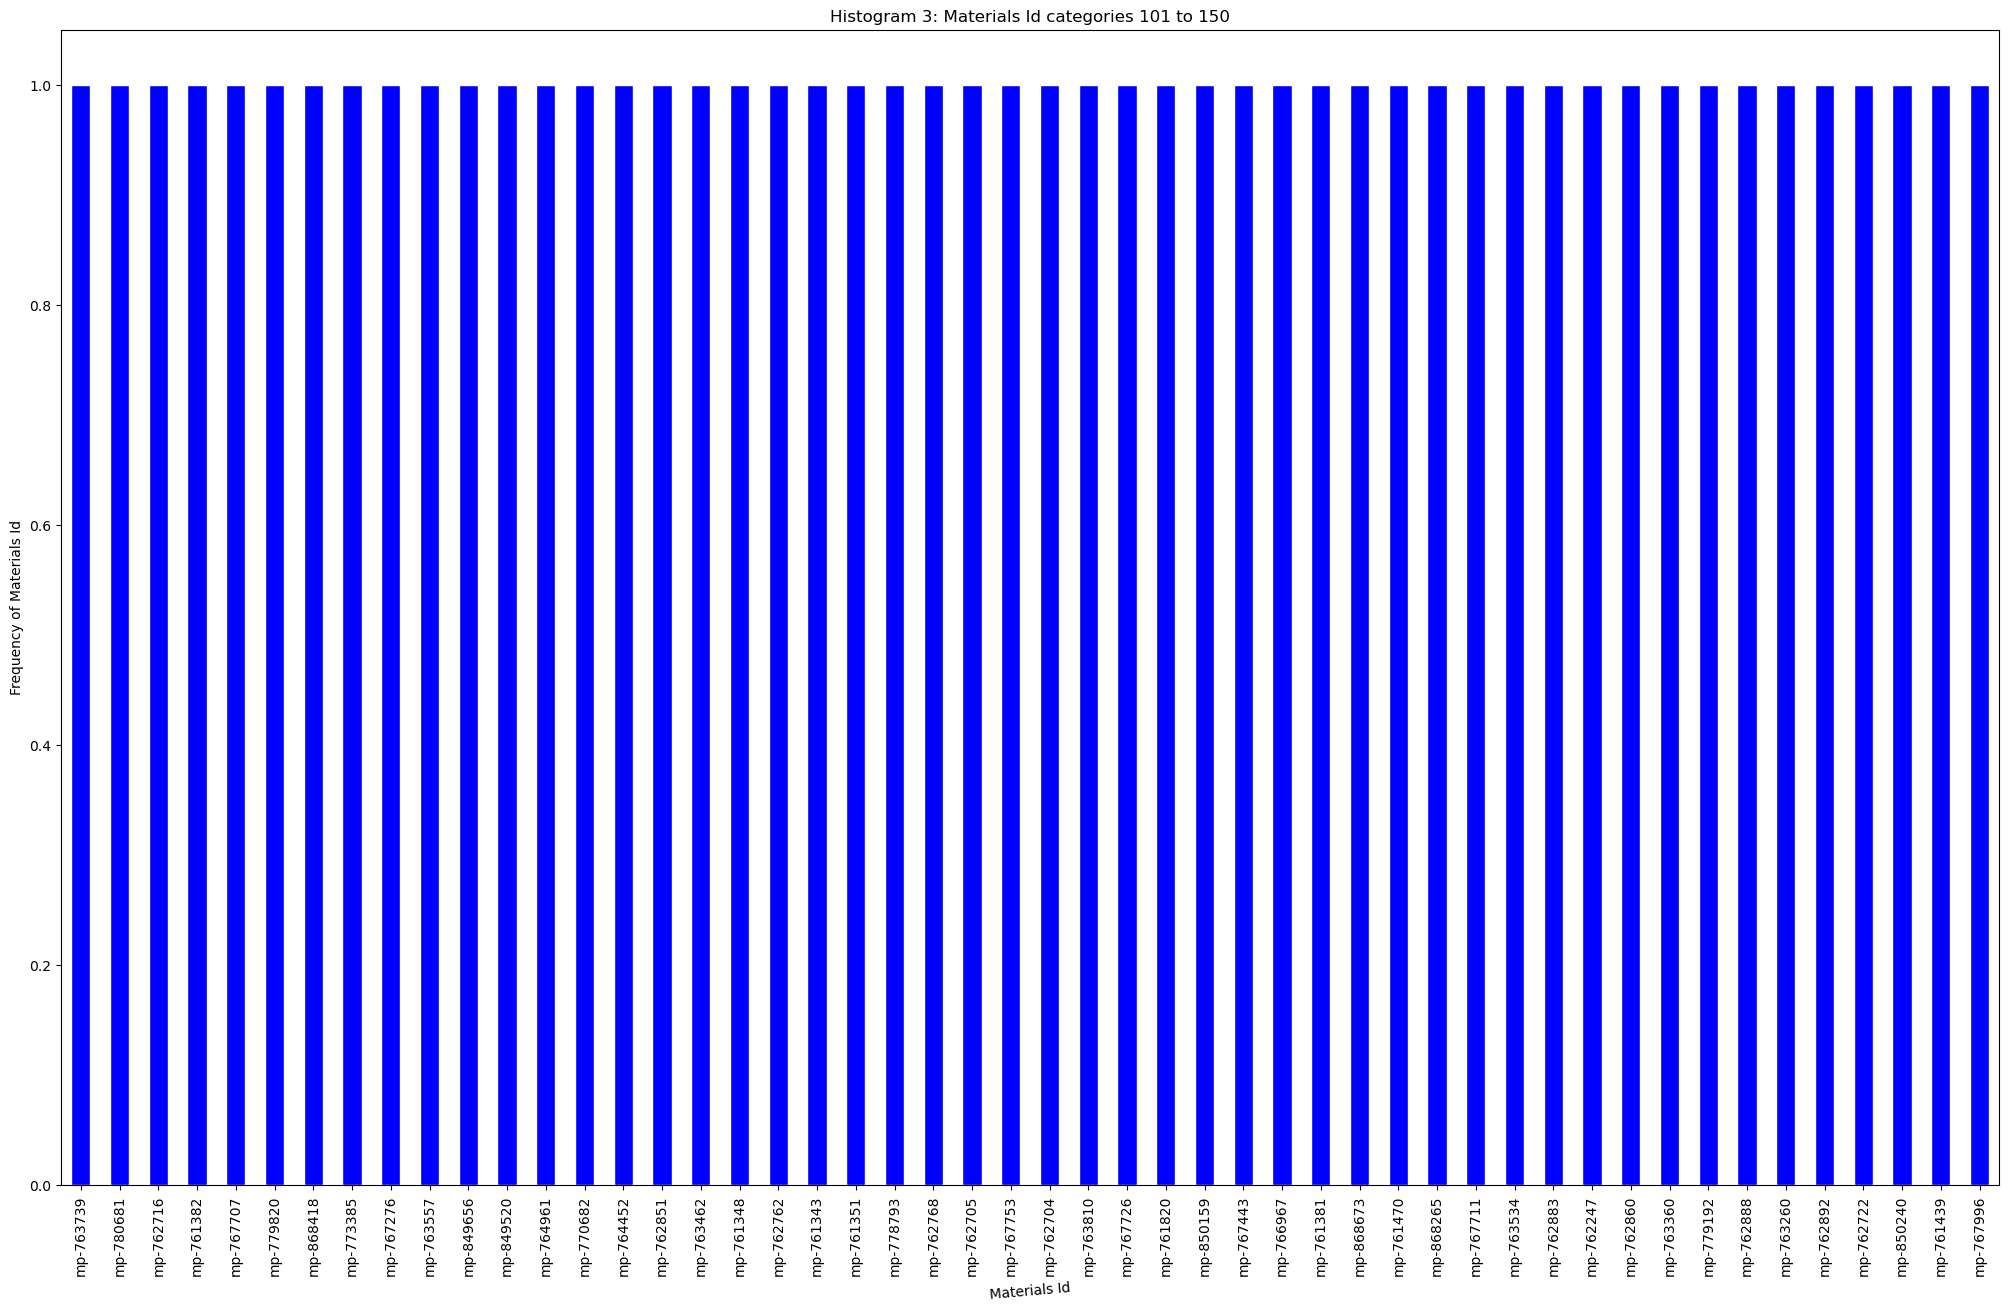

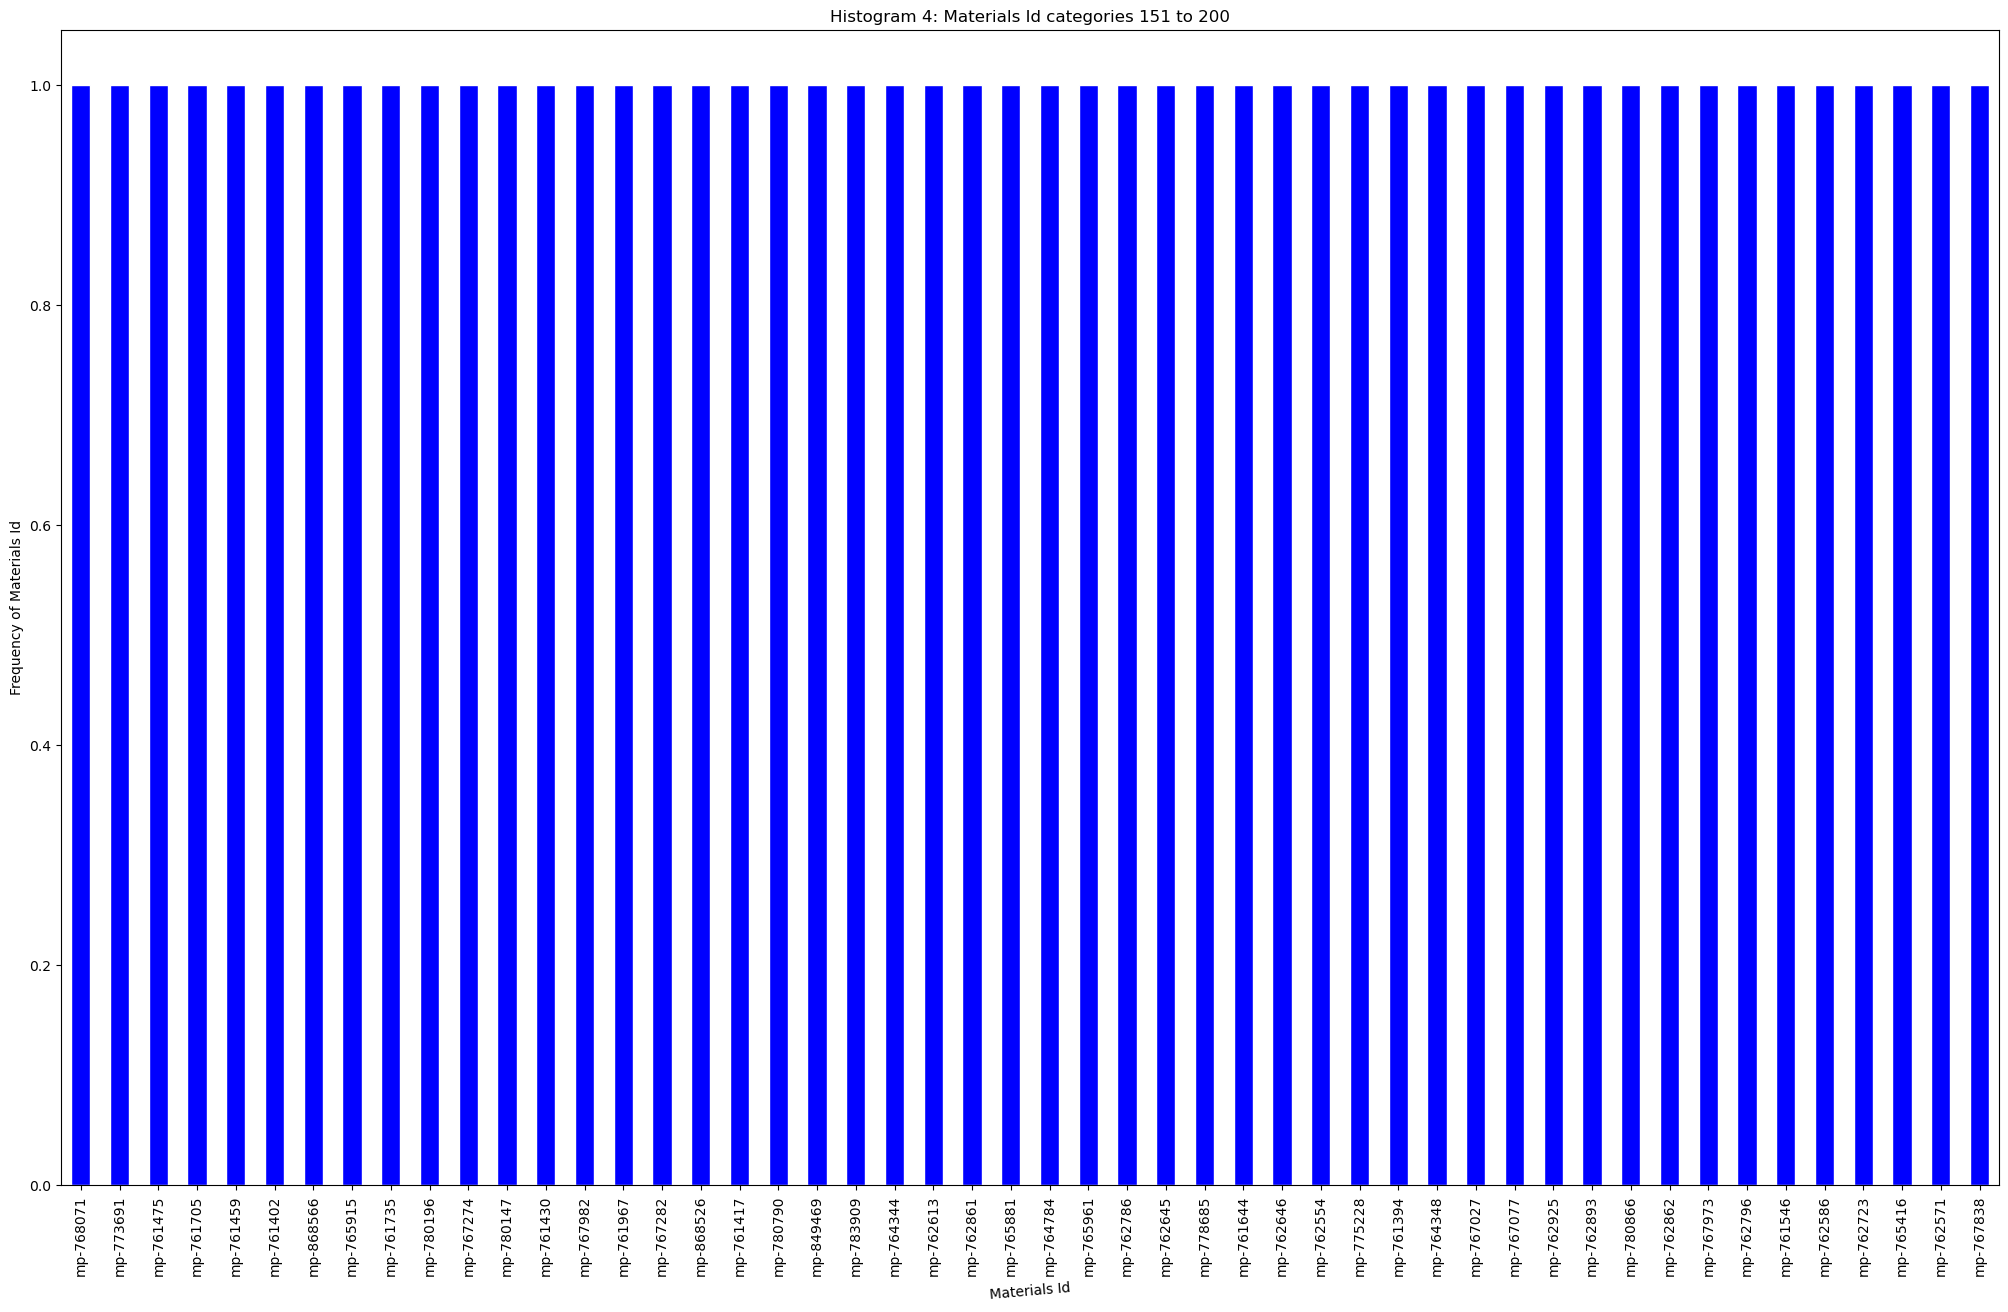

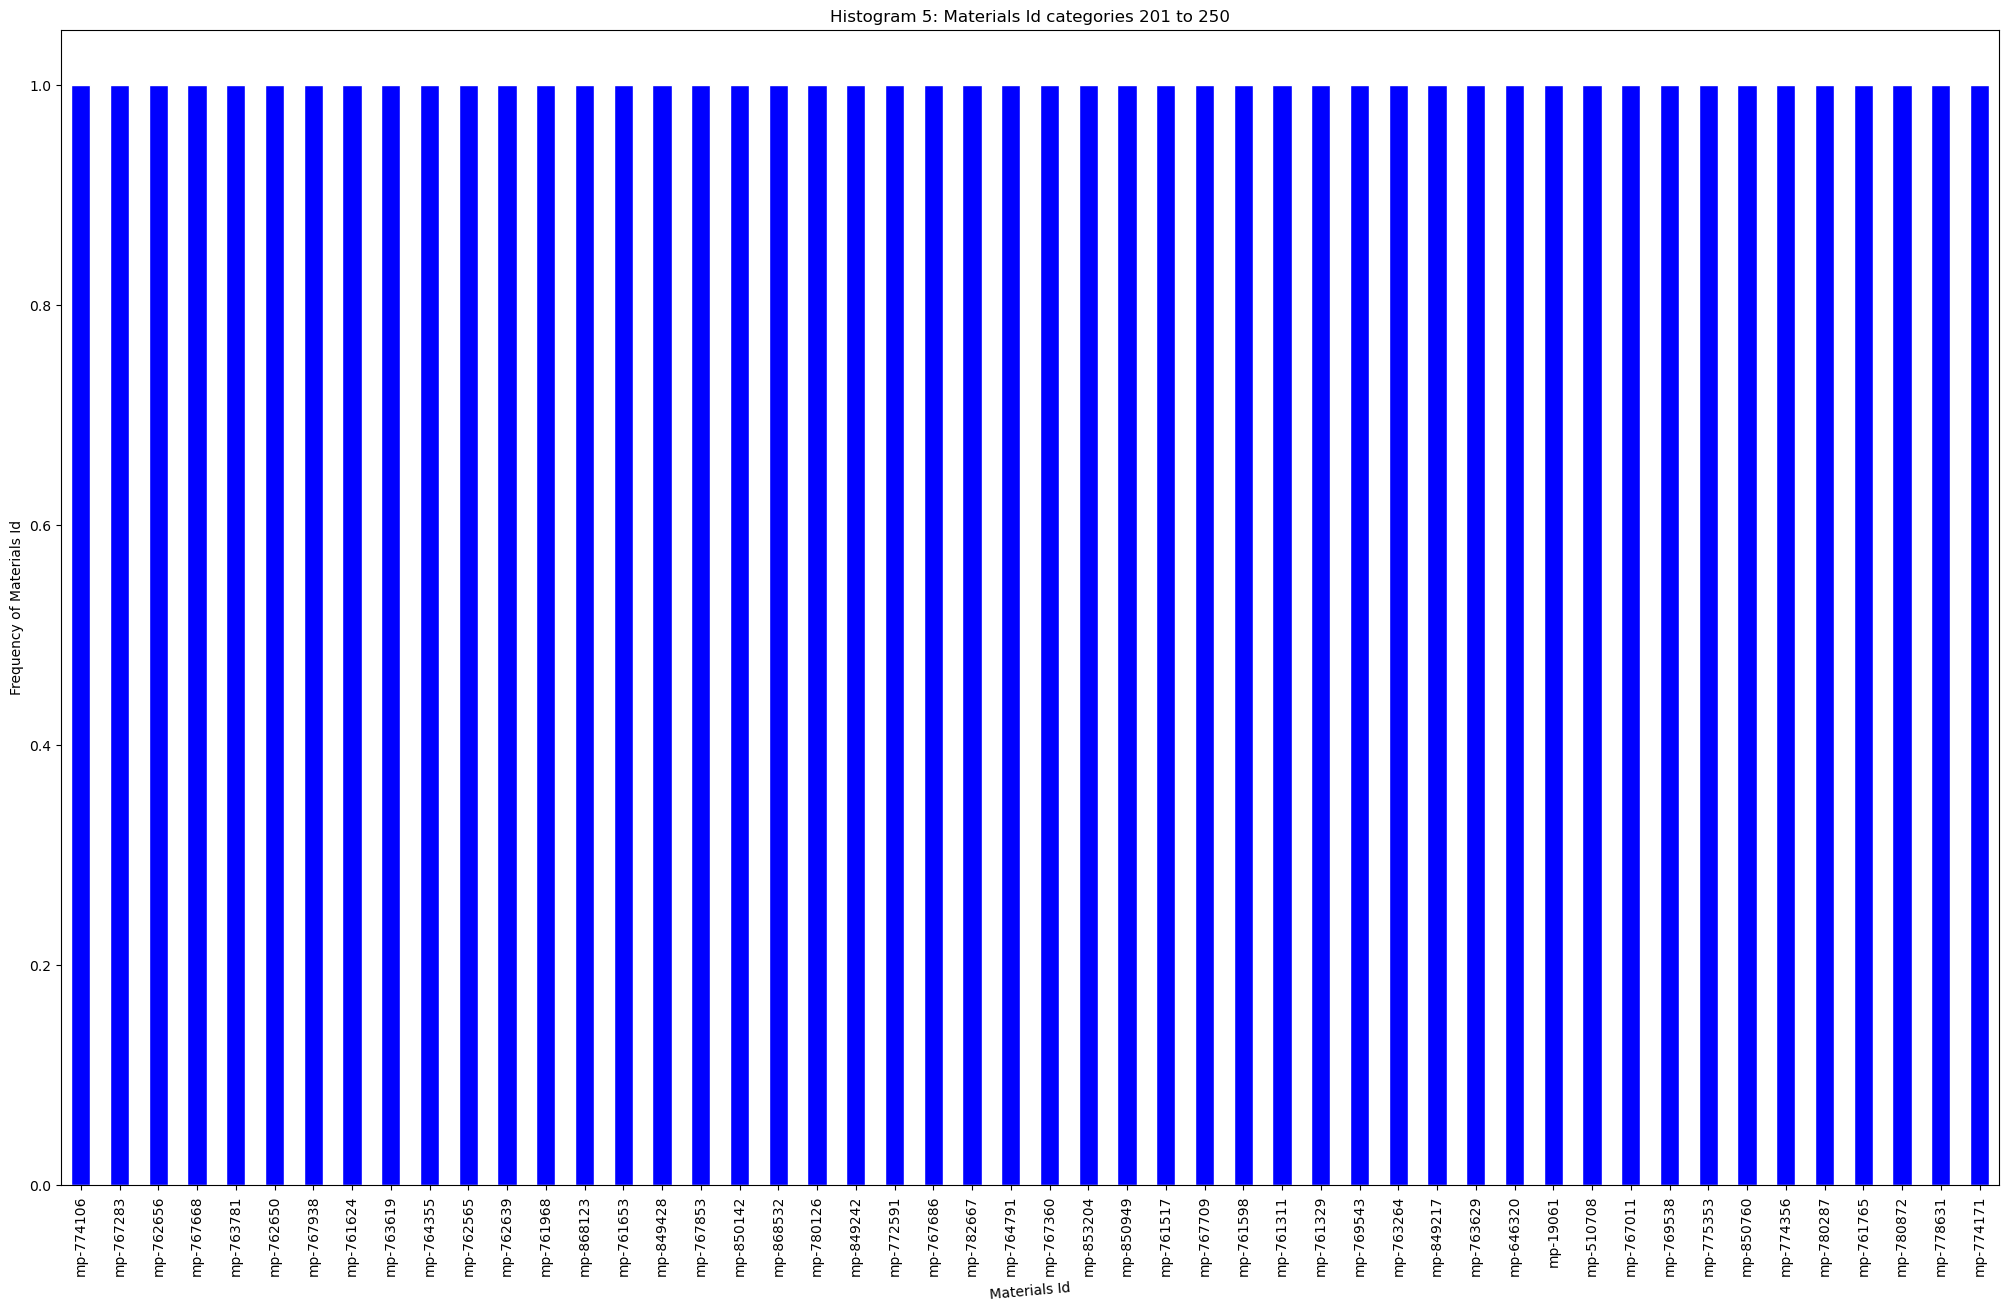

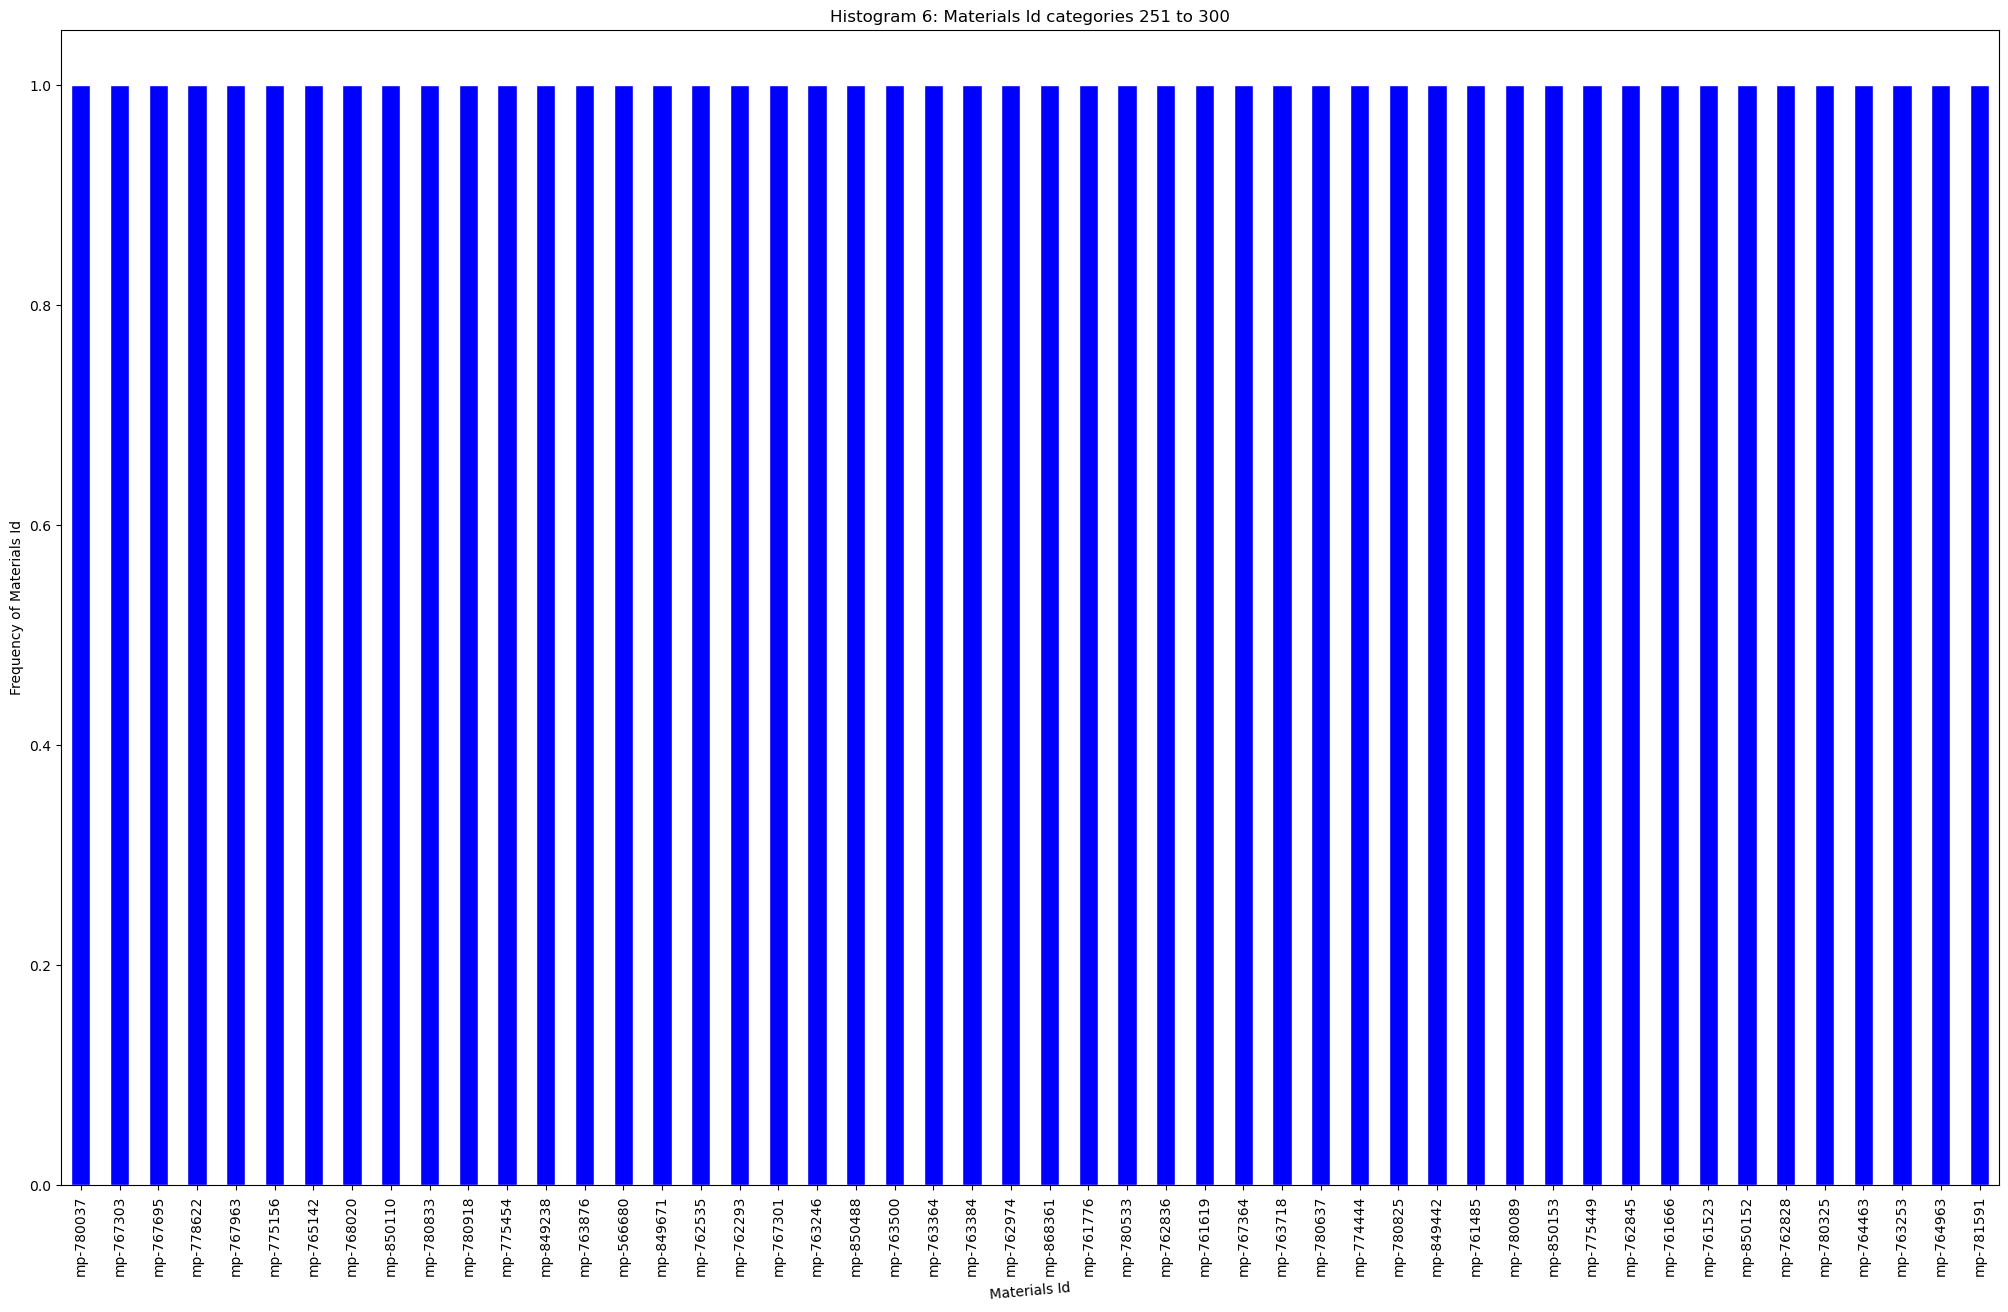

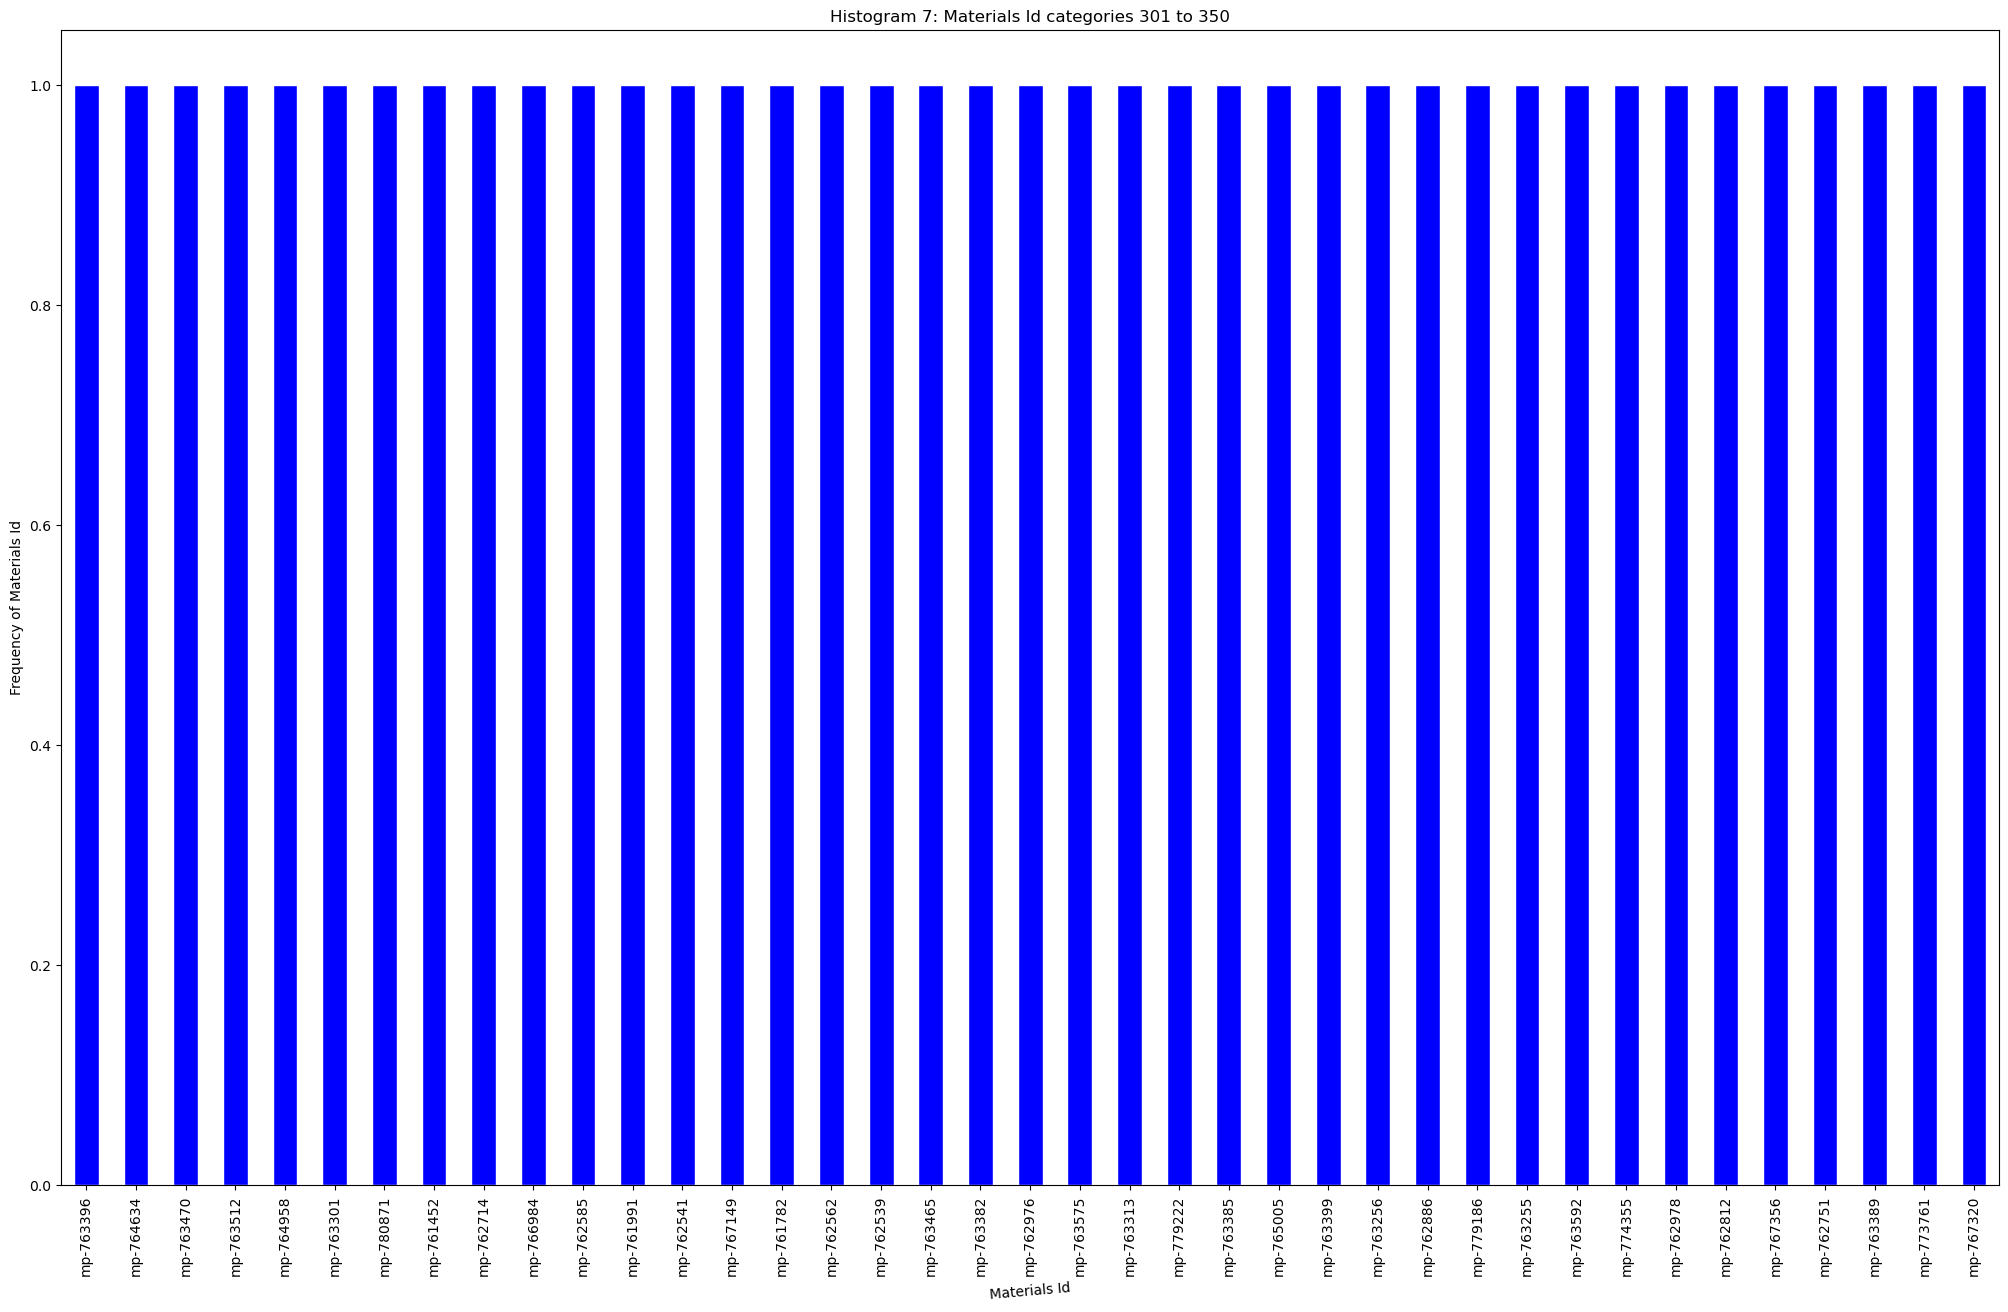

In [196]:
plot_top_categories_2(data_raw['Materials Id'], 'Materials Id', num_histograms=7, categories_per_histogram=50, figsize=(25, 15))

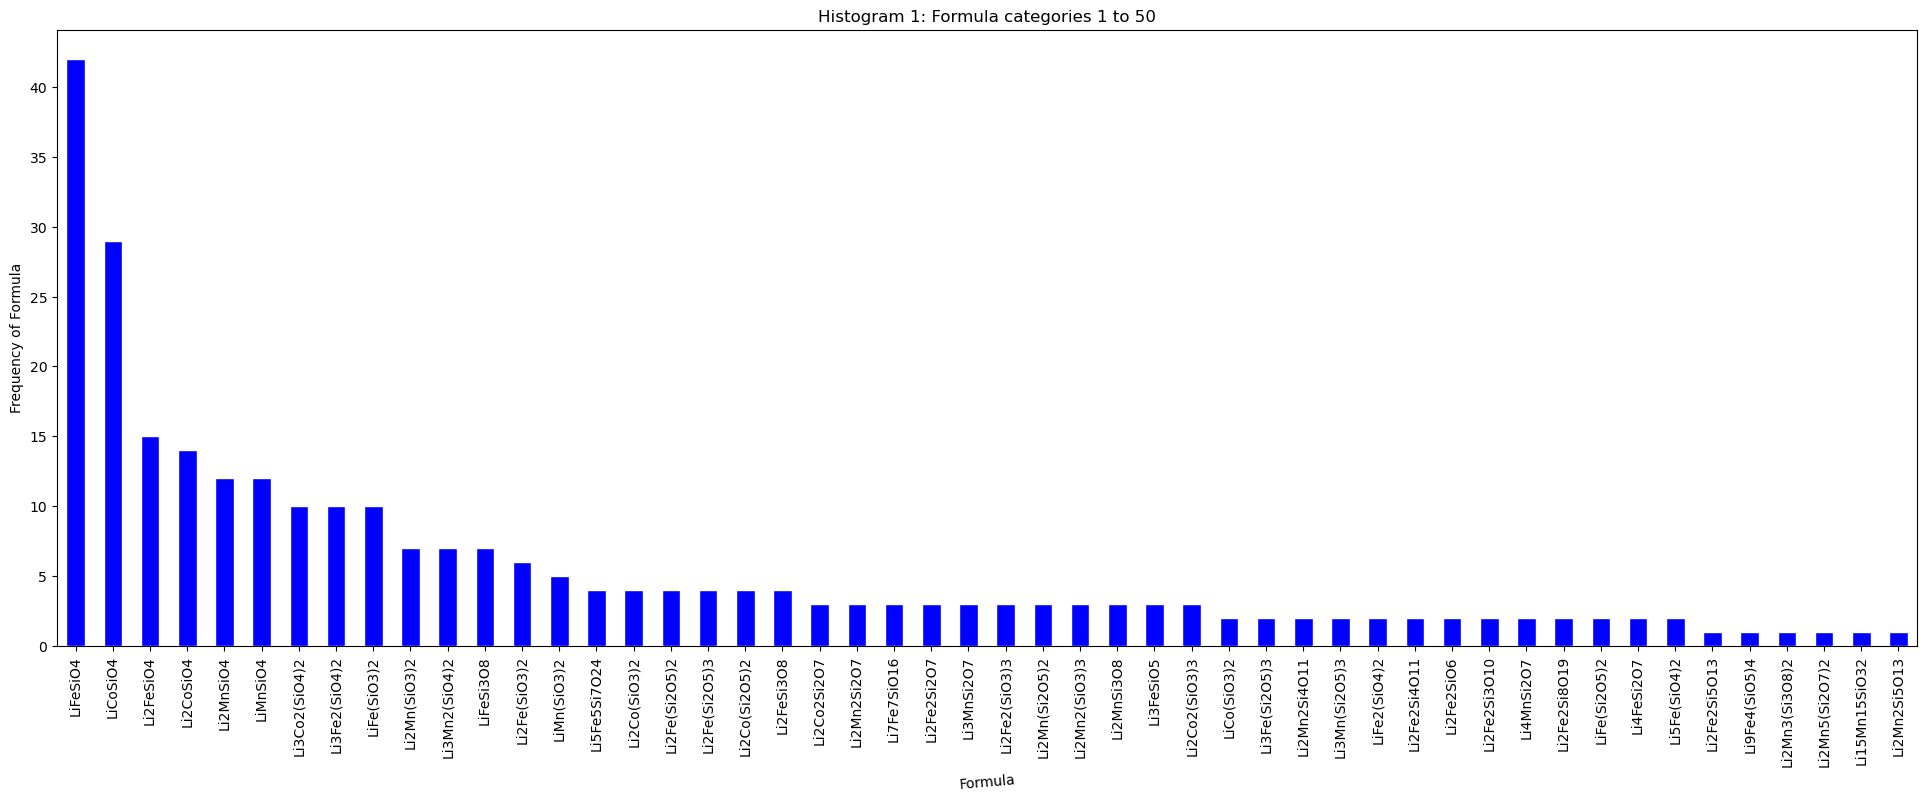

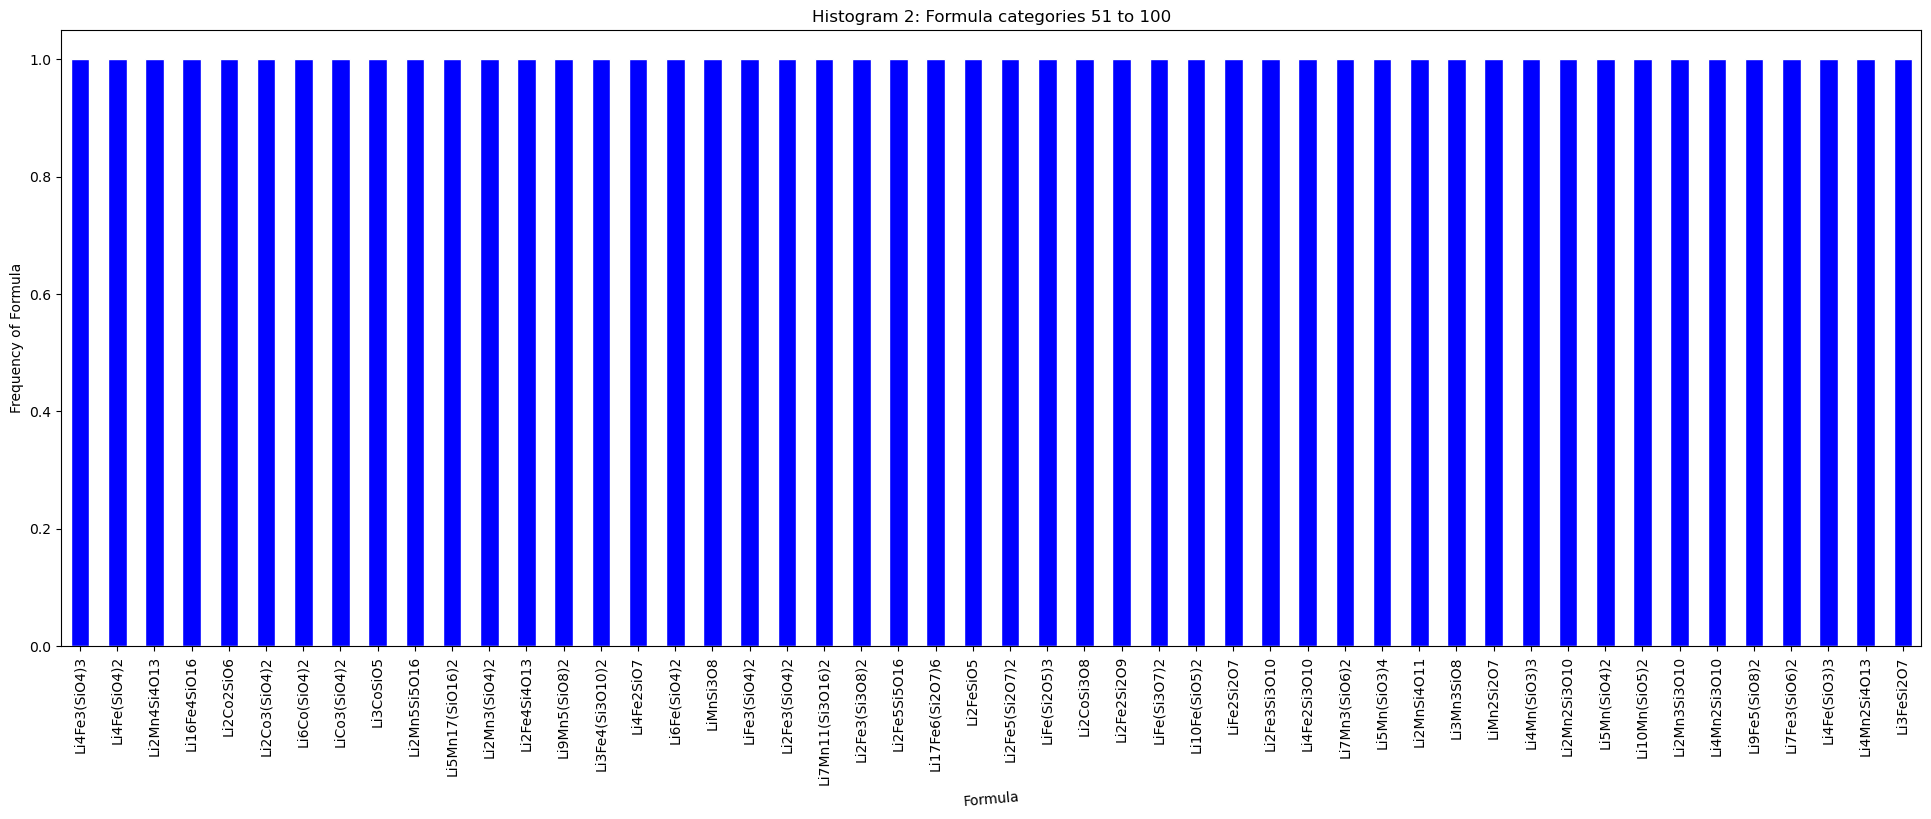

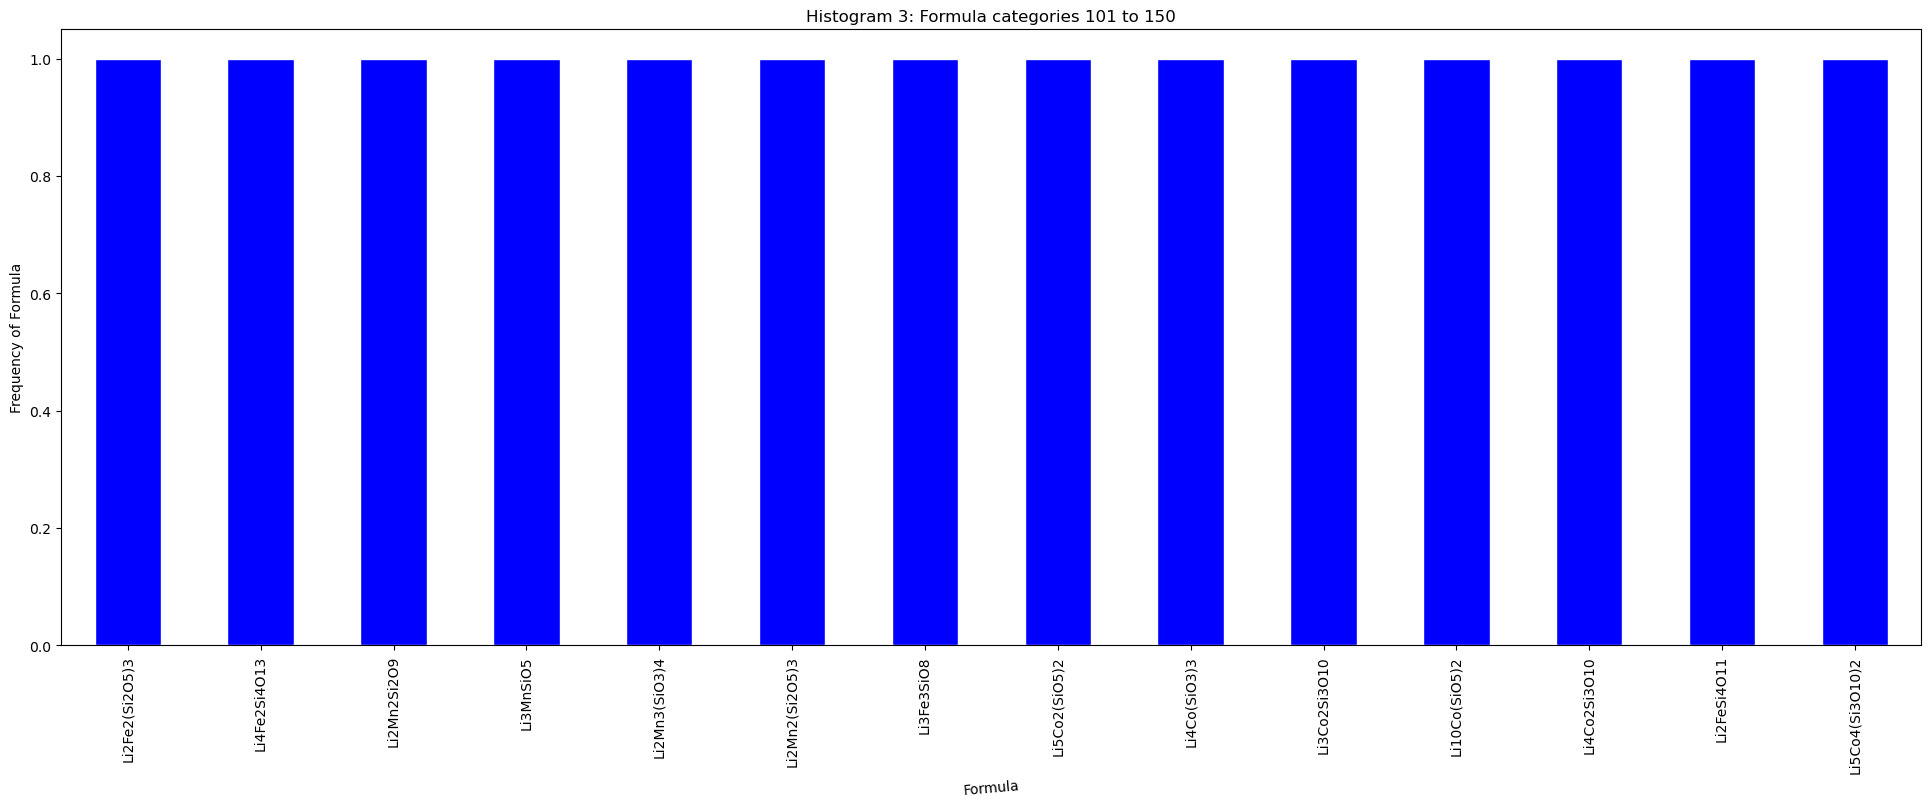

In [197]:
plot_top_categories_2(data_raw['Formula'], 'Formula', num_histograms=3, categories_per_histogram=50, figsize=(24, 8))

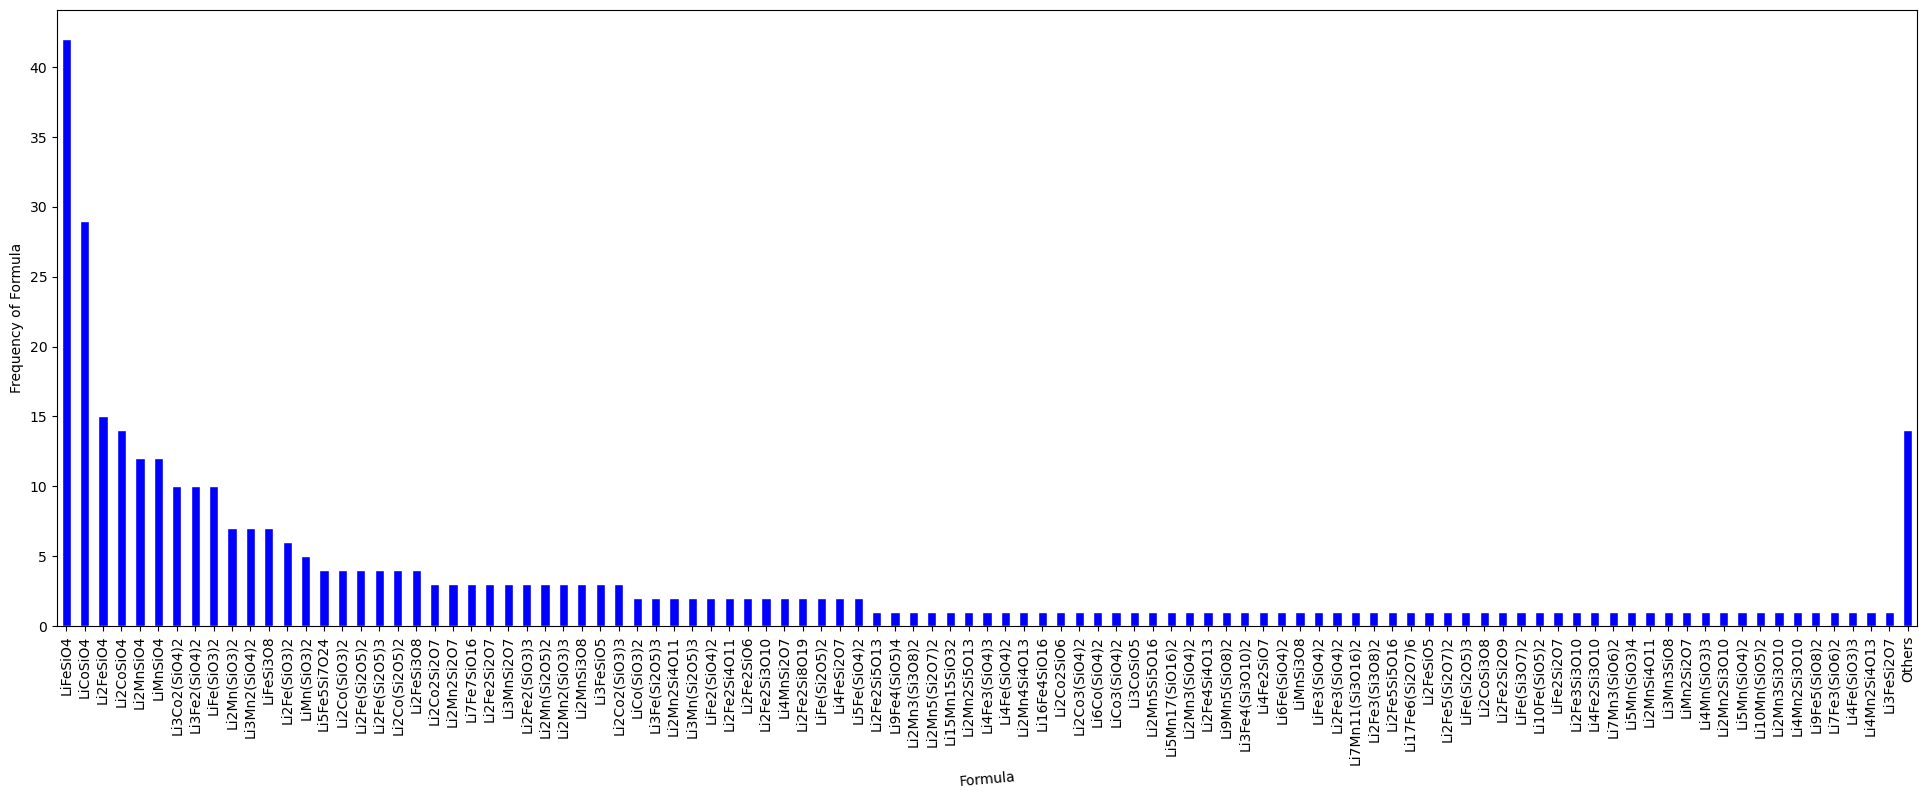

In [198]:
plot_top_categories_1(data_raw['Formula'], 'Formula', top_n=100, figsize=(24, 8))

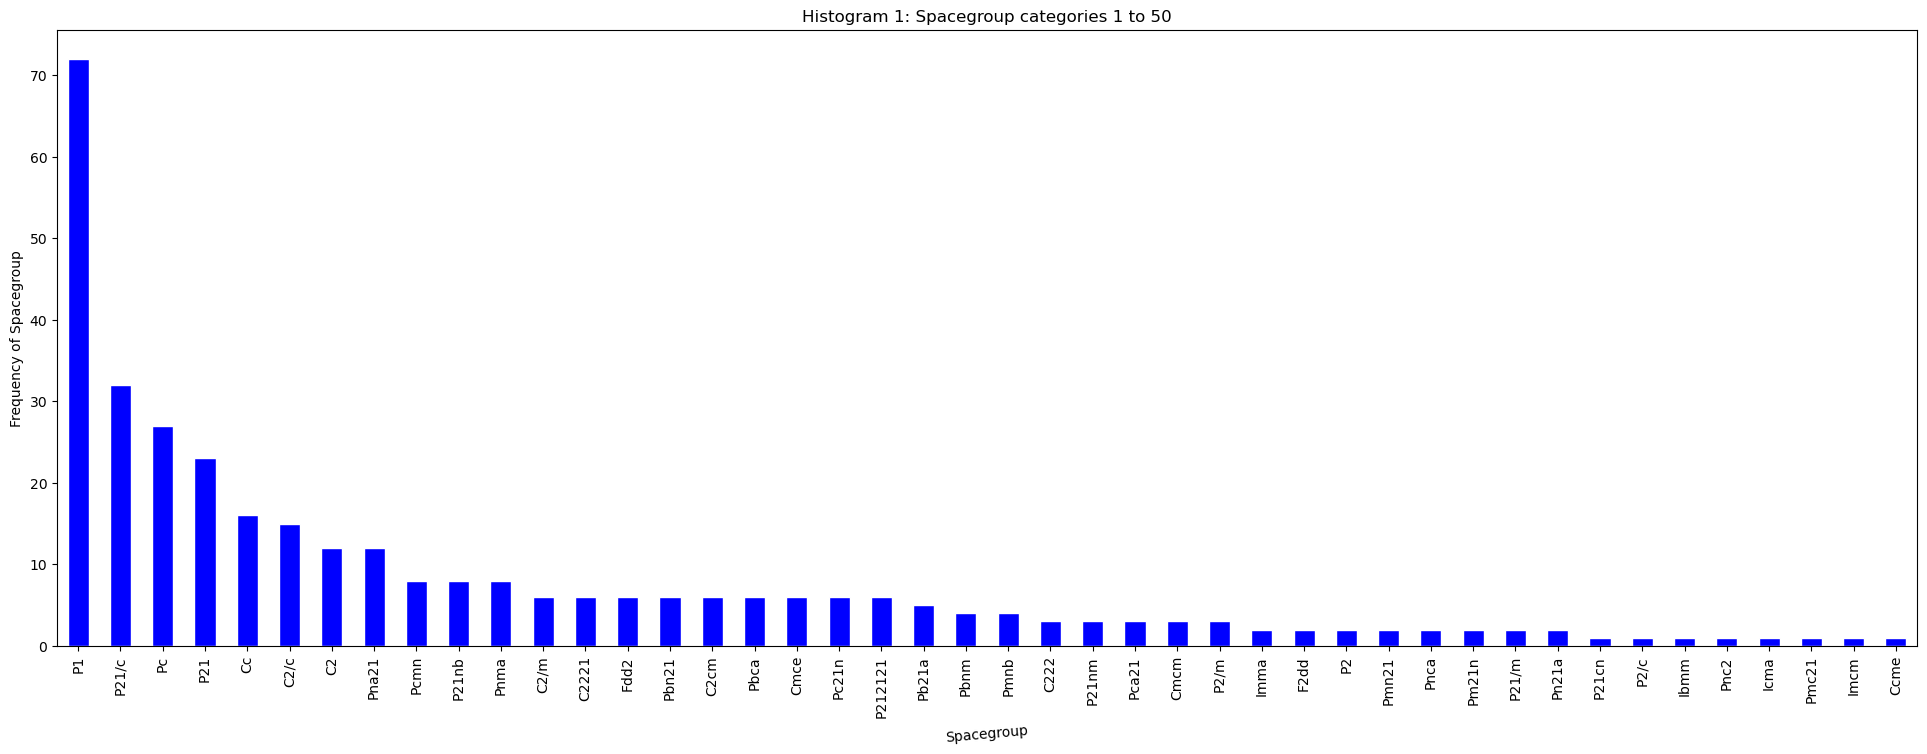

In [199]:
plot_top_categories_2(data_raw['Spacegroup'], 'Spacegroup', num_histograms=1, categories_per_histogram=50, figsize=(24, 8))

#### Pairplot 

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


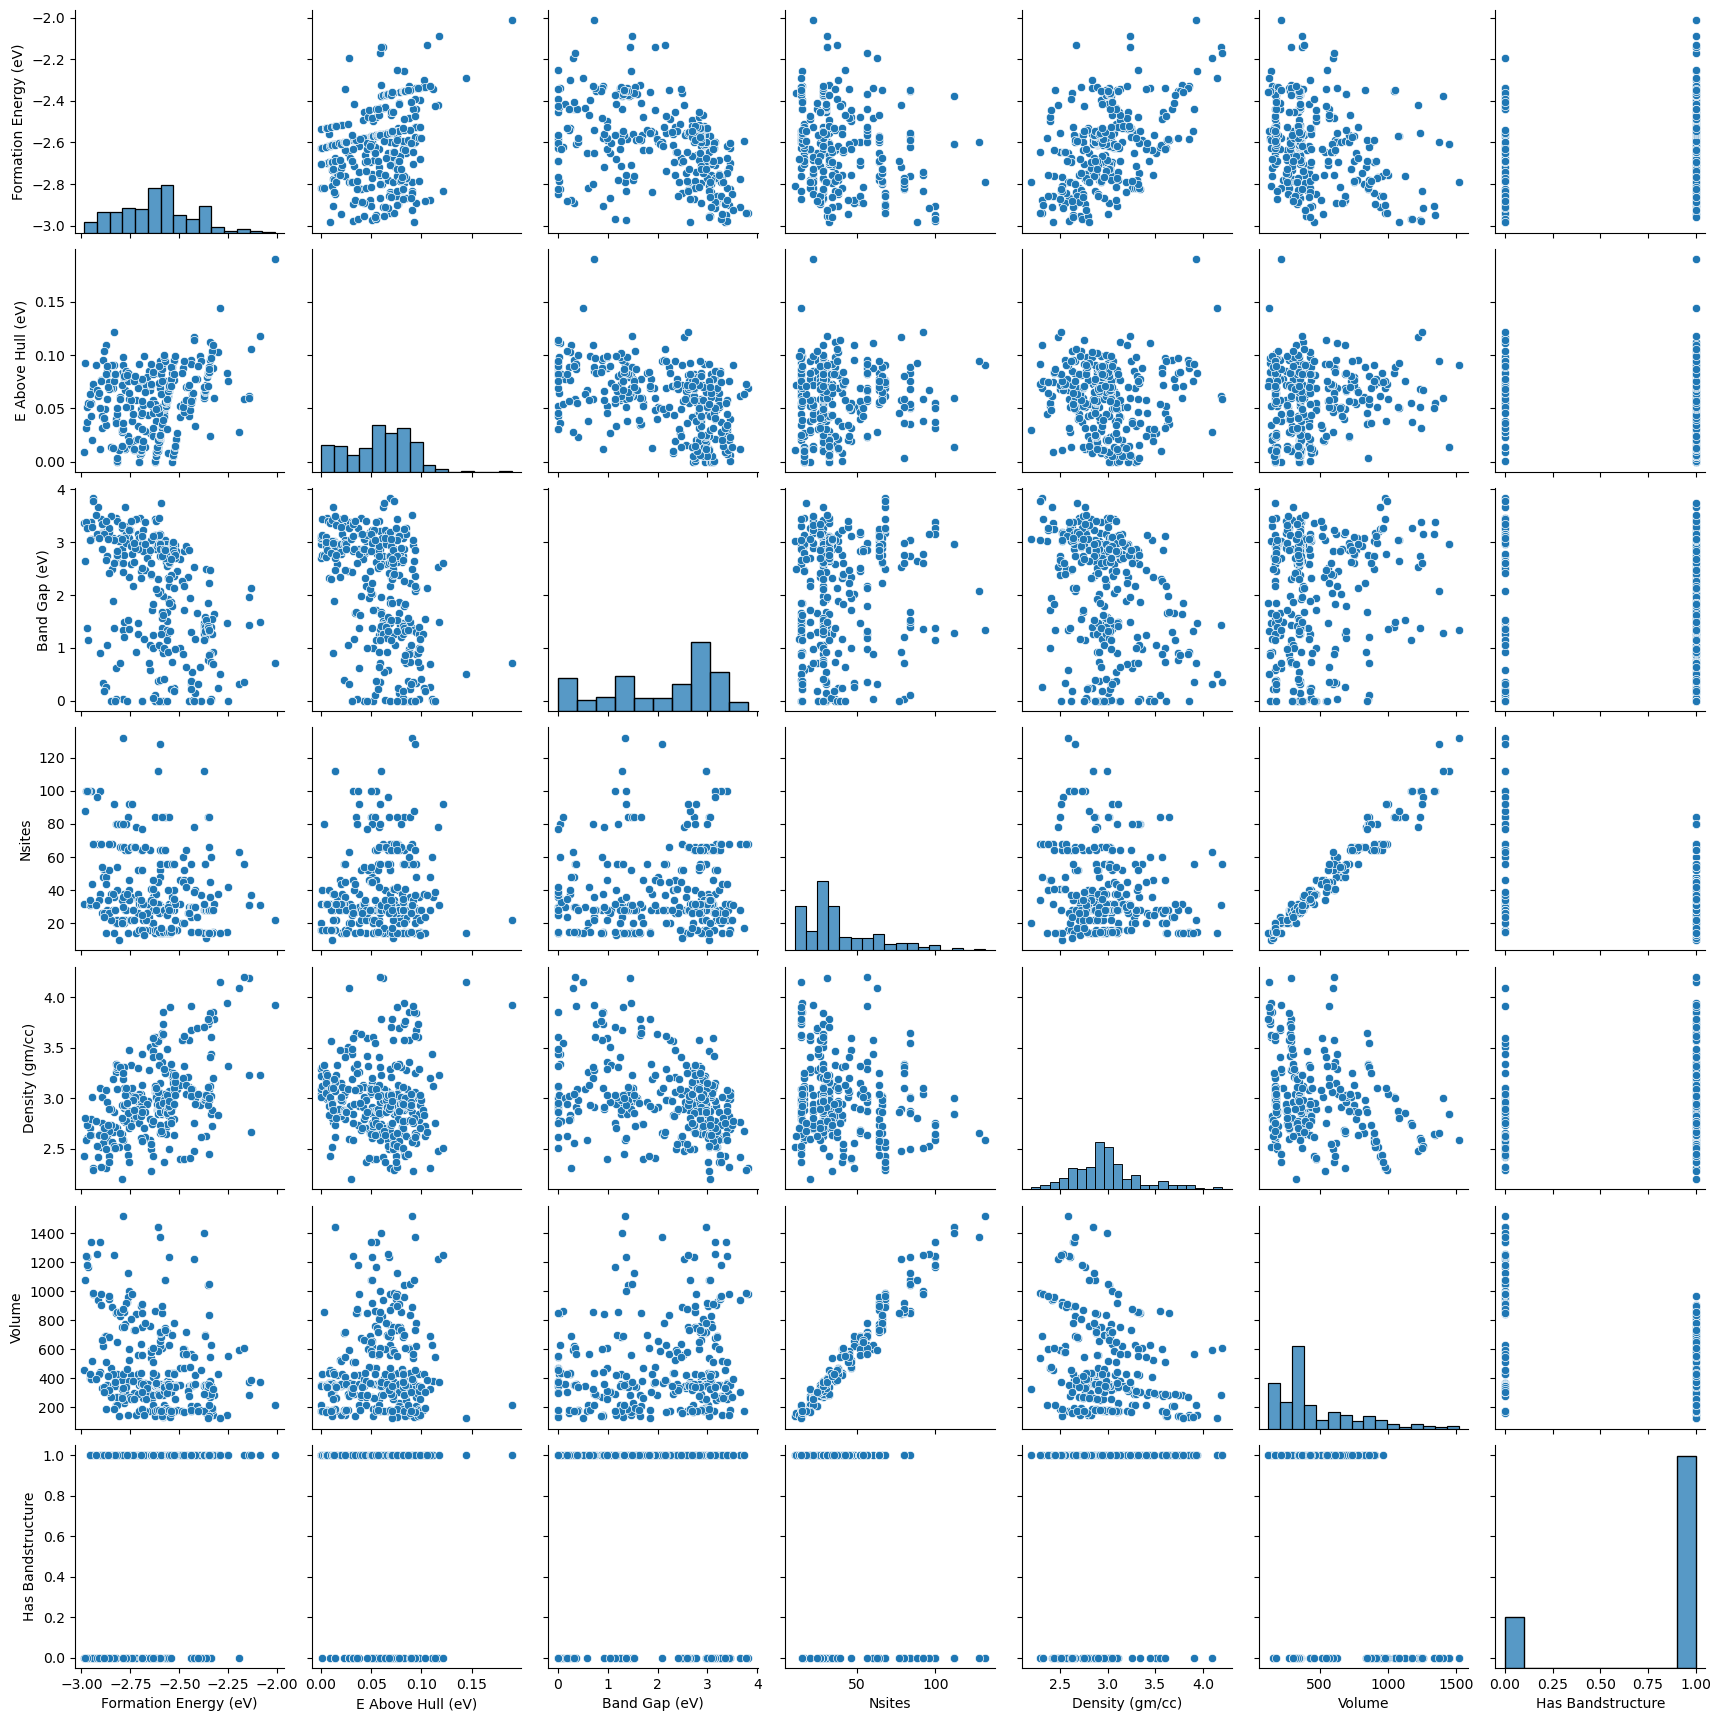

In [200]:
# Visualize the data distribution using pairplot
sns.pairplot(data_raw)

#### Heatmap

Correlation matrix for Most Correlated Features (Top 10):


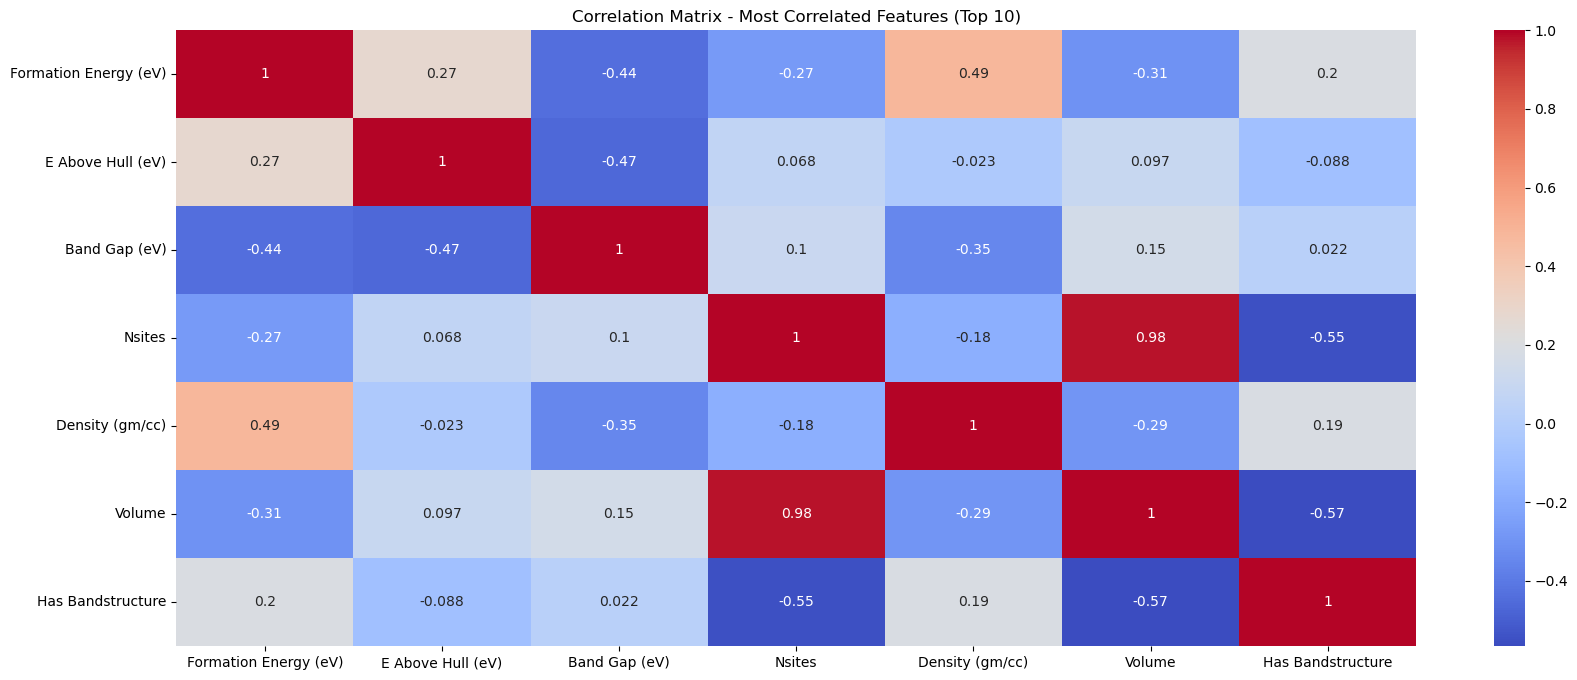

In [201]:
def plot_most_correlated(dataframe, n_most_correlated=10, fig_size=(20, 8)):
    """
    Plot a correlation matrix for the n most correlated columns in a Pandas DataFrame, sorted by maximum absolute correlation.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    n_most_correlated (int): The number of most correlated features to include (default: 10).
    fig_size (tuple): The size of the figure in inches (default: (20, 8)).

    Returns:
    None
    """
    # Calculate correlations
    correlations = dataframe.corr(numeric_only=True)
    
    # Remove self-correlations (correlation of a variable with itself)
    correlations_no_self = correlations[~correlations.index.isin(correlations.columns)]
    
    # Sort features by maximum absolute correlation
    sorted_features = correlations_no_self.abs().max().sort_values(ascending=False).index.to_list()
    
    # Select the n most correlated features
    most_correlated_features = sorted_features[:n_most_correlated]
    
    # Plot correlation matrix for the most correlated features
    fig_title = f"Most Correlated Features (Top {n_most_correlated})"
    df = dataframe[most_correlated_features]
    corr = df.corr(numeric_only=True)
    print(f"Correlation matrix for {fig_title}:")
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
    ax.set_title(f'Correlation Matrix - {fig_title}')
    plt.show()

# Example usage
plot_most_correlated(data_raw, n_most_correlated=10, fig_size=(20, 8))

### Missing Values

In [107]:
def check_nan_values_in_numeric_columns_replace_nan_with_mean_or_drop_if_higher_than_a_threshold(df):
    num_numeric_cols = 0
    num_dropped_cols = 0
    
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            num_numeric_cols += 1
            num_nans = df[col].isnull().sum()
            nan_percentage = (num_nans / df.shape[0]) * 100
            
            if num_nans > 0:
                print(f"The number of rows with NaN values in column '{col}' is {num_nans}, which is {nan_percentage:.2f}%")
                mean_val = df[col].mean()
                
                if nan_percentage > 50:
                    df.drop(col, axis=1, inplace=True)
                    num_dropped_cols += 1
                    print(f"Dropped column '{col}' due to having more than 50% missing values.")
                else:
                    df[col] = df[col].fillna(mean_val)
            else:
                print(f'The number of rows with NaN values in column "{col}" is 0')
        else:
            print(f"Skipping non-numeric column '{col}'")
    
    percentage_dropped_cols = (num_dropped_cols / num_numeric_cols) * 100 if num_numeric_cols != 0 else 0
    
    print(f"\nTotal number of numeric columns: {num_numeric_cols}")
    print(f"Total number of dropped columns: {num_dropped_cols}")
    print(f"Percentage of dropped columns: {percentage_dropped_cols:.2f}%")
    
    return df


def count_nan_values(df):
    """
    Counts the number of NaN values in each column of a DataFrame.
    """
    nan_counts = df.isna().sum()
    nan_percentages = nan_counts / len(df) * 100
    nan_summary = pd.concat([nan_counts, nan_percentages], axis=1)
    nan_summary = nan_summary.rename(columns={0: 'NaN Count', 1: 'NaN Percentage'})
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)
    print(nan_summary)

def filter_rows_with_nan_in_string_cols(df):
    """
    Filter rows that contain NaN values in string/object columns of a pandas DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame containing only unique rows with NaN values in string/object columns.
    """
    string_columns = df.select_dtypes(include=['object']).columns
    filtered_rows = pd.DataFrame()
    for col in string_columns:
        if df[col].isna().any():
            nan_rows = df[df[col].isna()]
            filtered_rows = pd.concat([filtered_rows, nan_rows]).drop_duplicates()
    return filtered_rows

data_raw.shape

(339, 11)

In [108]:
df = check_nan_values_in_numeric_columns_replace_nan_with_mean_or_drop_if_higher_than_a_threshold(data_raw)

Skipping non-numeric column 'Materials Id'
Skipping non-numeric column 'Formula'
Skipping non-numeric column 'Spacegroup'
The number of rows with NaN values in column "Formation Energy (eV)" is 0
The number of rows with NaN values in column "E Above Hull (eV)" is 0
The number of rows with NaN values in column "Band Gap (eV)" is 0
The number of rows with NaN values in column "Nsites" is 0
The number of rows with NaN values in column "Density (gm/cc)" is 0
The number of rows with NaN values in column "Volume" is 0
Skipping non-numeric column 'Has Bandstructure'
Skipping non-numeric column 'Crystal System'

Total number of numeric columns: 6
Total number of dropped columns: 0
Percentage of dropped columns: 0.00%


In [109]:
count_nan_values(df)

                       NaN Count  NaN Percentage
Materials Id                   0             0.0
Formula                        0             0.0
Spacegroup                     0             0.0
Formation Energy (eV)          0             0.0
E Above Hull (eV)              0             0.0
Band Gap (eV)                  0             0.0
Nsites                         0             0.0
Density (gm/cc)                0             0.0
Volume                         0             0.0
Has Bandstructure              0             0.0
Crystal System                 0             0.0


In [110]:
filter_rows_with_nan_in_string_cols(df)

Empty DataFrame
Columns: []
Index: []

### Zero - Values

In [111]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def get_zero_percentages(df):
    """
    Calculates the number and percentage of features with specific percentages of zero values
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")
    
def remove_high_zero_features(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns)
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns)

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

In [112]:
get_zero_percentages(df)

Number of features: 6
Percentage of columns with all zero values: 0.00%
Percentage of columns with at least 95% zero values: 0.00%
Percentage of columns with at least 90% zero values: 0.00%
Percentage of columns with at least 80% zero values: 0.00%
Percentage of columns with at least 70% zero values: 0.00%
Percentage of columns with at least 60% zero values: 0.00%
Percentage of columns with at least 50% zero values: 0.00%


In [113]:
df = remove_high_zero_features(df)

Number of initial features: 11
Percentage of columns with all zero values: 0.00%
Percentage of columns with at least 95% zero values: 0.00%
Percentage of columns with at least 90% zero values: 0.00%
Percentage of columns with at least 80% zero values: 0.00%
Percentage of columns with at least 70% zero values: 0.00%
Percentage of columns with at least 60% zero values: 0.00%
Percentage of columns with at least 50% zero values: 0.00%
Percentage of features removed due to high percentage of zeros: 0.00%
Number of remaining features: 11


### Uniqueness of the dataser

In [114]:
def count_unique_values(dataframe):
    """
    Count the number of unique values for each column in a DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    pandas.Series: A Series with the number of unique values for each column.
    """
    distinct_counter = dataframe.apply(lambda x: len(x.unique()))
    return distinct_counter

# Example usage
distinct_counter = count_unique_values(data_raw)
print(distinct_counter)

Materials Id             339
Formula                  114
Spacegroup                44
Formation Energy (eV)    251
E Above Hull (eV)        108
Band Gap (eV)            307
Nsites                    49
Density (gm/cc)          300
Volume                   339
Has Bandstructure          2
Crystal System             3
dtype: int64


In [115]:
unique_categories = df['Crystal System'].unique()
print("Crystal System:", unique_categories)

Crystal System: ['monoclinic' 'orthorhombic' 'triclinic']


## Feature Engineering

    Encode categorical features like Spacegroup using one-hot encoding or other suitable encoding techniques.

    To encode categorical features, you can use one-hot encoding or label encoding. One-hot encoding is suitable for nominal categorical features that do not have an inherent order, while label encoding can be used for ordinal categorical features. Here's an example using pandas' get_dummies function for one-hot encoding:

### One-Hot encoding

In [116]:
def one_hot_encode(df, column):
    one_hot_encoded = pd.get_dummies(df[column], prefix=column).astype(int)
    df = pd.concat([df.drop(column, axis=1), one_hot_encoded], axis=1)
    return df

# Example usage
data_encoded = one_hot_encode(data_raw, 'Spacegroup')

In [117]:
data_raw.head()

Materials Id       Formula Spacegroup  Formation Energy (eV)   
0    mp-849394     Li2MnSiO4         Pc                 -2.699  \
1    mp-783909     Li2MnSiO4      P21/c                 -2.696   
2    mp-761311    Li4MnSi2O7         Cc                 -2.775   
3    mp-761598  Li4Mn2Si3O10       C2/c                 -2.783   
4    mp-767709  Li2Mn3Si3O10       C2/c                 -2.747   

   E Above Hull (eV)  Band Gap (eV)  Nsites  Density (gm/cc)   Volume   
0              0.006          3.462      16            2.993  178.513  \
1              0.008          2.879      32            2.926  365.272   
2              0.012          3.653      28            2.761  301.775   
3              0.013          3.015      38            2.908  436.183   
4              0.016          2.578      36            3.334  421.286   

   Has Bandstructure Crystal System  
0               True     monoclinic  
1               True     monoclinic  
2               True     monoclinic  
3               True     monoclinic  
4               True     monoclinic

In [118]:
data_encoded.head()

Materials Id       Formula  Formation Energy (eV)  E Above Hull (eV)   
0    mp-849394     Li2MnSiO4                 -2.699              0.006  \
1    mp-783909     Li2MnSiO4                 -2.696              0.008   
2    mp-761311    Li4MnSi2O7                 -2.775              0.012   
3    mp-761598  Li4Mn2Si3O10                 -2.783              0.013   
4    mp-767709  Li2Mn3Si3O10                 -2.747              0.016   

   Band Gap (eV)  Nsites  Density (gm/cc)   Volume  Has Bandstructure   
0          3.462      16            2.993  178.513               True  \
1          2.879      32            2.926  365.272               True   
2          3.653      28            2.761  301.775               True   
3          3.015      38            2.908  436.183               True   
4          2.578      36            3.334  421.286               True   

  Crystal System  Spacegroup_C2  Spacegroup_C2/c  Spacegroup_C2/m   
0     monoclinic              0                0                0  \
1     monoclinic              0                0                0   
2     monoclinic              0                0                0   
3     monoclinic              0                1                0   
4     monoclinic              0                1                0   

   Spacegroup_C222  Spacegroup_C2221  Spacegroup_C2cm  Spacegroup_Cc   
0                0                 0                0              0  \
1                0                 0                0              0   
2                0                 0                0              1   
3                0                 0                0              0   
4                0                 0                0              0   

   Spacegroup_Ccme  Spacegroup_Cmce  Spacegroup_Cmcm  Spacegroup_F2dd   
0                0                0                0                0  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Spacegroup_Fdd2  Spacegroup_Ibmm  Spacegroup_Icma  Spacegroup_Imcm   
0                0                0                0                0  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Spacegroup_Imma  Spacegroup_P1  Spacegroup_P2  Spacegroup_P2/c   
0                0              0              0                0  \
1                0              0              0                0   
2                0              0              0                0   
3                0              0              0                0   
4                0              0              0                0   

   Spacegroup_P2/m  Spacegroup_P21  Spacegroup_P21/c  Spacegroup_P21/m   
0                0               0                 0                 0  \
1                0               0                 1                 0   
2                0               0                 0                 0   
3                0               0                 0                 0   
4                0               0                 0                 0   

   Spacegroup_P212121  Spacegroup_P21cn  Spacegroup_P21nb  Spacegroup_P21nm   
0                   0                 0                 0                 0  \
1                   0                 0                 0                 0   
2                   0                 0                 0                 0   
3                   0                 0                 0                 0   
4                   0                 0                 0                 0   

   Spacegroup_Pb21a  Spacegroup_Pbca  Spacegroup_Pbn21  S

In [119]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Materials Id           339 non-null    object 
 1   Formula                339 non-null    object 
 2   Formation Energy (eV)  339 non-null    float64
 3   E Above Hull (eV)      339 non-null    float64
 4   Band Gap (eV)          339 non-null    float64
 5   Nsites                 339 non-null    int64  
 6   Density (gm/cc)        339 non-null    float64
 7   Volume                 339 non-null    float64
 8   Has Bandstructure      339 non-null    bool   
 9   Crystal System         339 non-null    object 
 10  Spacegroup_C2          339 non-null    int32  
 11  Spacegroup_C2/c        339 non-null    int32  
 12  Spacegroup_C2/m        339 non-null    int32  
 13  Spacegroup_C222        339 non-null    int32  
 14  Spacegroup_C2221       339 non-null    int32  
 15  Spaceg

#### Feature E. preliminary conclusions

    The number of features in the dataset was incremented in 44 new numerical features. The categorical feature 'Spacegroup' was deleted from the dataset. As it can be seen in the uniqueness analysis, the 'Spacegroup' feature has 44 unique categorical calsses, which correspond to the number of new encoding features.

    Applying one-hot encoding to categorical variables can be useful in many cases, but we should carefully consider its implications on your dataset, model, and the specific problem we are trying to solve. Let's discuss the two remaining categorical features:

    Materials Id: This feature seems to be a unique identifier for each material. In most cases, we should not include an identifier variable in the feature set because it doesn't provide any useful information for predicting the target variable. Including it may lead to overfitting, as the model might learn to associate specific IDs with the target variable, which won't generalize well to unseen data. So, we should remove the Materials Id column from your dataset.

    Formula: One-hot encoding might not be the best approach here because there are 114 unique formulas. This would lead to a significant increase in the number of features, potentially causing the "curse of dimensionality." Instead, we can try other encoding techniques that can capture the information in the chemical formula more efficiently. One such approach is to extract features from the chemical formula, such as the number of elements, the atomic composition (fraction of each element), or properties of the constituent elements (e.g., atomic weight, electronegativity, etc.). By extracting meaningful features from the formula, you can potentially reduce the dimensionality and still capture useful information for your model.

    Here's a summary of what we can do with the two categorical features:

    1. Remove 'Materials Id' from the dataset, as it is likely not useful for prediction and can lead to overfitting.
    
    2. For the 'Formula' feature, we can consider extracting meaningful features from the chemical formula instead of using one-hot encoding. Some possible features include:
       - Number of elements in the formula
       - Atomic composition (fraction of each element)
       - Properties of the constituent elements (e.g., atomic weight, electronegativity, etc.)

    By following this approach, we can reduce the dimensionality of the dataset while still capturing useful information from the categorical features. This should make it easier to train our machine learning model and help it generalize better to unseen data.

In [120]:
# Remove 'Materials Id' column from the dataset
data_cleaned = data_encoded.drop(columns=['Materials Id'])
data_cleaned.shape

(339, 53)

In [121]:
def extract_formula_features(dataframe):
    # Define a function to calculate the number of elements in the formula
    def count_elements(formula):
        composition = Composition(formula)
        return len(composition)

    # Define a function to calculate the atomic composition (fraction of each element)
    def atomic_composition(formula):
        composition = Composition(formula)
        return composition.get_el_amt_dict()

    # Define a function to compute the average atomic weight for a formula
    def average_atomic_weight(formula):
        composition = Composition(formula)
        atomic_weights = [Element(element).atomic_mass * composition.get_atomic_fraction(element) for element in composition.elements]
        return sum(atomic_weights)

    # Define a function to compute the average electronegativity for a formula
    def average_electronegativity(formula):
        composition = Composition(formula)
        electronegativities = [Element(element).X * composition.get_atomic_fraction(element) for element in composition.elements]
        return sum(electronegativities)

    # Calculate the number of elements for each formula
    dataframe['Element_Count'] = dataframe['Formula'].apply(count_elements)

    # Calculate the atomic composition for each formula and create new columns for each element
    dataframe['Atomic_Composition'] = dataframe['Formula'].apply(atomic_composition)
    atomic_composition_df = dataframe['Atomic_Composition'].apply(pd.Series)
    dataframe = pd.concat([dataframe, atomic_composition_df], axis=1).drop(columns=['Atomic_Composition'])

    # Calculate the average atomic weight for each formula
    dataframe['Average_Atomic_Weight'] = dataframe['Formula'].apply(average_atomic_weight)

    # Calculate the average electronegativity for each formula
    dataframe['Average_Electronegativity'] = dataframe['Formula'].apply(average_electronegativity)

    return dataframe

# Apply the feature extraction function to the cleaned dataset
data_with_formula_features = extract_formula_features(data_cleaned)


##### Note I:

    Composition(formula) creates an object representing the chemical composition of the given formula. It takes a string representing a chemical formula and parses it into a dictionary-like object that contains the elements and their respective amounts in the formula.

    composition.get_el_amt_dict() returns a dictionary representing the atomic composition of the formula. The keys are the elements in the formula, and the values are their corresponding amounts.

    Element(element).atomic_mass retrieves the atomic mass of a given element. Element(element) creates an object representing the chemical element, and .atomic_mass is an attribute of that object that stores the atomic mass value for the element.

    composition.get_atomic_fraction(element) returns the atomic fraction of a given element in the composition. The atomic fraction is the ratio of the amount of the element in the formula to the total amount of all elements in the formula.

    composition.elements returns a list of element objects present in the composition.

    Element(element).X retrieves the electronegativity value (Pauling scale) of a given element. Element(element) creates an object representing the chemical element, and .X is an attribute of that object that stores the electronegativity value for the element.

In [122]:
# chemical composition of a given formula
composition = Composition("Fe2O3")
print('chemical composition of a given formula: ', composition)
# atomic composition of the formula
composition = Composition("Fe2O3")
element_amounts = composition.get_el_amt_dict()
print('atomic composition of the formula: ', element_amounts)
# atomic mass of a given element
element = Element("Fe")
print('atomic mass of a given element: ', element.atomic_mass)
# atomic fraction of a given element in the composition
composition = Composition("Fe2O3")
atomic_fraction = composition.get_atomic_fraction("Fe") # 2/5
print('atomic fraction of a given element in the composition: ', atomic_fraction)
# elements in the composition, sorted by their atomic number
composition = Composition("Fe2O3")
elements = composition.elements
print('elements in the composition, sorted by their atomic number: ', elements)
# electronegativity of a given elemen
element = Element("O")
print('electronegativity of a given elemen: ', element.X)

chemical composition of a given formula:  Fe2 O3
atomic composition of the formula:  defaultdict(<class 'float'>, {'Fe': 2.0, 'O': 3.0})
atomic mass of a given element:  55.845 amu
atomic fraction of a given element in the composition:  0.4
elements in the composition, sorted by their atomic number:  [Element Fe, Element O]
electronegativity of a given elemen:  3.44


In [123]:
data_with_formula_features.sample(10)

Formula  Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)   
173       LiMnSiO4                 -2.581              0.097          0.903  \
117  Li3Co2(SiO4)2                 -2.431              0.064          0.022   
184      Li2FeSiO4                 -2.613              0.014          2.924   
95     Li2FeSi4O11                 -2.785              0.098          0.030   
200    Li2Fe2Si2O7                 -2.603              0.046          3.129   
57       LiFeSi3O8                 -2.887              0.040          3.144   
279  Li9Mn5(SiO8)2                 -2.372              0.070          1.154   
105  Li3Co2(SiO4)2                 -2.452              0.043          0.000   
237      Li2CoSiO4                 -2.532              0.005          2.918   
254    Li2Co2Si2O7                 -2.453              0.072          2.840   

     Nsites  Density (gm/cc)   Volume  Has Bandstructure Crystal System   
173      14            3.739  136.740               True   orthorhombic  \
117      30            3.032  353.617               True     monoclinic   
184      32            3.070  350.111               True   orthorhombic   
95       36            2.788  426.538              False     monoclinic   
200      26            3.414  285.751               True   orthorhombic   
57       52            2.690  679.101               True     monoclinic   
279      32            3.706  290.951               True      triclinic   
105      30            3.115  344.253               True     monoclinic   
237      32            3.181  344.330               True   orthorhombic   
254      26            3.579  278.304               True   orthorhombic   

     Spacegroup_C2  Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_C222   
173              0                0                0                0  \
117              0                0                0                0   
184              0                0                0                0   
95               0                1                0                0   
200              0                0                0                0   
57               0                0                0                0   
279              0                0                0                0   
105              0                0                0                0   
237              0                0                0                0   
254              0                0                0                0   

     Spacegroup_C2221  Spacegroup_C2cm  Spacegroup_Cc  Spacegroup_Ccme   
173                 0                0              0                0  \
117                 0                0              0                0   
184                 0                0              0                0   
95                  0                0              0                0   
200                 0                1              0                0   
57                  0                0              0                0   
279                 0                0              0                0   
105                 0                0              0                0   
237                 0                0              0                0   
254                 0                1              0                0   

     Spacegroup_Cmce  Spacegroup_Cmcm  Spacegroup_F2dd  Spacegroup_Fdd2   
173                0                0                0                0  \
117                0                0                0                0   
184                0                0                0                0   
95                 0                0                0                0   
200                0                0                0                0   
57                 0                0                0                0   
279                0                0                0                0   
105                0                0                0                0   
237                0 

In [124]:
distinct_counter = count_unique_values(data_with_formula_features)
print(distinct_counter)

Formula                      114
Formation Energy (eV)        251
E Above Hull (eV)            108
Band Gap (eV)                307
Nsites                        49
Density (gm/cc)              300
Volume                       339
Has Bandstructure              2
Crystal System                 3
Spacegroup_C2                  2
Spacegroup_C2/c                2
Spacegroup_C2/m                2
Spacegroup_C222                2
Spacegroup_C2221               2
Spacegroup_C2cm                2
Spacegroup_Cc                  2
Spacegroup_Ccme                2
Spacegroup_Cmce                2
Spacegroup_Cmcm                2
Spacegroup_F2dd                2
Spacegroup_Fdd2                2
Spacegroup_Ibmm                2
Spacegroup_Icma                2
Spacegroup_Imcm                2
Spacegroup_Imma                2
Spacegroup_P1                  2
Spacegroup_P2                  2
Spacegroup_P2/c                2
Spacegroup_P2/m                2
Spacegroup_P21                 2
Spacegroup

In [125]:
count_nan_values(data_with_formula_features)

                           NaN Count  NaN Percentage
Co                               258       76.106195
Mn                               248       73.156342
Fe                               172       50.737463
Formula                            0        0.000000
Spacegroup_Pbn21                   0        0.000000
Spacegroup_Pcmn                    0        0.000000
Spacegroup_Pca21                   0        0.000000
Spacegroup_Pc21n                   0        0.000000
Spacegroup_Pc                      0        0.000000
Spacegroup_Pbnm                    0        0.000000
Spacegroup_Pb21a                   0        0.000000
Spacegroup_Pbca                    0        0.000000
Spacegroup_Pmc21                   0        0.000000
Spacegroup_P21nm                   0        0.000000
Spacegroup_P21nb                   0        0.000000
Spacegroup_P21cn                   0        0.000000
Spacegroup_Pm21n                   0        0.000000
Spacegroup_Pmnb                    0        0.

In [126]:
# Remove 'Materials Id' column from the dataset
data_with_formula_features = data_with_formula_features.drop(columns=['Formula'])
data_with_formula_features.shape

(339, 61)

In [127]:
def replace_nan_with_zeros(df, columns):
    for column in columns:
        if column in df.columns:
            df[column].fillna(0, inplace=True)
    return df

# Example usage
columns_to_replace = ['Co', 'Mn', 'Fe']

data = replace_nan_with_zeros(data_with_formula_features, columns_to_replace)
data.head()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)  Nsites   
0                 -2.699              0.006          3.462      16  \
1                 -2.696              0.008          2.879      32   
2                 -2.775              0.012          3.653      28   
3                 -2.783              0.013          3.015      38   
4                 -2.747              0.016          2.578      36   

   Density (gm/cc)   Volume  Has Bandstructure Crystal System  Spacegroup_C2   
0            2.993  178.513               True     monoclinic              0  \
1            2.926  365.272               True     monoclinic              0   
2            2.761  301.775               True     monoclinic              0   
3            2.908  436.183               True     monoclinic              0   
4            3.334  421.286               True     monoclinic              0   

   Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_C222  Spacegroup_C2221   
0                0                0                0                 0  \
1                0                0                0                 0   
2                0                0                0                 0   
3                1                0                0                 0   
4                1                0                0                 0   

   Spacegroup_C2cm  Spacegroup_Cc  Spacegroup_Ccme  Spacegroup_Cmce   
0                0              0                0                0  \
1                0              0                0                0   
2                0              1                0                0   
3                0              0                0                0   
4                0              0                0                0   

   Spacegroup_Cmcm  Spacegroup_F2dd  Spacegroup_Fdd2  Spacegroup_Ibmm   
0                0                0                0                0  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Spacegroup_Icma  Spacegroup_Imcm  Spacegroup_Imma  Spacegroup_P1   
0                0                0                0              0  \
1                0                0                0              0   
2                0                0                0              0   
3                0                0                0              0   
4                0                0                0              0   

   Spacegroup_P2  Spacegroup_P2/c  Spacegroup_P2/m  Spacegroup_P21   
0              0                0                0               0  \
1              0                0                0               0   
2              0                0                0               0   
3              0                0                0               0   
4              0                0                0               0   

   Spacegroup_P21/c  Spacegroup_P21/m  Spacegroup_P212121  Spacegroup_P21cn   
0                 0                 0                   0                 0  \
1                 1                 0                   0                 0   
2                 0                 0                   0                 0   
3                 0                 0                   0                 0   
4                 0                 0                   0                 0   

   Spacegroup_P21nb  Spacegroup_P21nm  Spacegroup_Pb21a  Spacegroup_Pbca   
0                 0                 0                 0                0  \
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 0                 0                0   
4                 0                 0                 0                0   

   Spacegr

##### Note II:

    As the number of elements in each battery is the same for each instace, the column would not apport any meaningful information for the classification task, so the feature 'Element_Count' will be dropped entirely from the column. 
    
    The 'Has Bandstructure' column is a boolean feature, which indicates whether the material has a band structure or not. It can be a useful feature for certain types of analysis, but it may not have a significant impact on others.

    As we want to keep this feature in your analysis, we can convert it to a numerical value (0 or 1) by updating the data preprocessing step:

In [128]:
# Remove 'Element_Count' column from the dataset
data = data.drop(columns=['Element_Count'])
data['Has Bandstructure'] = data['Has Bandstructure'].astype(int)
data.shape

(339, 60)

In [129]:
data.head()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)  Nsites   
0                 -2.699              0.006          3.462      16  \
1                 -2.696              0.008          2.879      32   
2                 -2.775              0.012          3.653      28   
3                 -2.783              0.013          3.015      38   
4                 -2.747              0.016          2.578      36   

   Density (gm/cc)   Volume  Has Bandstructure Crystal System  Spacegroup_C2   
0            2.993  178.513                  1     monoclinic              0  \
1            2.926  365.272                  1     monoclinic              0   
2            2.761  301.775                  1     monoclinic              0   
3            2.908  436.183                  1     monoclinic              0   
4            3.334  421.286                  1     monoclinic              0   

   Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_C222  Spacegroup_C2221   
0                0                0                0                 0  \
1                0                0                0                 0   
2                0                0                0                 0   
3                1                0                0                 0   
4                1                0                0                 0   

   Spacegroup_C2cm  Spacegroup_Cc  Spacegroup_Ccme  Spacegroup_Cmce   
0                0              0                0                0  \
1                0              0                0                0   
2                0              1                0                0   
3                0              0                0                0   
4                0              0                0                0   

   Spacegroup_Cmcm  Spacegroup_F2dd  Spacegroup_Fdd2  Spacegroup_Ibmm   
0                0                0                0                0  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Spacegroup_Icma  Spacegroup_Imcm  Spacegroup_Imma  Spacegroup_P1   
0                0                0                0              0  \
1                0                0                0              0   
2                0                0                0              0   
3                0                0                0              0   
4                0                0                0              0   

   Spacegroup_P2  Spacegroup_P2/c  Spacegroup_P2/m  Spacegroup_P21   
0              0                0                0               0  \
1              0                0                0               0   
2              0                0                0               0   
3              0                0                0               0   
4              0                0                0               0   

   Spacegroup_P21/c  Spacegroup_P21/m  Spacegroup_P212121  Spacegroup_P21cn   
0                 0                 0                   0                 0  \
1                 1                 0                   0                 0   
2                 0                 0                   0                 0   
3                 0                 0                   0                 0   
4                 0                 0                   0                 0   

   Spacegroup_P21nb  Spacegroup_P21nm  Spacegroup_Pb21a  Spacegroup_Pbca   
0                 0                 0                 0                0  \
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 0                 0                0   
4                 0                 0                 0                0   

   Spacegr

##### Note III:

    To determine if the one-hot encoded 'Spacegroup' features are meaningful for the model, we can:

    Feature importance analysis: Train our model with and without the one-hot encoded 'Spacegroup' features, and compare the performance. If the performance improves significantly with the encoded features, it may indicate that these features are helpful for prediction. We can also use techniques like permutation importance or feature importance from tree-based models to understand how much each feature contributes to the model's predictive power.

    Dimensionality reduction techniques: Since we are adding 44 new features, we might want to consider applying dimensionality reduction techniques, such as PCA (Principal Component Analysis), to reduce the number of features while retaining most of the information. This can help mitigate the potential effects of the "curse of dimensionality" and lead to more efficient and accurate models.

    Domain knowledge: Consult with domain experts or review relevant literature to understand if the 'Spacegroup' feature is known to have a significant impact on the property you are trying to predict. If there is a strong theoretical basis for its importance, including it in your model may be justified.

Correlation matrix for Most Correlated Features (Top 10):


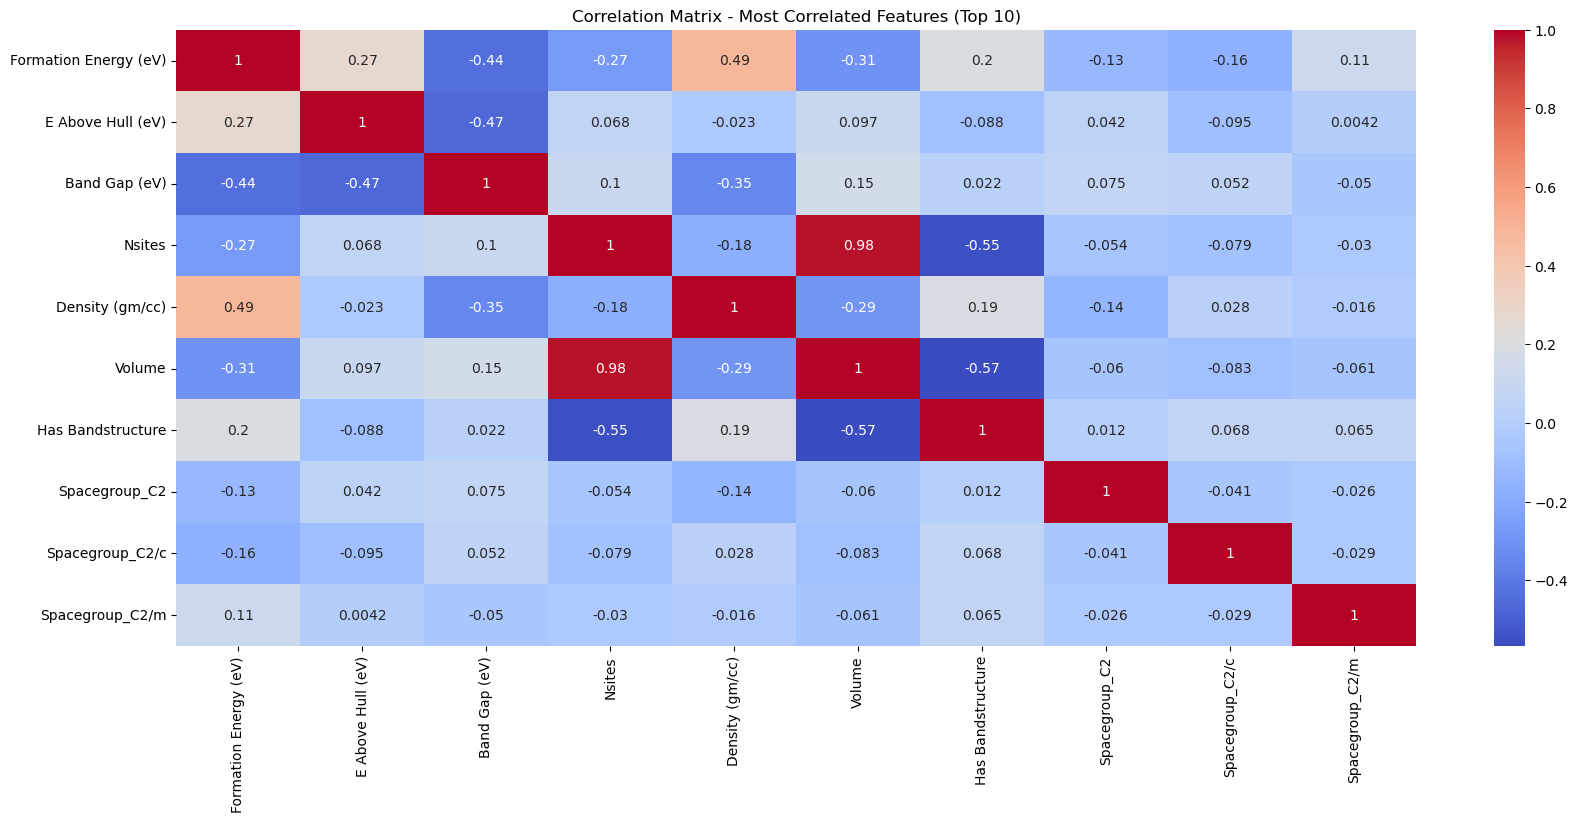

In [130]:
plot_most_correlated(data, n_most_correlated=10, fig_size=(20, 8))

### Supervised Algorithms: Preparing the Labels

    Supervised approach requires labelled data for the training. In this dataset, the objective function is the Crustal Structure (classification) prediction, we need to create a feature matrix say X and and label vector Y. We will use Y to train and test our model.

    In the context of the classification problem at hand, various methodologies such as Logistic Regression, Decision Trees, Random Forest, XGBoost, LightGBM, Neural Networks, Support Vector Machines, and k-Nearest Neighbors require the target variable to be in a numerical format. Therefore, to ensure compatibility and consistency across these models, the target variable representing the classes (monoclinic, orthorhombic, and triclinic) will be converted into numerical labels using an appropriate encoding technique like LabelEncoder from scikit-learn. This preprocessing step will enable seamless implementation and evaluation of the aforementioned classification models on the dataset.

In [131]:
dataX = data.copy().drop(['Crystal System'], axis=1)
dataY = data['Crystal System'].copy()

In [132]:
# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder to the data and transform the data
dataY_encoded = le.fit_transform(dataY)

# Convert the NumPy array to a pandas DataFrame
dataY_encoded_df = pd.DataFrame(dataY_encoded, columns=['Encoded_Label'])

# You can also convert back to the original labels using inverse_transform
original_dataY = le.inverse_transform(dataY_encoded)

#### Note I:

    Here:

    - 0 is Monoclinic
    - 1 is Orthorhombic
    - 2 is Triclinic

In [133]:
dataY_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [134]:
type(dataY_encoded)

numpy.ndarray

In [135]:
original_dataY

array(['monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'monoc

In [136]:
dataY_encoded_df.value_counts()

Encoded_Label
0                139
1                128
2                 72
Name: count, dtype: int64

## Descriptive and Boxplot Analysis

    Before Standardizing

In [137]:
dataY_encoded_df.shape

(339, 1)

                           count        mean         std         min   
Formation Energy (eV)      339.0   -2.616950    0.183809   -2.985000  \
E Above Hull (eV)          339.0    0.058215    0.030363    0.000000   
Band Gap (eV)              339.0    2.079740    1.087968    0.000000   
Nsites                     339.0   38.837758   23.133142   10.000000   
Density (gm/cc)            339.0    2.984003    0.353968    2.200000   
Volume                     339.0  467.765619  292.674559  122.581000   
Has Bandstructure          339.0    0.808260    0.394252    0.000000   
Spacegroup_C2              339.0    0.035398    0.185057    0.000000   
Spacegroup_C2/c            339.0    0.044248    0.205949    0.000000   
Spacegroup_C2/m            339.0    0.017699    0.132050    0.000000   
Spacegroup_C222            339.0    0.008850    0.093793    0.000000   
Spacegroup_C2221           339.0    0.017699    0.132050    0.000000   
Spacegroup_C2cm            339.0    0.017699    0.132050    0.00

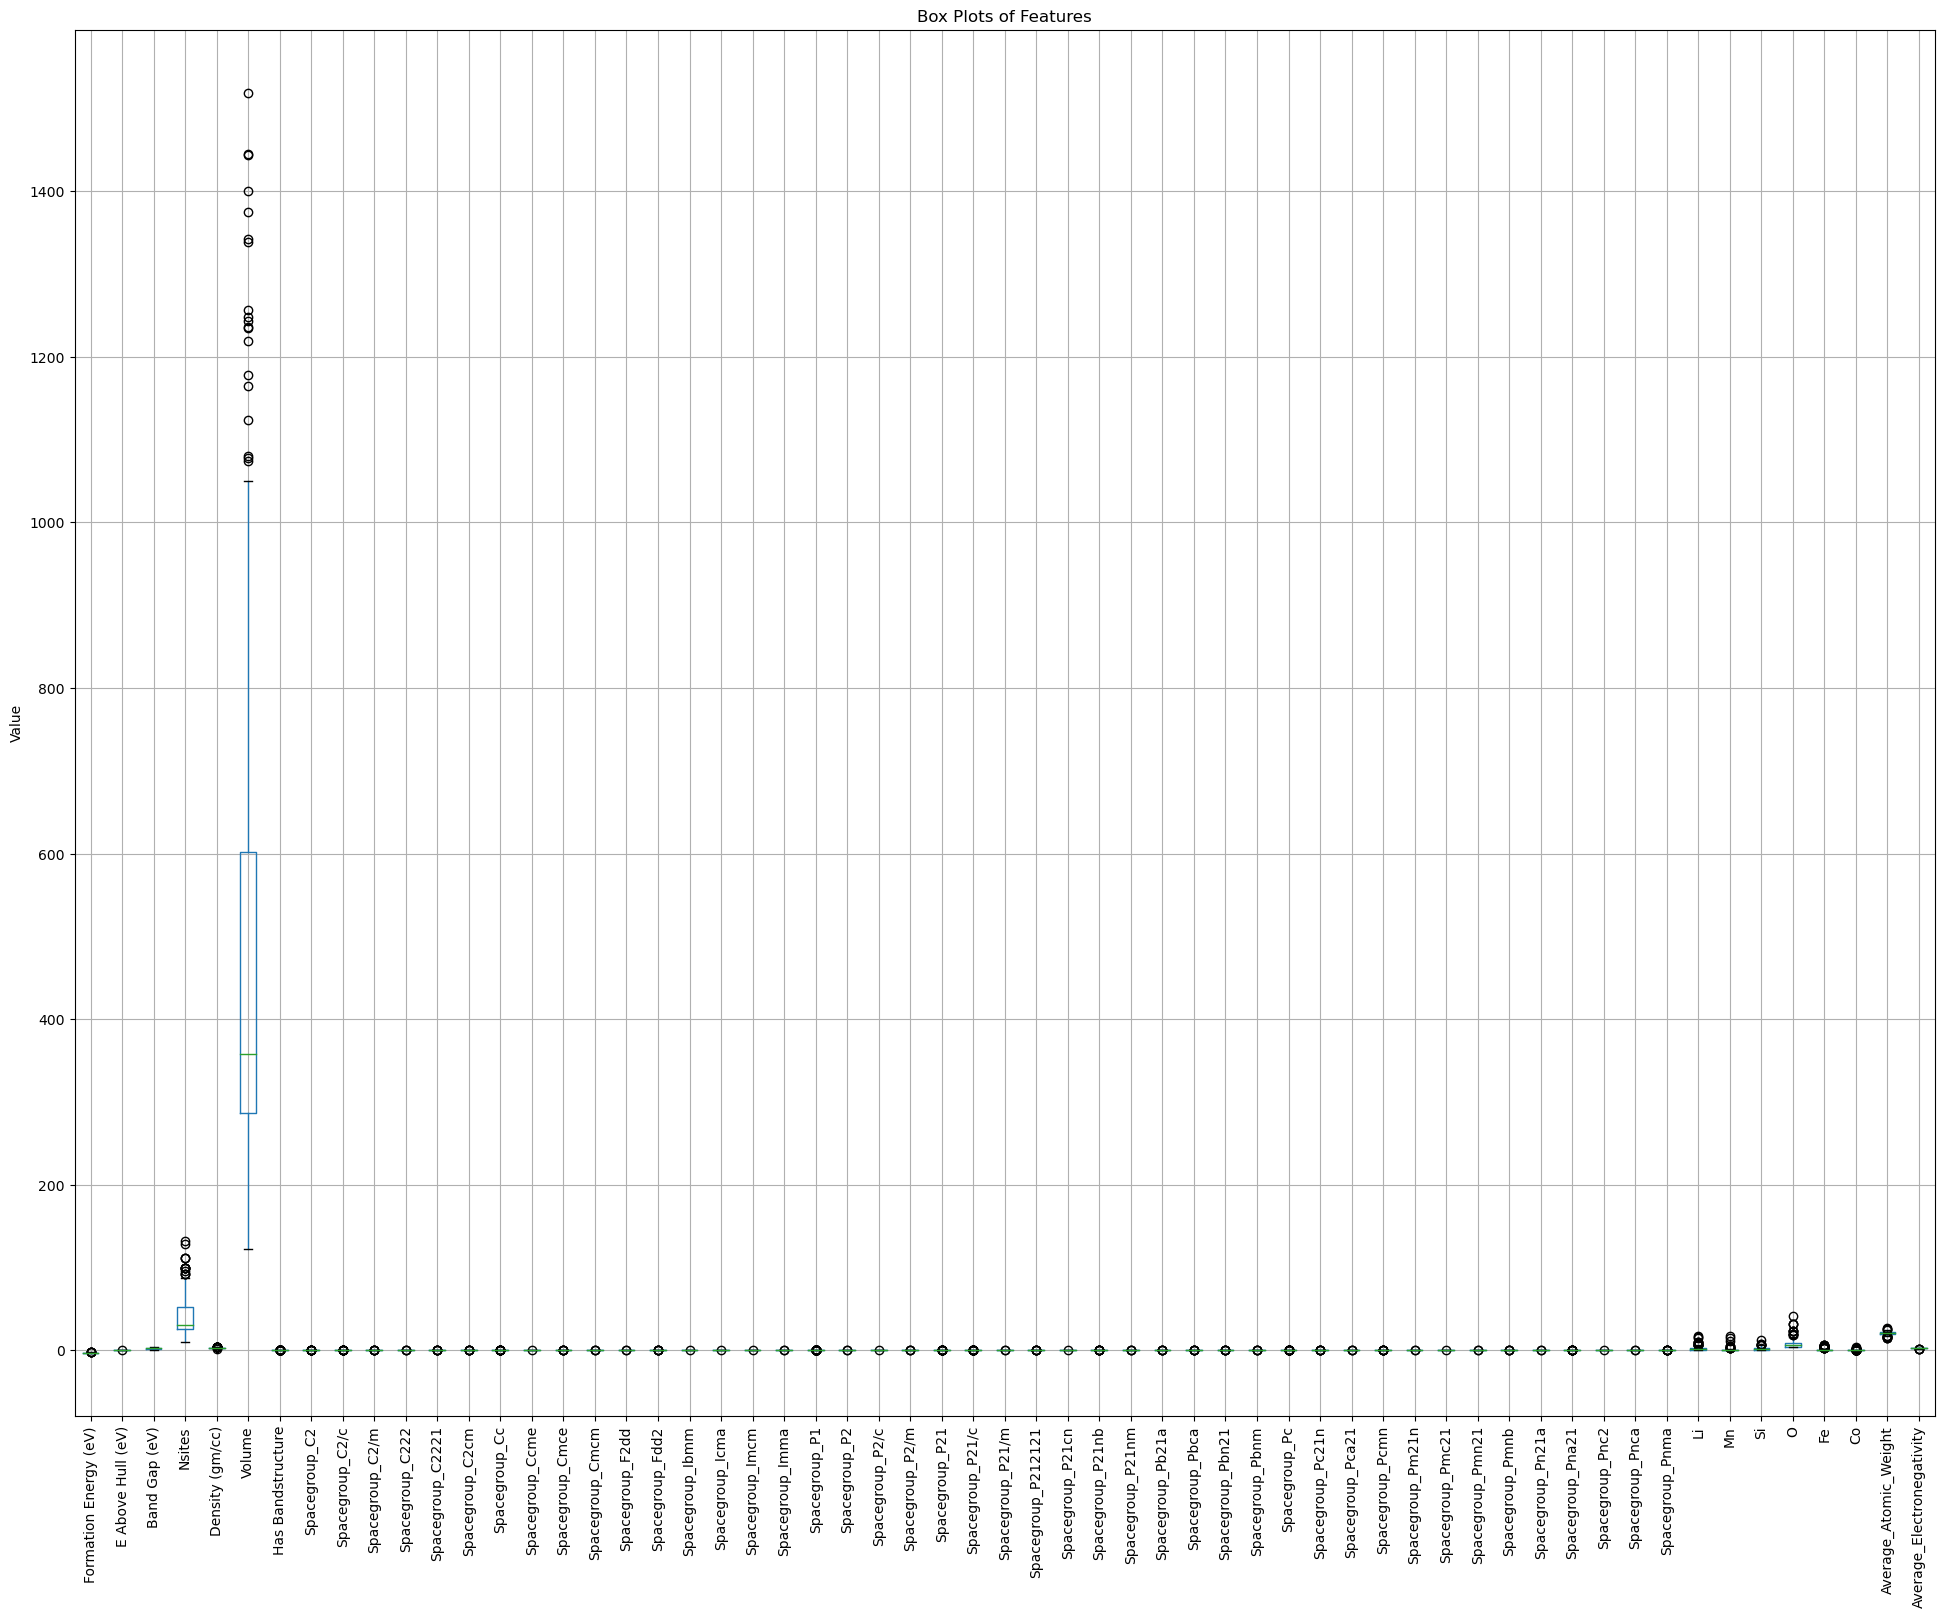

In [138]:
def analyze_features(dataX):
    """
    Calculate descriptive statistics and visualize distributions of features using box plots.

    Args:
    dataX (pd.DataFrame): Input features dataset.

    Returns:
    None
    """

    # Calculate descriptive statistics
    statistics = dataX.describe().transpose()
    print(statistics)

    # Visualize distributions using box plots
    plt.figure(figsize=(24, 18))
    dataX.boxplot()
    plt.xticks(rotation=90)
    plt.title('Box Plots of Features')
    plt.ylabel('Value')
    plt.show()

# Example usage:
analyze_features(dataX)

## Standardization

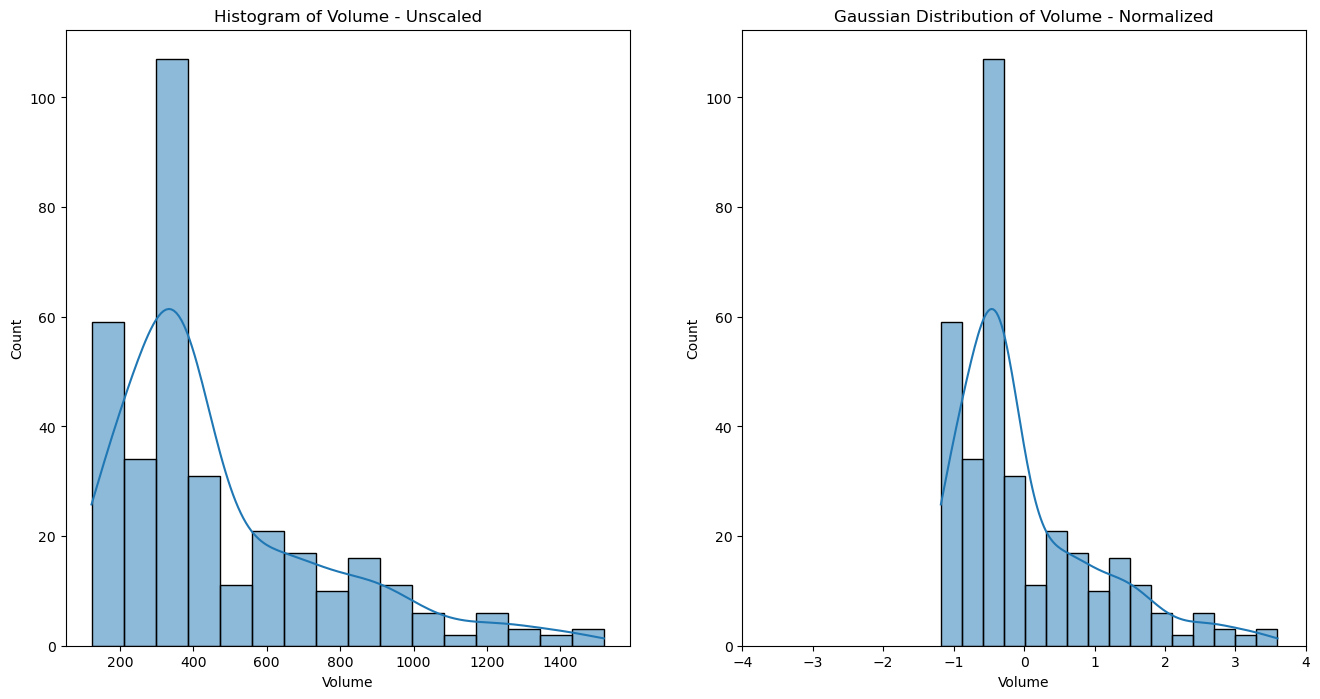

In [139]:
def scale_and_plot_gaussian_distribution(df, col_name):
    #Rescaling the data
    featuresToScale = dataX.columns
    sX = pp.StandardScaler(copy=True)
    df_std = df.copy()
    df.loc[:,featuresToScale] = sX.fit_transform(df[featuresToScale])
    #Looking into the statistics again:
    df.describe()

    # Plot the histogram and Gaussian distribution using seaborn
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(df_std[col_name], kde=True)
    plt.title(f'Histogram of {col_name} - Unscaled')

    plt.subplot(1, 2, 2)
    sns.histplot(df[col_name], kde=True)
    plt.title(f'Gaussian Distribution of {col_name} - Normalized')
    plt.xlim([-4, 4])
    plt.show()
    
scale_and_plot_gaussian_distribution(dataX, "Volume")

In [140]:
dataX.head()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)    Nsites   
0              -0.447048          -1.722253       1.272374 -0.988690  \
1              -0.430703          -1.656286       0.735721 -0.296020   
2              -0.861132          -1.524351       1.448190 -0.469187   
3              -0.904720          -1.491367       0.860909 -0.036268   
4              -0.708575          -1.392416       0.458650 -0.122852   

   Density (gm/cc)    Volume  Has Bandstructure  Spacegroup_C2   
0         0.025455 -0.989769           0.487059      -0.191565  \
1        -0.164107 -0.350714           0.487059      -0.191565   
2        -0.630939 -0.567989           0.487059      -0.191565   
3        -0.215034 -0.108070           0.487059      -0.191565   
4         0.990242 -0.159045           0.487059      -0.191565   

   Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_C222  Spacegroup_C2221   
0        -0.215166        -0.134231        -0.094491         -0.134231  \
1        -0.215166        -0.134231        -0.094491         -0.134231   
2        -0.215166        -0.134231        -0.094491         -0.134231   
3         4.647580        -0.134231        -0.094491         -0.134231   
4         4.647580        -0.134231        -0.094491         -0.134231   

   Spacegroup_C2cm  Spacegroup_Cc  Spacegroup_Ccme  Spacegroup_Cmce   
0        -0.134231      -0.222566        -0.054393        -0.134231  \
1        -0.134231      -0.222566        -0.054393        -0.134231   
2        -0.134231       4.493050        -0.054393        -0.134231   
3        -0.134231      -0.222566        -0.054393        -0.134231   
4        -0.134231      -0.222566        -0.054393        -0.134231   

   Spacegroup_Cmcm  Spacegroup_F2dd  Spacegroup_Fdd2  Spacegroup_Ibmm   
0        -0.094491        -0.077037        -0.134231        -0.054393  \
1        -0.094491        -0.077037        -0.134231        -0.054393   
2        -0.094491        -0.077037        -0.134231        -0.054393   
3        -0.094491        -0.077037        -0.134231        -0.054393   
4        -0.094491        -0.077037        -0.134231        -0.054393   

   Spacegroup_Icma  Spacegroup_Imcm  Spacegroup_Imma  Spacegroup_P1   
0        -0.054393        -0.054393        -0.077037      -0.519291  \
1        -0.054393        -0.054393        -0.077037      -0.519291   
2        -0.054393        -0.054393        -0.077037      -0.519291   
3        -0.054393        -0.054393        -0.077037      -0.519291   
4        -0.054393        -0.054393        -0.077037      -0.519291   

   Spacegroup_P2  Spacegroup_P2/c  Spacegroup_P2/m  Spacegroup_P21   
0      -0.077037        -0.054393        -0.094491       -0.269787  \
1      -0.077037        -0.054393        -0.094491       -0.269787   
2      -0.077037        -0.054393        -0.094491       -0.269787   
3      -0.077037        -0.054393        -0.094491       -0.269787   
4      -0.077037        -0.054393        -0.094491       -0.269787   

   Spacegroup_P21/c  Spacegroup_P21/m  Spacegroup_P212121  Spacegroup_P21cn   
0         -0.322854         -0.077037           -0.134231         -0.054393  \
1          3.097378         -0.077037           -0.134231         -0.054393   
2         -0.322854         -0.077037           -0.134231         -0.054393   
3         -0.322854         -0.077037           -0.134231         -0.054393   
4         -0.322854         -0.077037           -0.134231         -0.054393   

   Spacegroup_P21nb  Spacegroup_P21nm  Spacegroup_Pb21a  Spacegroup_Pbca   
0         -0.155464         -0.094491         -0.122352        -0.134231  \
1         -0.155464         -0.094491         -0.122352        -0.134231   
2         -0.155464         -0.094491         -0.122352        -0.134231   
3         -0.155464         -0.094491         -0.122352        -0.134231   
4         -0.155464         -0.094491         -0.122352        -0.134231   

   Spacegroup_Pbn21  Spacegroup_Pbnm  Spacegroup_Pc  Spacegroup_Pc21n   
0        

                           count          mean       std       min       25%   
Formation Energy (eV)      339.0 -1.110878e-15  1.001478 -2.005312 -0.765784  \
E Above Hull (eV)          339.0  1.467197e-16  1.001478 -1.920155 -0.749235   
Band Gap (eV)              339.0 -2.515196e-16  1.001478 -1.914408 -0.749511   
Nsites                     339.0 -1.309998e-16  1.001478 -1.248442 -0.555771   
Density (gm/cc)            339.0 -5.554390e-16  1.001478 -2.218170 -0.632354   
Volume                     339.0  2.095996e-16  1.001478 -1.181158 -0.620663   
Has Bandstructure          339.0  1.047998e-16  1.001478 -2.053140  0.487059   
Spacegroup_C2              339.0 -2.095996e-17  1.001478 -0.191565 -0.191565   
Spacegroup_C2/c            339.0  2.095996e-17  1.001478 -0.215166 -0.215166   
Spacegroup_C2/m            339.0 -4.191993e-17  1.001478 -0.134231 -0.134231   
Spacegroup_C222            339.0 -3.667993e-17  1.001478 -0.094491 -0.094491   
Spacegroup_C2221           339.0  2.6199

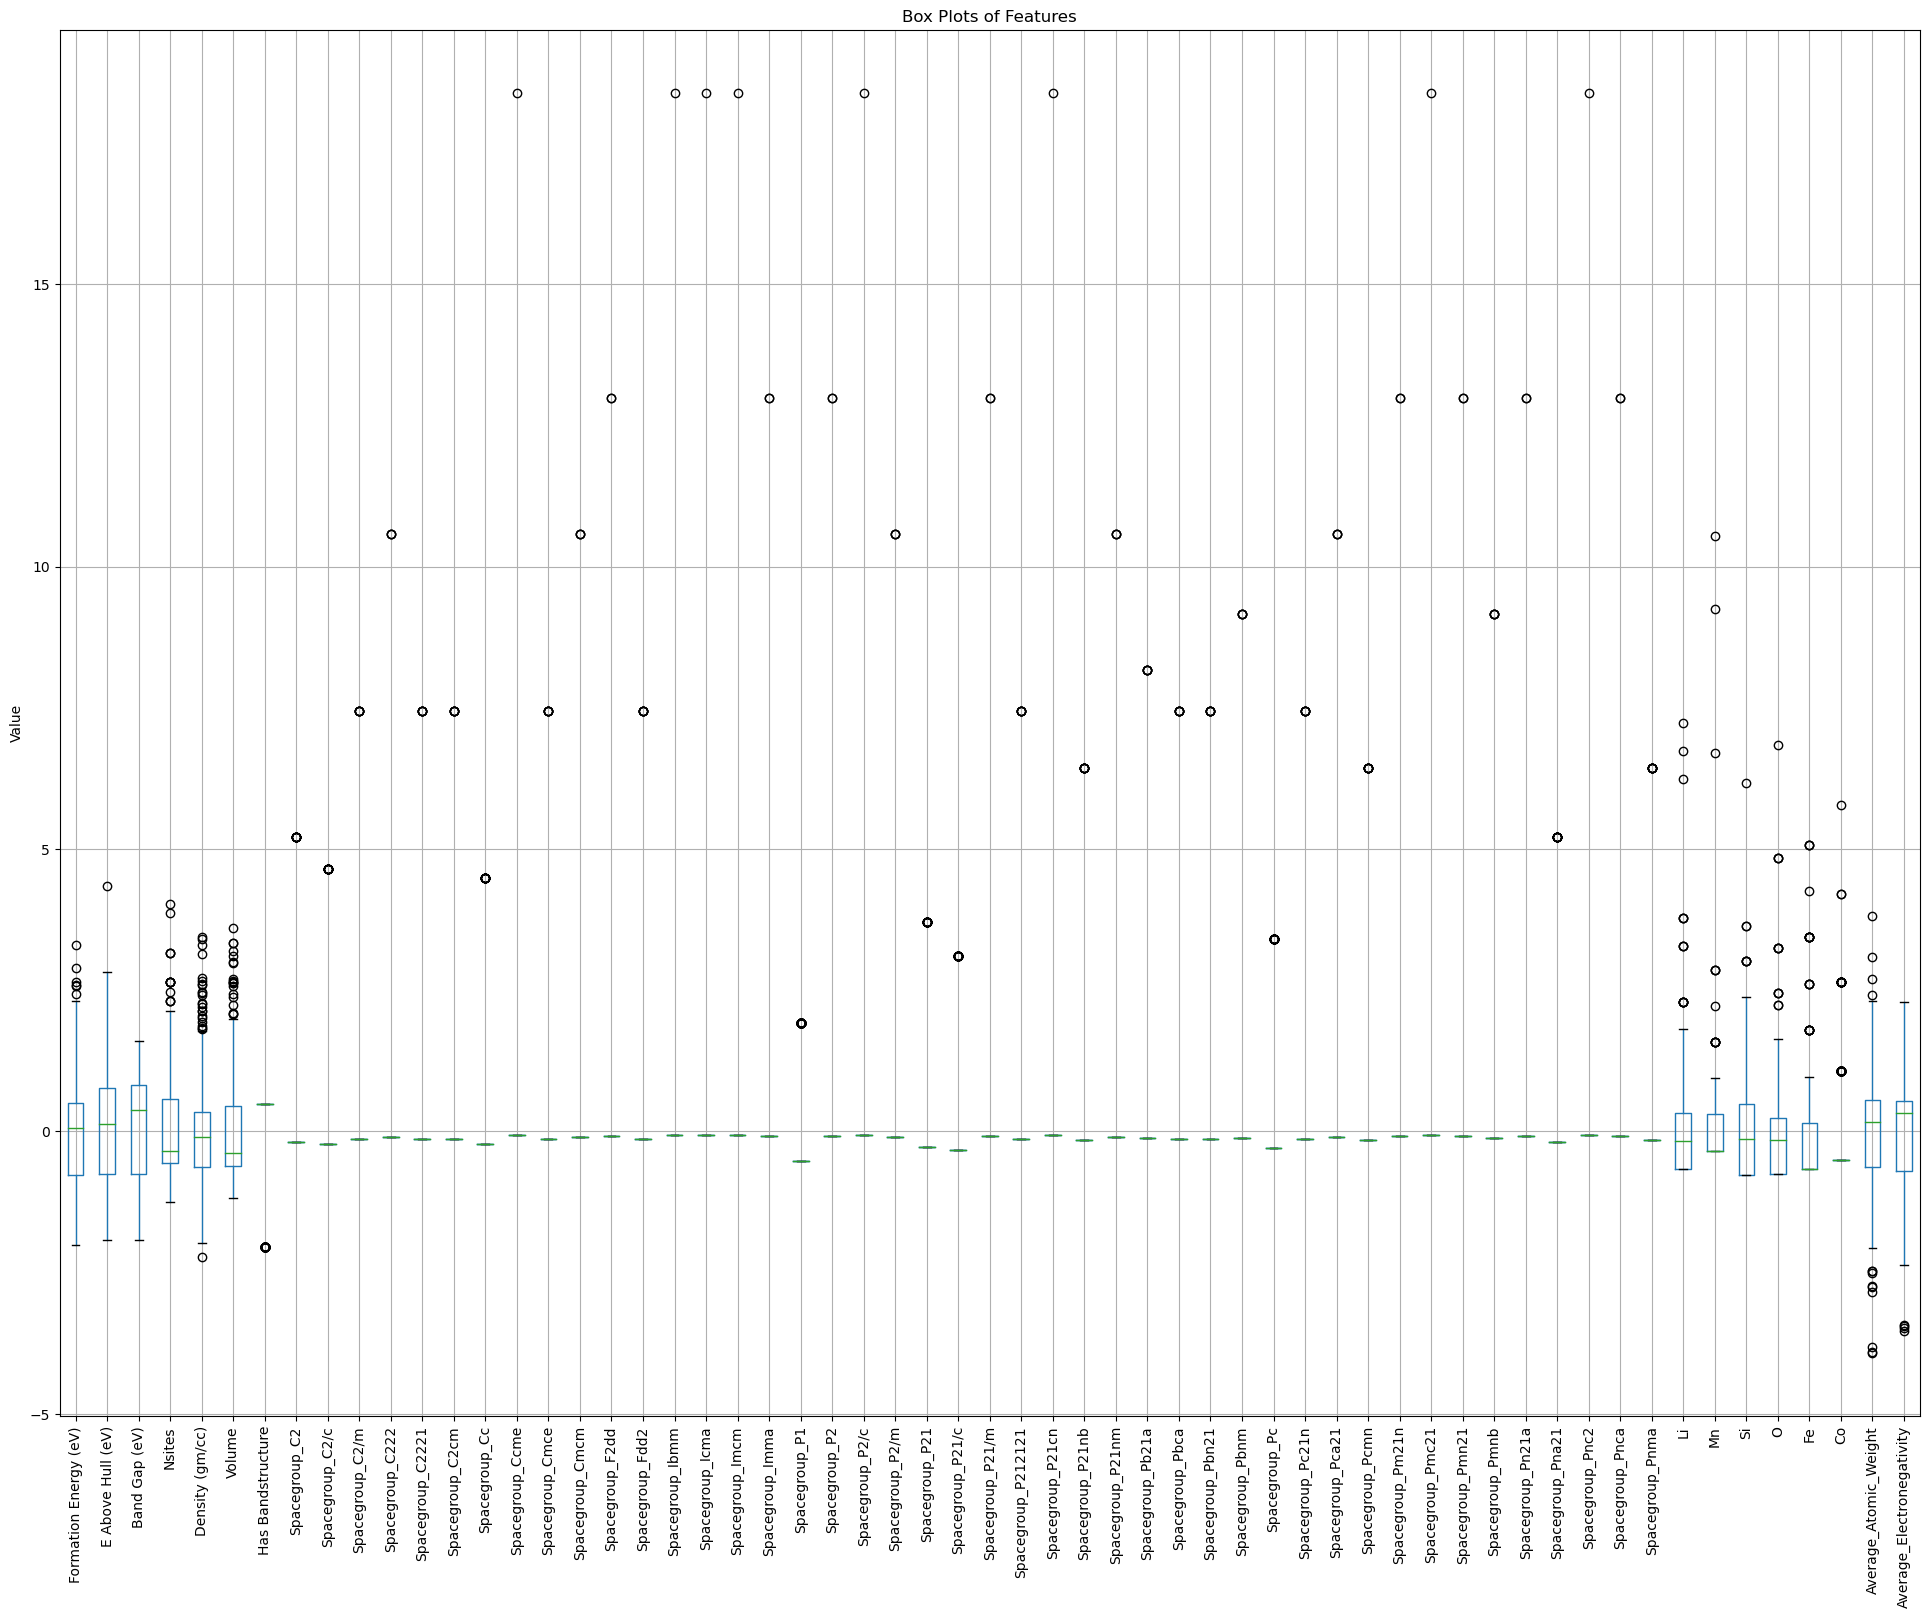

In [141]:
analyze_features(dataX)

## Sensitivity Analysis

In [142]:
# def plot_scatter_matrix(trainX, trainY):
#     # Combine input features and target variable into a single DataFrame
#     combined_data = pd.concat([trainX, trainY], axis=1)
    
#     # Create a scatter plot matrix
#     sns.pairplot(combined_data)
#     plt.show()

# def plot_residuals(trainX, trainY, model):
#     residuals = trainY - model.predict(trainX)
#     plt.scatter(trainX, residuals, color='blue')
#     plt.axhline(0, color='red')
#     plt.xlabel('Input Features')
#     plt.ylabel('Residuals')
#     plt.title('Residual Plot')
#     plt.show()

# def plot_qq(trainX, trainY, model):
#     residuals = trainY - model.predict(trainX)
#     stats.probplot(residuals.flatten(), dist='norm', plot=plt)
#     plt.title('Q-Q Plot of Residuals')
#     plt.show()

In [143]:
# # Load your data
# dataX_sensitivity = dataX.copy()
# dataY_sensitivity = dataY_encoded_df.copy()

# # Train a linear regression model as an example
# model = LinearRegression()
# model.fit(dataX_sensitivity, dataY_sensitivity)

# # Visualize the linearity using scatter plot matrix
# plot_scatter_matrix(dataX_sensitivity, dataY_sensitivity)

In [144]:
# Visualize the homoscedasticity using residuals plot
# plot_residuals(dataX_sensitivity, dataY_sensitivity, model)

In [145]:
# Visualize the normality of residuals using a Q-Q plot
# plot_qq(dataX_sensitivity, dataY_sensitivity, model)

## Feature Selection

### Preparing the Dataset for Model

In [146]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY_encoded_df, test_size=0.2,
random_state=2020, stratify=dataY_encoded_df)

#### Recursive feature elimination with cross-validation

    FECV can be a good option to determine the optimal number of features by recursively removing features and evaluating the model performance using cross-validation. Once we have the optimal number of features, we can use another feature selection method to select the top features.

    https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

Optimal number of features: 11
Selected features RFECV: ['Spacegroup_C2', 'Spacegroup_C2/c', 'Spacegroup_C2/m', 'Spacegroup_Cc', 'Spacegroup_P1', 'Spacegroup_P2', 'Spacegroup_P2/m', 'Spacegroup_P21', 'Spacegroup_P21/c', 'Spacegroup_Pc', 'Si']
Best CV score: 0.9926599326599327


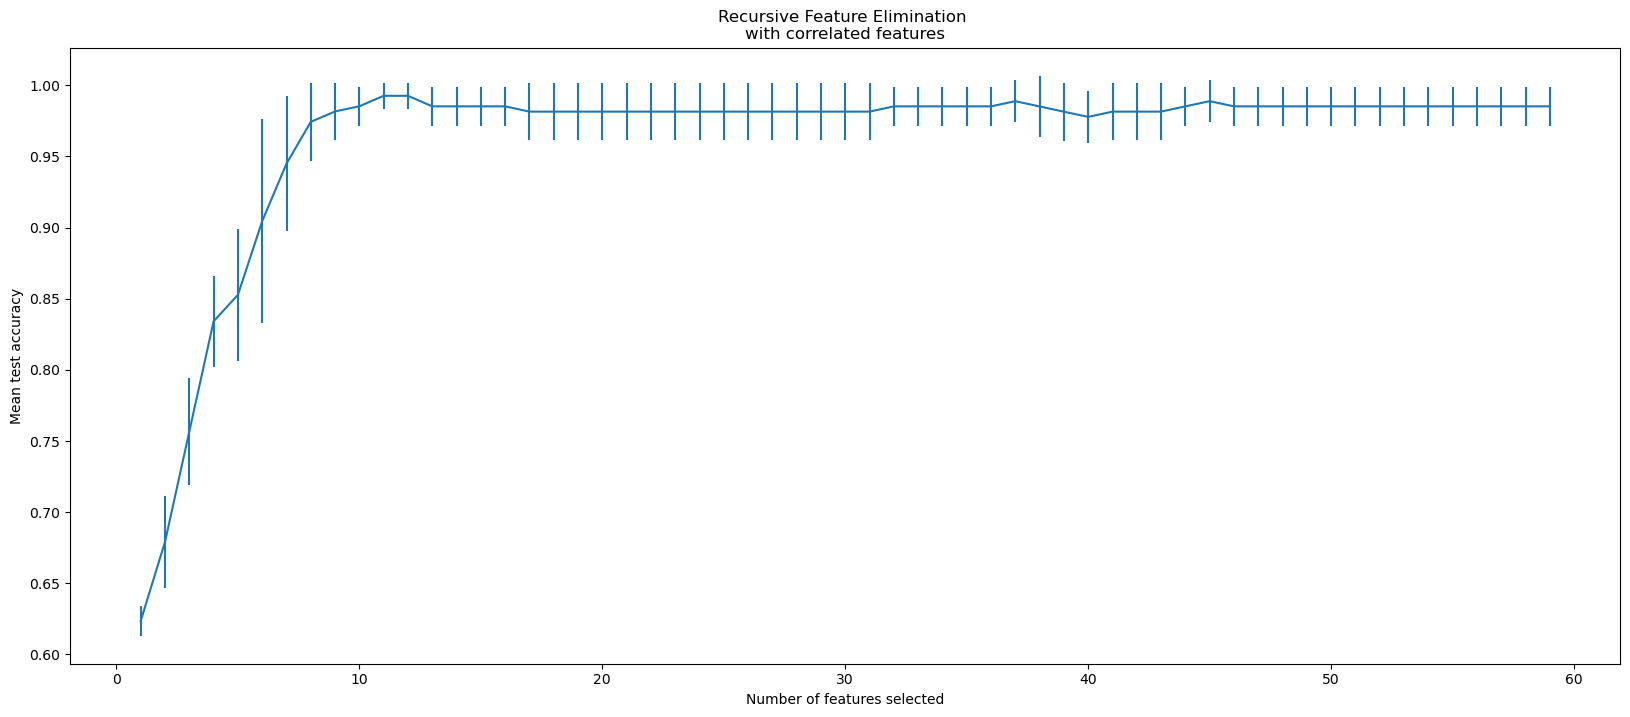

In [147]:
# Set the minimum number of features to consider and create the Logistic Regression classifier
min_features_to_select = 1
clf = LogisticRegression()

# Create a StratifiedKFold cross-validator with 5 folds
cv = StratifiedKFold(5)

# Convert the column vector y_train to a 1D array using ravel()
y_train_1d = y_train.values.ravel()

# Initialize the RFECV object with the classifier, cross-validator, scoring metric, and other parameters
rfecv = RFECV(
# The classifier ('clf') is used to estimate feature importance, which is essential for the RFE process. 
# Feature importance can be determined through either a 'coef_' attribute (linear models) or a 
# 'feature_importances_' attribute (tree-based models). After each iteration, when some features are eliminated, 
# the classifier is refitted on the remaining features to update the importance scores and guide the next round of feature elimination.
estimator=clf,
step=1, # The number of features to remove at each iteration; here, we remove one feature at a time
cv=cv, # The cross-validation strategy used to evaluate the model performance; in our case, it's StratifiedKFold with 5 folds
scoring="accuracy", # The performance metric used for model evaluation; here, we use classification accuracy
min_features_to_select=min_features_to_select, # The minimum number of features to consider during feature elimination; here, we set it to 1
n_jobs=2, # The number of CPU cores used for parallel computation; setting it to 2 means using two cores for faster processing
)

# Fit the RFECV object to the training data
rfecv.fit(X_train, y_train_1d)

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Get the boolean mask for the selected features
selected_features_mask = rfecv.support_

# Get the names of the selected features
selected_features_RFECV = X_train.columns[selected_features_mask]

# Print the selected features
print(f"Selected features RFECV: {selected_features_RFECV.tolist()}")

# Get the best CV score
best_cv_score = max(rfecv.cv_results_["mean_test_score"])

# Print the best CV score
print(f"Best CV score: {best_cv_score}")

# Create a new figure with the specified size
plt.figure(figsize=(20, 8))

# Set the labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")

# Plot the cross-validation scores with error bars
plt.errorbar(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)

# Set the title for the plot
plt.title("Recursive Feature Elimination \nwith correlated features")

# Display the plot
plt.show()

##### Note I:

    Recursive Feature Elimination with Cross-Validation (RFECV) is a feature selection method that combines the power of Recursive Feature Elimination (RFE) with the robustness of cross-validation to determine the optimal number of features for a given classification or regression problem. The aim of feature selection is to identify the most informative features and remove irrelevant or redundant ones, which can improve the model's performance, interpretability, and generalization ability while reducing computational complexity.

    RFE is a greedy search algorithm that works by recursively removing the least important features and refitting the model. At each iteration, the algorithm estimates the importance of each feature by fitting the model and calculating feature importances, which can be derived from the model's coefficients, weights, or other internal attributes. Then, the algorithm eliminates the least important feature and repeats the process until all features are ranked. The rationale behind RFE is that a reduced set of informative features can lead to a more accurate and simpler model.

    Cross-validation is a technique used to assess the model's performance on unseen data. It involves splitting the dataset into k equally sized subsets, or folds. The model is trained on k-1 folds and validated on the remaining one. This process is repeated k times, with each fold serving as the validation set once. The cross-validation scores are then averaged to provide a more reliable estimate of the model's performance.

    RFECV combines the strengths of RFE and cross-validation by searching for the optimal number of features that yield the best cross-validated performance. In each RFE iteration, RFECV performs cross-validation and calculates the average score for the current feature set. It then eliminates the least important feature and repeats the process, keeping track of the cross-validation scores. The optimal number of features is determined when the cross-validation score reaches its maximum.

    The term "Recursive Feature Elimination with correlated features" refers to the application of RFECV in the presence of correlated features. Correlated features can impact the selection process because they carry similar information and their importance may be distributed among them, making it challenging to distinguish between truly informative features and their correlated counterparts. In such cases, the optimal feature set may include redundant features, but their joint presence does not harm the model's performance. RFECV can help mitigate this issue by considering the cross-validation scores and selecting the optimal number of features that lead to the best generalization performance.

    In summary, RFECV is a powerful feature selection method that leverages the strengths of RFE and cross-validation to determine the optimal number of features for a given problem. It accounts for the presence of correlated features by relying on cross-validation scores and provides a reliable estimate of the model's performance on unseen data.

#### Feature Selection with multiple models

In [148]:
# # 1. Correlation Matrix
# # Adjust the threshold of the correlation function
# def correlation_matrix_n(X_train, y_train, n):
#     # Combine X_train and y_train DataFrames
#     combined_data = pd.concat([X_train, y_train], axis=1)

#     # Calculate the correlation between each feature and the target variable
#     corr = combined_data.corr().iloc[:-1, -1]

#     # Get the absolute correlation values
#     corr_abs = corr.abs()

#     # Sort the features by their absolute correlation values (descending order)
#     corr_sorted = corr_abs.sort_values(ascending=False)

#     # Select the top n features
#     top_n_features = corr_sorted.head(n).index.tolist()

#     return top_n_features


# def plot_most_correlated_eu(X_train, most_correlated_list, fig_size=(20, 8)):
#     """
#     Plot a correlation matrix for the most correlated columns in a Pandas DataFrame.

#     Parameters:
#     X_train (pandas.DataFrame): The input DataFrame containing the columns to plot.
#     most_correlated_list (list): A list of column names to include in the correlation matrix.
#     fig_size (tuple): The size of the figure in inches (default: (8, 6)).

#     Returns:
#     None
#     """
#     # Split list of most correlated variables into sublists of length 20
#     sublists = [most_correlated_list[i:i+10] for i in range(0, len(most_correlated_list), 10)]

#     # Plot correlation matrix for each sublist of variables
#     for i, sublist in enumerate(sublists):
#         fig_title = f"Most Correlated Variables {i+1}-{i+len(sublist)} - EU"
#         df = X_train[sublist]
#         corr = df.corr()
#         print(f"Correlation matrix for {fig_title}:")
#         fig, ax = plt.subplots(figsize=fig_size)
#         sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
#         ax.set_title(f'Correlation Matrix - {fig_title}')

#         plt.show()

# # 2. Univariate Feature Selection F-Regression
# def univariate_feature_selection_f_regression(X_train, y_train, k, score_func=f_regression):
#     selector = SelectKBest(score_func=score_func, k=k)
#     selector.fit(X_train, y_train)

#     scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
#     scores.sort_values(by='Score', ascending=False, inplace=True)

#     plt.figure(figsize=(20, 8))
#     sns.barplot(x='Feature', y='Score', data=scores)
#     plt.xticks(rotation=90)
#     plt.title('Univariate Feature Selection - F-Regression Scores')
#     plt.show()

#     # Filter the top k features
#     top_k_features = scores['Feature'].head(k).tolist()
#     print(f"Number of selected features by F-Regression: {len(top_k_features)}")
#     print(f"Features selected by F-Regression: {top_k_features}")
#     return top_k_features


# # 3. Univariate Feature Selection Mutual Information
# def univariate_feature_selection_mutual_information(X_train, y_train, k, score_func=f_regression):
#     selector = SelectKBest(score_func=score_func, k=k)
#     selector.fit(X_train, y_train)

#     scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
#     scores.sort_values(by='Score', ascending=False, inplace=True)

#     plt.figure(figsize=(20, 8))
#     sns.barplot(x='Feature', y='Score', data=scores)
#     plt.xticks(rotation=90)
#     plt.title('Univariate Feature Selection Scores - Mutual Information')
#     plt.show()

#     # Filter the top k features
#     top_k_features = scores['Feature'].head(k).tolist()
#     print(f"Number of selected features by Mutual Information: {len(top_k_features)}")
#     print(f"Features selected by Mutual Information: {top_k_features}")
#     return top_k_features


# # 3. Lasso (L1 Regularization)
# def lasso_feature_selection(X_train, y_train, n):
#     lasso = LassoCV(cv=5, random_state=42, max_iter=10000, tol=1e-4)
#     lasso.fit(X_train, y_train.values.ravel())

#     coef = pd.Series(lasso.coef_, index=X_train.columns)
    
#     # Sort the coefficients based on their absolute values and select the top n features
#     top_n_features = coef.abs().sort_values(ascending=False).head(n).index.tolist()
    
#     plt.figure(figsize=(20, 8))
#     sns.barplot(x=coef.index, y=coef.values)
#     plt.xticks(rotation=90)
#     plt.title('Lasso Feature Importance')
#     plt.show()
#     print(f"Number of selected features by Lasso (L1 Regularization): {len(top_n_features)}")
#     print(f"Top {n} features selected by Lasso (L1 Regularization): {top_n_features}")

#     return top_n_features


# # 4. Ridge (L2 Regularization)
# def ridge_feature_selection(X_train, y_train, top_k):
#     ridge = RidgeCV(cv=5)
#     ridge.fit(X_train, y_train)

#     coef = pd.Series(ridge.coef_.reshape(-1), index=X_train.columns)
#     coef_sorted = coef.abs().sort_values(ascending=False)

#     plt.figure(figsize=(20, 8))
#     sns.barplot(x=coef_sorted.index, y=coef_sorted.values)
#     plt.xticks(rotation=90)
#     plt.title('Ridge Feature Importance')
#     plt.show()

#     # Print the number of selected features and their length
#     num_selected_features = len(coef_sorted[:top_k])
#     print(f"Number of selected features by Ridge (L2 Regularization): {num_selected_features}")
#     print(f"Top {top_k} selected features based on Ridge (L2 Regularization) : ")
#     print(coef_sorted[:top_k].index.tolist())

#     return coef_sorted[:top_k]

# # 5. Random Forest Importance
# def random_forest_feature_importance(X_train, y_train, top_k):
#     rf = RandomForestRegressor(random_state=42)
#     rf.fit(X_train, y_train)

#     importance = pd.Series(rf.feature_importances_, index=X_train.columns)
#     importance.sort_values(ascending=False, inplace=True)

#     # Select the top K features
#     top_k_importance = importance[:top_k]

#     plt.figure(figsize=(20, 8))
#     sns.barplot(x=importance.index, y=importance.values)
#     plt.xticks(rotation=90)
#     plt.title(f'Random Forest Feature Importance')
#     plt.show()
#     print(f"Number of selected features by Random Forest Importance: {len(top_k_importance)}")
#     print(f"Features selected by Random Forest Importance: {top_k_importance.index.tolist()}")
#     print('--------------------------------------------------------------')

#     return top_k_importance.index.tolist()

# warnings.filterwarnings('ignore')

# def perform_cross_validation(selected_features):
#     # Define the models to train
#     models = {
#         'Linear Regression': LinearRegression(),
#         'Decision Tree': DecisionTreeRegressor(random_state=42),
#         'Random Forest': RandomForestRegressor(random_state=42),
#         'Gradient Boosting': GradientBoostingRegressor(random_state=42),
#         'Support Vector': SVR(),
#         'Ridge Regression': Ridge(),
#         'Lasso Regression': Lasso(),
#         'Elastic Net Regression': ElasticNet(),
#         'K-Nearest Neighbors': KNeighborsRegressor(),
#         'MLP Regressor': MLPRegressor(random_state=42)
#     }

#     # Perform cross-validation with all and selected features for each model
#     results_all_features = []
#     results_selected_features = []
#     for name, model in models.items():
#         # Cross-validation score with all features
#         all_features_score = np.mean(cross_val_score(model, X_train, y_train.values.ravel(), cv=5))

#         # Cross-validation score with selected features
#         selected_features_score = np.mean(cross_val_score(model, X_train[selected_features], y_train.values.ravel(), cv=5)) # The values.ravel() is used to convert a 2D array or DataFrame into a 1D NumPy array, which is the format scikit-learn models typically expect for target variables. 

#         # # Print the results
#         # print(name)
#         # print("Cross-validation score with all features:", all_features_score)
#         # print("Cross-validation score with selected features:", selected_features_score)
#         # print('--------------------------------------------------------------')

#         results_all_features.append(all_features_score)
#         results_selected_features.append(selected_features_score)

#     # Print average score
#     print('Average cross-validation score across all models with all features_score:', np.mean(results_all_features))
#     print('Average cross-validation score across all models with selected_features_score:', np.mean(results_selected_features))
#     print('--------------------------------------------------------------')

# # Call the feature selection methods and store them in a list
# feature_selection_methods = [
#     ('Highly Correlated Features', correlation_matrix_n(X_train, y_train, n=9)),
#     ('Top K Features - F-Regression', univariate_feature_selection_f_regression(X_train, y_train, k=9, score_func=f_regression)),
#     ('Top K Features - Mutual Information', univariate_feature_selection_mutual_information(X_train, y_train, k=9, score_func=mutual_info_regression)),
#     ('Ridge Feature Selection', ridge_feature_selection(X_train, y_train, top_k=9).index),
#     ('Random Forest Feature Importance', random_forest_feature_importance(X_train, y_train, top_k=9)),
#     ('Lasso Feature Selection', lasso_feature_selection(X_train, y_train, n=9))
# ]

# # Loop through the feature selection methods and perform cross-validation for each method
# for method_name, selected_features in feature_selection_methods:
#     print(f"Performing cross-validation with {method_name}:")
#     perform_cross_validation(selected_features)

#     if method_name == 'Highly Correlated Features':
#         plot_most_correlated_eu(pd.concat([X_train, y_train], axis=1), selected_features)

### Prepare the dataset for the model with selected features

In [149]:
# Use the list of selected features to create the new dataframes
X_train_selected = X_train[selected_features_RFECV]
X_test_selected = X_test[selected_features_RFECV]

In [150]:
X_train_selected.head()

Spacegroup_C2  Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_Cc   
6        -0.191565        -0.215166        -0.134231      -0.222566  \
161      -0.191565        -0.215166        -0.134231      -0.222566   
323      -0.191565        -0.215166        -0.134231      -0.222566   
64       -0.191565         4.647580        -0.134231      -0.222566   
4        -0.191565         4.647580        -0.134231      -0.222566   

     Spacegroup_P1  Spacegroup_P2  Spacegroup_P2/m  Spacegroup_P21   
6        -0.519291      -0.077037        -0.094491        3.706633  \
161      -0.519291      -0.077037        -0.094491       -0.269787   
323       1.925703      -0.077037        -0.094491       -0.269787   
64       -0.519291      -0.077037        -0.094491       -0.269787   
4        -0.519291      -0.077037        -0.094491       -0.269787   

     Spacegroup_P21/c  Spacegroup_Pc        Si  
6           -0.322854      -0.294174 -0.769251  
161         -0.322854      -0.294174  1.120431  
323         -0.322854      -0.294174 -0.769251  
64          -0.322854      -0.294174 -0.139357  
4           -0.322854      -0.294174  0.490537

In [151]:
X_test_selected.head()

Spacegroup_C2  Spacegroup_C2/c  Spacegroup_C2/m  Spacegroup_Cc   
62       -0.191565        -0.215166        -0.134231      -0.222566  \
130      -0.191565        -0.215166        -0.134231      -0.222566   
8        -0.191565         4.647580        -0.134231      -0.222566   
143      -0.191565        -0.215166        -0.134231      -0.222566   
334      -0.191565        -0.215166        -0.134231      -0.222566   

     Spacegroup_P1  Spacegroup_P2  Spacegroup_P2/m  Spacegroup_P21   
62       -0.519291      -0.077037        -0.094491       -0.269787  \
130      -0.519291      -0.077037        -0.094491       -0.269787   
8        -0.519291      -0.077037        -0.094491       -0.269787   
143      -0.519291      -0.077037        -0.094491       -0.269787   
334       1.925703      -0.077037        -0.094491       -0.269787   

     Spacegroup_P21/c  Spacegroup_Pc        Si  
62           3.097378      -0.294174 -0.139357  
130         -0.322854      -0.294174  1.120431  
8           -0.322854      -0.294174 -0.139357  
143         -0.322854      -0.294174 -0.769251  
334         -0.322854      -0.294174 -0.139357

In [152]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

# Measure of Loss/Success

In [186]:
# Function to plot training and cross-validation errors
def plot_cv_error(model, train_errors, cv_errors, error_label):
    fig, ax = plt.subplots()
    ax.plot(train_errors, label=f'Train {error_label}')
    ax.plot(cv_errors, label=f'CV {error_label}')
    ax.legend()
    plt.xlabel('Fold')
    plt.ylabel('Error')
    plt.title(f'Model Training and CV {error_label}s')
    plt.show()

def get_f1_score(model, X, y):
    y_preds = model.predict(X)
    f1 = f1_score(y, y_preds, average='weighted')
    return f1

# Function to plot the confusion matrix
def plot_confusion_matrix(model, X, y, cmap='Blues'):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_preds = model.predict(X)
    cm = confusion_matrix(y, y_preds)
    print('The value count of the true values of the confusion matrix are :', y.value_counts())
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot(cmap=cmap)
    plt.show()

def get_f1_score_nn(model, X, y):
    y_preds = model.predict(X)
    y_preds_labels = np.argmax(y_preds, axis=1)
    f1 = f1_score(y, y_preds_labels, average='weighted')
    return f1

def plot_confusion_matrix_nn(model, X, y, cmap='Blues'):
    y_preds = model.predict(X)
    y_preds_labels = np.argmax(y_preds, axis=1)
    cm = confusion_matrix(y, y_preds_labels)
    print('The value count of the true values of the confusion matrix are :', y.value_counts())
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot(cmap=cmap)
    plt.show()

# Function to plot the precision-recall curve
def plot_precision_recall_curve(y_true, y_pred):
    from sklearn.metrics import precision_recall_curve, average_precision_score

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
    plt.show()

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_pred):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve_multi_class(y_true, y_pred_prob, n_classes, title):
    # Binarize the true labels using label_binarize.
    # This creates a binary matrix where each row represents a sample and each column represents a class.
    # A 1 in a cell means that the sample belongs to that class.
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

    precision = dict()
    recall = dict()
    average_precision = dict()

    # Loop through each class and calculate the precision and recall curves using precision_recall_curve function. 
    # Also, calculate the average precision for each class using average_precision_score function.
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_prob[:, i])

    # A "micro-average": quantifying score on all classes jointly
    # Calculate the micro-average precision and recall curves by flattening the binarized true labels and predicted probabilities. 
    # This aggregates the contributions of all classes to compute the overall precision and recall.
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
    # Calculate the micro-average precision score using average_precision_score with the average parameter set to "micro".
    average_precision["micro"] = average_precision_score(y_true_binarized, y_pred_prob, average="micro")

    plt.figure(figsize=(10, 6))
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.7, where='post', linewidth=2)
    plt.fill_between(recall['micro'], precision['micro'], step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve, micro-averaged over all classes ({title}): AP={average_precision["micro"]:.2f}')
    plt.show()

def plot_roc_curve_multi_class(y_true, y_pred_prob, n_classes, title):
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr["micro"], tpr["micro"], color='b', alpha=0.7, label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linewidth=2)
    plt.fill_between(fpr["micro"], tpr["micro"], alpha=0.3, color='b')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic curve, micro-averaged over all classes ({title})')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)  # Use predicted probabilities
    test_loss = log_loss(y_test, y_pred_test_prob)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"{model_name} Model Performance:")
    print(f"Test Log Loss (dimensionless): {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

# Modify the evaluate_model function to handle the neural network model
def evaluate_model_with_nn(model_instance, X_test, y_test, model_name):
    if isinstance(model_instance, Sequential):  # Check if it's the neural network model
        y_pred_proba = model_instance.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        test_loss = log_loss(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)
    else:
        test_loss = log_loss(y_test, model_instance.predict_proba(X_test))
        test_accuracy = model_instance.score(X_test, y_test)

    print(f"{model_name} Log Loss: {test_loss:.4f}")
    print(f"{model_name} Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

def evaluate_and_plot_test_data(X_test, y_test, model, title):
    # Calculate the F1-score
    test_f1_score = get_f1_score(model, X_test, y_test)
    print("Test F1-score: {:.4f}".format(test_f1_score))

    # Plot the confusion matrix
    plot_confusion_matrix(model, X_test, y_test)

    n_classes = len(np.unique(y_test))

    # Get the predicted probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)

    # If it's a binary classification problem, plot the precision-recall and ROC curves
    if n_classes == 2:
        y_pred_proba_binary = y_pred_proba[:, 1]
        plot_precision_recall_curve(y_test, y_pred_proba_binary)
        plot_roc_curve(y_test, y_pred_proba_binary)
    else:
        # Plot the multi-class precision-recall curve
        plot_precision_recall_curve_multi_class(y_test, y_pred_proba, n_classes, title)

        # Plot the multi-class ROC curve
        plot_roc_curve_multi_class(y_test, y_pred_proba, n_classes, title)

# Replace the 'plot_confusion_matrix' function call in the 'evaluate_and_plot_test_data_nn' function with the new 'plot_confusion_matrix_nn' function
def evaluate_and_plot_test_data_nn(X_test, y_test, model, title):
    # Calculate the F1-score
    test_f1_score = get_f1_score_nn(model, X_test, y_test)
    print("Test F1-score: {:.4f}".format(test_f1_score))

    # Plot the confusion matrix
    plot_confusion_matrix_nn(model, X_test, y_test)

    n_classes = len(np.unique(y_test))

    # Get the predicted probabilities for the test set
    y_pred_test_prob = model.predict(X_test)
    y_pred_test = np.argmax(y_pred_test_prob, axis=-1)  # Get class labels

    test_loss = log_loss(y_test, y_pred_test_prob)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print(f"{title} Log Loss: {test_loss:.4f}")

    # If it's a binary classification problem, plot the precision-recall and ROC curves
    if n_classes == 2:
        y_pred_proba_binary = y_pred_test_prob[:, 1]
        plot_precision_recall_curve(y_test, y_pred_proba_binary)
        plot_roc_curve(y_test, y_pred_proba_binary)
    else:
        # Plot the multi-class precision-recall curve
        plot_precision_recall_curve_multi_class(y_test, y_pred_test_prob, n_classes, title)

        # Plot the multi-class ROC curve
        plot_roc_curve_multi_class(y_test, y_pred_test_prob, n_classes, title)


# Define a function to fit the models (modified to include the neural network model)
def fit_models_with_nn(X_train, y_train, model_instances):
    for model_instance in model_instances:
        if isinstance(model_instance, Sequential):  # Check if it's the neural network model
            model_instance.fit(
                X_train,
                y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                verbose=0  # Set verbose to 0 to suppress training output
            )
        else:
            y_train_1d = y_train.values.ravel()
            model_instance.fit(X_train, y_train_1d)

# Testing Phase I: Baseline Models

## Logistic Regression

    Logistic regression is a probabilistic discriminative model that can be extended to handle multi-class problems using the One-vs-Rest (OvR) or Softmax strategies. In OvR, a separate logistic regression model is trained for each class, treating it as the positive class and the rest as negative. In Softmax, logistic regression is generalized to handle multiple classes directly. In our model, by default, Logistic Regression from scikit-learn uses the One-vs-Rest (OvR) strategy for multi-class classification. If we want to use the Softmax strategy, we can set the multi_class parameter to "multinomial" and use a solver that supports it, like "lbfgs" or "saga".
    
    For multiclass classification problems like the one we are dealing with, suitable loss functions include cross-entropy loss, also known as logarithmic loss, and Kullback-Leibler divergence. These loss functions measure the difference between the predicted probabilities for each class and the true class labels, and they are commonly used in neural networks and other probabilistic classification models. Another option is the hinge loss, which is used in multiclass Support Vector Machines (SVMs). It measures the margin between the true class and the highest-scoring incorrect class, encouraging the model to increase the margin between classes.

    The units of measure for avg_train_logloss and avg_cv_logloss are not traditional units like meters or seconds. Instead, they represent the logarithm of the likelihood of the true labels given the predicted probabilities, averaged over all data points. In this case, log loss uses the natural logarithm, and the values are dimensionless.

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

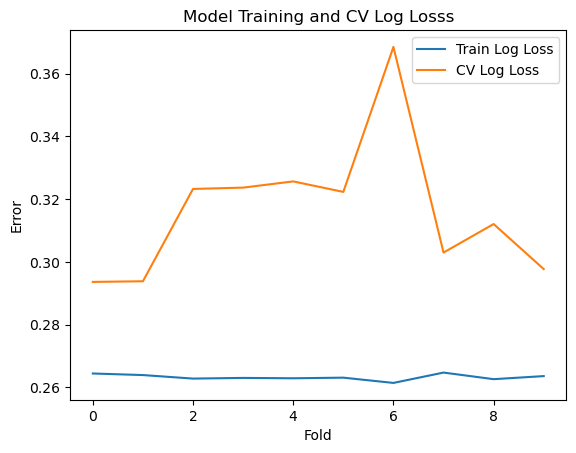

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


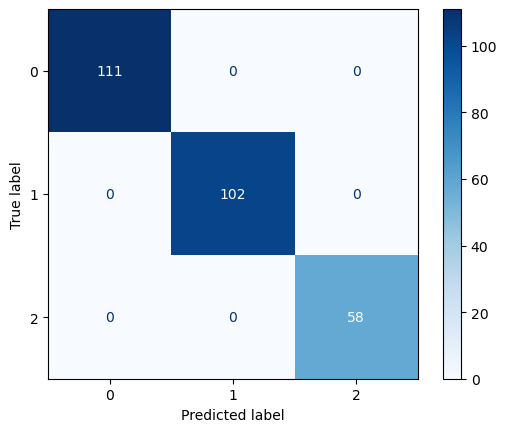

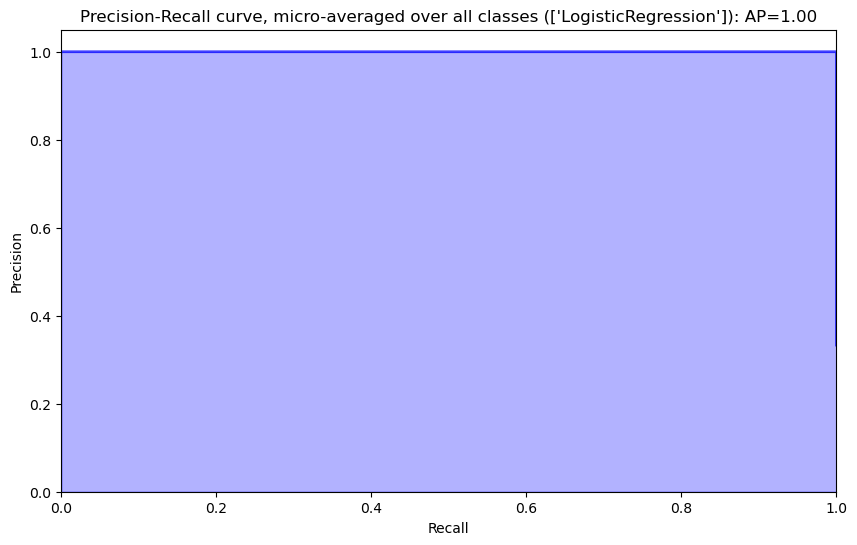

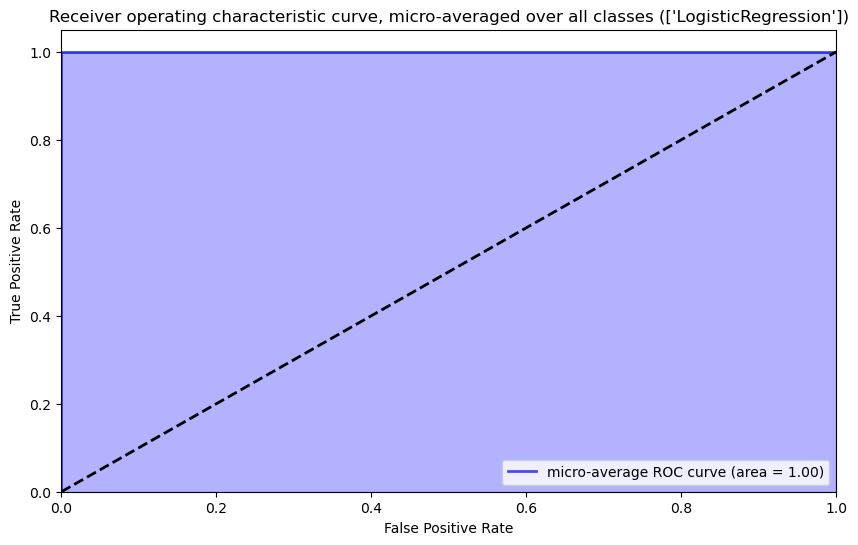

In [154]:
def train_logreg_model(X_train, y_train, model_params, n_splits=10, random_states=[42]):

    # Initialize lists to store training and CV losses for all random states
    train_losses_all = []
    cv_losses_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        # Update the model_params with the current random_state
        model_params["random_state"] = random_state

        # Define the model with the current random_state
        model = LogisticRegression(**model_params)

        # Perform StratifiedKFold CV with 5 splits
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        # Initialize lists to store training and CV losses
        train_losses = []
        cv_losses = []

        # Convert the column vector y_train to a 1D array using ravel()
        y_train_1d = y_train.values.ravel()
        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train_1d[train_index], y_train_1d[cv_index]

            # Train the model
            model.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the training set
            y_pred_train_prob = model.predict_proba(X_train_fold)
            logloss_train = log_loss(y_train_fold, y_pred_train_prob)
            train_losses.append(logloss_train)

            # Evaluate the model on the CV set
            y_pred_cv_prob = model.predict_proba(X_cv_fold)
            logloss_cv = log_loss(y_cv_fold, y_pred_cv_prob)
            cv_losses.append(logloss_cv)

            # Printing the results for the current fold
            print('Training Log Loss: ', logloss_train)
            print('CV Log Loss: ', logloss_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)

    # Calculate the mean training and CV losses for all random states
    avg_train_logloss = np.mean(train_losses_all)
    avg_cv_logloss = np.mean(cv_losses_all)

    # Print the mean training and CV losses
    print("Mean Train Log Loss (dimensionless): {:.4f}, Mean CV Log Loss (dimensionless): {:.4f}".format(avg_train_logloss, avg_cv_logloss))

    return model, train_losses_all, cv_losses_all

# Default paramters 
model_params_log_reg = {
    "penalty": "l2",
    "dual": False,
    "tol": 1e-4,
    "C": 1.0,
    "fit_intercept": True,
    "intercept_scaling": 1,
    "class_weight": None,
    "random_state": None,
    "solver": "lbfgs",
    "max_iter": 100,
    "multi_class": "auto",
    "verbose": 0,
    "warm_start": False,
    "n_jobs": None,
    "l1_ratio": None,
}

# Define model parameters for logistic regression with One-vs-Rest (OvR) (separate logistic regression model is trained for each class)
model_params_log_reg = {
    "penalty": "l2",  # The type of regularization to be applied ("l1", "l2", "elasticnet", or "none")
    "C": 0.05,  # The inverse of regularization strength; smaller values specify stronger regularization
    "solver": "liblinear",  # Algorithm used for optimization (options: "newton-cg", "lbfgs", "liblinear", "sag", "saga")
    "multi_class": "ovr",  # Strategy for handling multiple classes, "ovr" for One-vs-Rest, "multinomial" for Softmax
    "random_state": 2021,  # The random seed for reproducibility
}

# # Define model parameters for logistic regression with Softmax (logistic regression is generalized to handle multiple classes directly)
# model_params_log_reg = {
#     "penalty": "l2",  # The type of regularization to be applied ("l1", "l2", "elasticnet", or "none")
#     "C": 1.0,  # The inverse of regularization strength; smaller values specify stronger regularization
#     "solver": "lbfgs",  # Algorithm used for optimization (options: "newton-cg", "lbfgs", "liblinear", "sag", "saga")
#     "multi_class": "multinomial",  # Strategy for handling multiple classes, "ovr" for One-vs-Rest, "multinomial" for Softmax
#     "random_state": 2021,  # The random seed for reproducibility
# }

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_name = ['LogisticRegression']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

### Note I:

    1. StratifiedKFold is a cross-validation technique used to evaluate a machine learning model's performance on a dataset. It ensures that each fold in the cross-validation process has the same proportion of class labels as the entire dataset. This is especially important when working with imbalanced datasets, as it helps maintain the class distribution in each fold, leading to a more accurate estimation of the model's performance. In the given example, a 5-fold StratifiedKFold is used, meaning that the dataset is divided into 5 equally sized, stratified folds. During the cross-validation process, the model is trained on 4 of these folds and validated on the remaining fold, and this process is repeated 5 times with different fold combinations.
    
    2. The threshold is not used in the evaluation metrics provided in your code. Thresholds are mainly used to determine the final class prediction in binary classification tasks when the predicted probabilities are provided by the model. If you want to use a threshold to get the final class prediction, you can use it with predict_proba output, but it's not necessary in this case, as the predict method directly provides class predictions.

    3. The accuracy_score is well implemented for classification tasks. It measures the proportion of correct predictions over the total number of predictions. It is a suitable metric for classification problems where the classes are balanced, but it may not be a good choice for imbalanced datasets, where other metrics like precision, recall, F1-score, or the area under the ROC curve might be more appropriate.

    4. Sequence that can help to interpret the results better:

        1. Train model and get the training and cross-validation errors.
        2. Plot the training and cross-validation errors.
        3. Evaluate the model performance on the test set (log loss and accuracy).
        4. Calculate the F1-score.
        5. Plot the confusion matrix.
        6. Plot the precision-recall curve (only for binary classification).
        7. Plot the ROC curve (only for binary classification).
        8. Plot the precision-recall curve (only for multi-class classification).
        9. Plot the ROC curve (only for multi-class classification).

    5. LabelEncoder is used to transform non-numerical labels into numerical labels, assigning an integer value to each class. In our preprocessing step, we used LabelEncoder to convert the target variable into numerical labels. This is an essential step for feeding the data into a machine learning model, as they generally require numerical input.
    On the other hand, label_binarize is used to binarize the labels in a one-vs-all fashion, which is needed for plotting precision-recall and ROC curves for multi-class classification. This step is separate from the preprocessing using LabelEncoder. Binarizing the labels creates a binary matrix where each column represents one class and has a 1 for the true label and 0 for the other classes. This is necessary for computing the precision, recall, and ROC curves for each class individually and for the micro-average.
    So, even though we have already used LabelEncoder in the preprocessing step, we still need to binarize the target variables using label_binarize for plotting the multi-class precision-recall and ROC curves. The plot_precision_recall_curve_multi_class and plot_roc_curve_multi_class functions handle this internally, so we don't need to perform this step manually before calling these functions.

    6.  In the case of three classes (0, 1, 2), the confusion matrix will be a 3x3 matrix:
    
    C00, C01, C02,
    C10, C11, C12,
    C20, C21, C22

    Here, Cij represents the count of samples that belong to class i but were predicted as class j. For example:

    C00: True Positives for class 0 (samples correctly classified as class 0)
    C11: True Positives for class 1 (samples correctly classified as class 1)
    C22: True Positives for class 2 (samples correctly classified as class 2)
    C01: Samples of class 0 incorrectly classified as class 1 (False Positives for class 1)
    C02: Samples of class 0 incorrectly classified as class 2 (False Positives for class 2)
    C10: Samples of class 1 incorrectly classified as class 0 (False Positives for class 0)
    C12: Samples of class 1 incorrectly classified as class 2 (False Positives for class 2)
    C20: Samples of class 2 incorrectly classified as class 0 (False Positives for class 0)
    C21: Samples of class 2 incorrectly classified as class 1 (False Positives for class 1)

## Stochastic Gradient Descent (SGD)

    Stochastic Gradient Descent (SGD) is an optimization algorithm commonly used in machine learning for training models, especially large-scale and high-dimensional datasets. It's an iterative method that updates the model's parameters by minimizing an objective function, such as the loss function. Unlike standard Gradient Descent, which computes the gradient using the entire dataset, SGD uses a random subset (mini-batch) of the data for each iteration, making it more computationally efficient. SGD is widely applied in various machine learning tasks, including linear regression, logistic regression, and neural networks. Despite its simplicity and efficiency, SGD can be sensitive to hyperparameters and may require careful tuning to achieve optimal performance.

    "loss": "modified_huber"
    Loss function to be used for training. In this case, "modified_huber" is chosen, which is a smooth loss function that is less sensitive to outliers and produces probability estimates.
    Other options include:
    "hinge": Linear Support Vector Machine (SVM) loss
    "log": Logistic Regression loss (probabilistic classifier)
    "squared_hinge": Quadratically penalized hinge loss
    "perceptron": Linear loss used by the perceptron algorithm
    Different loss functions can have different effects on the learning process, and some may be more suitable for specific problems or datasets.

    "penalty": "elasticnet"
    Regularization term applied to the loss function during optimization. "elasticnet" is a combination of L1 and L2 regularization, which helps prevent overfitting and encourages sparse solutions.
    Other options include:
    "l1": L1 regularization (Lasso)
    "l2": L2 regularization (Ridge)
    "none": No regularization applied
    The choice of regularization depends on the problem and dataset. L1 regularization promotes sparsity, while L2 regularization prevents overfitting without necessarily enforcing sparsity.

    "alpha": 0.0001
    Regularization constant that multiplies the regularization term. Higher values lead to stronger regularization.
    This value can be tuned using cross-validation to find the best trade-off between model complexity and generalization.

    "l1_ratio": 0.15
    The Elastic Net mixing parameter, with values between 0 and 1.
    l1_ratio=0 corresponds to L2 penalty (Ridge), l1_ratio=1 corresponds to L1 penalty (Lasso).
    This parameter controls the balance between L1 and L2 regularization in the elastic net penalty.

    "learning_rate": "optimal"
    Learning rate schedule for weight updates. "optimal" computes the learning rate using a specific formula, depending on the loss function and the regularization term.
    Other options include:
    "constant": Constant learning rate given by the "eta0" parameter
    "invscaling": Inverse scaling learning rate
    "adaptive": Adapts the learning rate based on the model's performance
    Different learning rate schedules may lead to different convergence rates and overall performance.

    "early_stopping": False
    Whether to stop training when the validation score is not improving. If set to True, it will use a fraction of the training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

    "validation_fraction": 0.05
    The proportion of training data used for validation when early_stopping is True. In this case, 5% of the training data will be used as validation data.
    "random_state": 2021
    Seed used by the random number generator for reproducibility. This ensures that the results can be replicated when using the same random state.

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

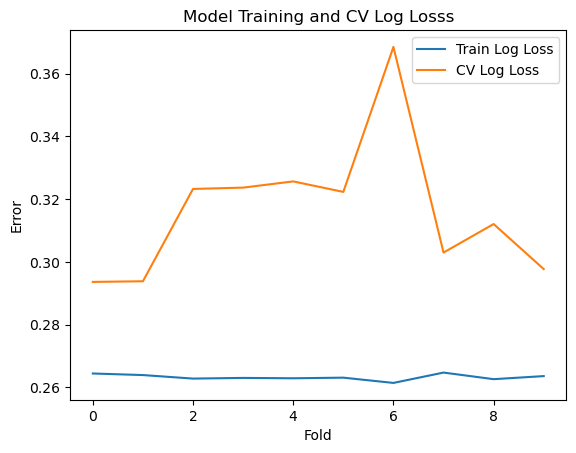

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


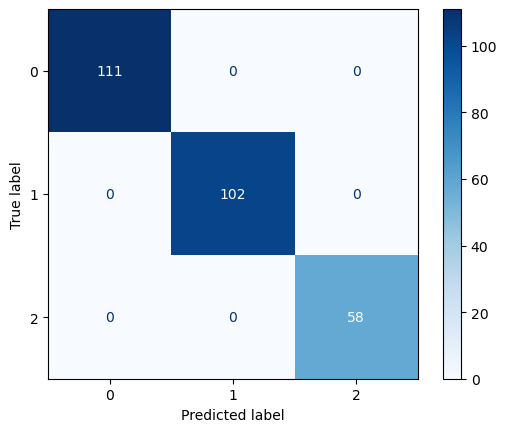

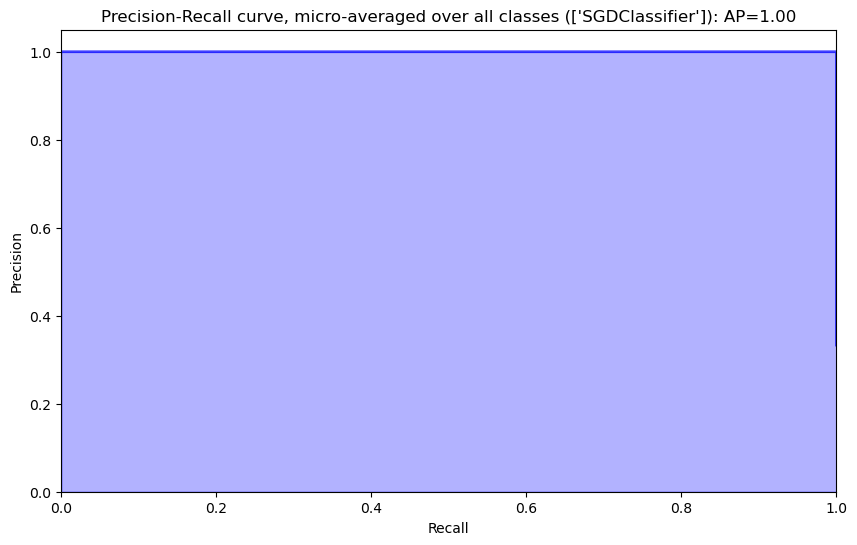

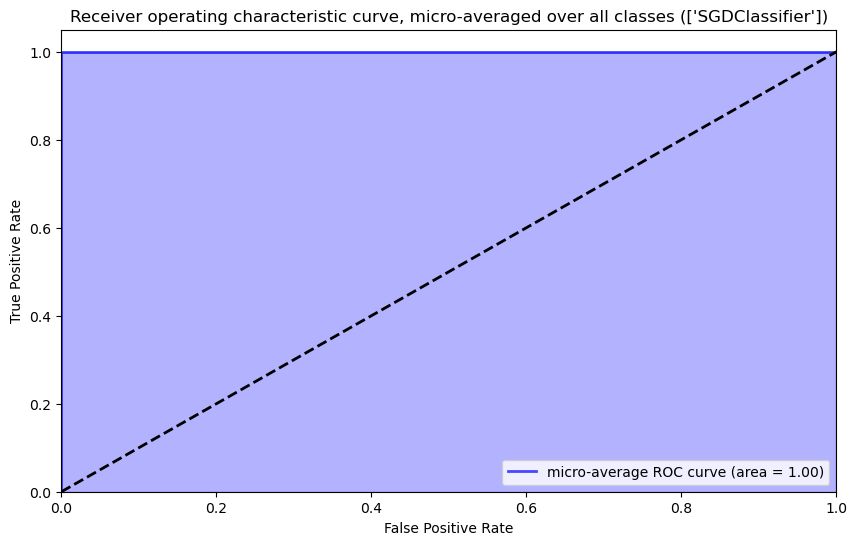

In [155]:
def train_sgd_model(X_train, y_train, model_params, n_splits=10, random_states=[42]):

    train_losses_all = []
    cv_losses_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        model_params["random_state"] = random_state

        model = SGDClassifier(**model_params)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        train_losses = []
        cv_losses = []

        # Convert the column vector y_train to a 1D array using ravel()
        y_train_1d = y_train.values.ravel()
        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train_1d[train_index], y_train_1d[cv_index]

            model.fit(X_train_fold, y_train_fold)

            y_pred_train_prob = model.predict_proba(X_train_fold)
            logloss_train = log_loss(y_train_fold, y_pred_train_prob)
            train_losses.append(logloss_train)

            y_pred_cv_prob = model.predict_proba(X_cv_fold)
            logloss_cv = log_loss(y_cv_fold, y_pred_cv_prob)
            cv_losses.append(logloss_cv)

            print('Training Log Loss: ', logloss_train)
            print('CV Log Loss: ', logloss_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)

    avg_train_logloss = np.mean(train_losses_all)
    avg_cv_logloss = np.mean(cv_losses_all)

    print("Mean Train Log Loss (dimensionless): {:.4f}, Mean CV Log Loss (dimensionless): {:.4f}".format(avg_train_logloss, avg_cv_logloss))

    return model, train_losses_all, cv_losses_all

model_params_sgd = {
    "loss": "log_loss",  # Change this to 'log' or 'modified_huber'
    "penalty": "l2",
    "alpha": 0.0001,
    "l1_ratio": 0.15,
    "fit_intercept": True,
    "max_iter": 1000,
    "tol": 1e-3,
    "shuffle": True,
    "verbose": 0,
    "epsilon": 0.1,
    "n_jobs": None,
    "random_state": None,
    "learning_rate": "optimal",
    "eta0": 0.0,
    "power_t": 0.5,
    "early_stopping": False,
    "validation_fraction": 0.1,
    "n_iter_no_change": 5,
    "class_weight": None,
    "warm_start": False,
    "average": False,
}

# Custom model parameters
model_params_sgd = {
    "loss": "modified_huber",
    "penalty": "elasticnet",
    "alpha": 0.2, # Increase the regularization strength by adjusting the alpha parameter. Higher values will impose stronger regularization, preventing the model from overfitting the training data. You can also experiment with different regularization techniques, such as L1, L2, or a combination of both (elastic net).
    "l1_ratio": 0.5,
    "learning_rate": "optimal",
    "early_stopping": True, # Enable early stopping by setting early_stopping to True. This will stop training when the validation score is not improving, which can help prevent overfitting.
    "validation_fraction": 0.05,
    "random_state": 2021,
    # Feature selection: Reduce the number of features used for training, by either using domain knowledge or applying feature selection techniques such as recursive feature elimination or feature importance ranking.
    # Hyperparameter tuning: Perform a more exhaustive search for optimal hyperparameters using techniques like grid search, random search, or Bayesian optimization combined with cross-validation.
    # Model complexity: If you're using a complex model, consider using a simpler model that might generalize better to the validation data.
    # Data preprocessing: Check for data leakage, ensure proper data scaling, and handle missing or categorical data correctly to improve model performance.
    # Increase the amount of training data: More data can help the model learn better patterns and generalize to unseen data.
}

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_name = ['SGDClassifier']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

## Random Forest

    Random Forest is an ensemble learning method widely used for both classification and regression tasks. It works by constructing multiple decision trees during training and outputting the mode of the classes for classification or the mean prediction for regression. Random Forests are robust, can handle non-linear relationships between features and target, and are less prone to overfitting due to the averaging of multiple trees. They perform well on large datasets, can handle missing data, and provide a built-in feature importance measure.

    The significance of the Random Forest outputting the mode of the classes for classification is that it combines the predictions of multiple decision trees to make the final prediction. The mode represents the most common class predicted by the trees in the ensemble, which makes the Random Forest more robust and less prone to overfitting compared to a single decision tree.

    The Gini impurity and cross-entropy are two different measures used to quantify the impurity or disorder within a set of data points. Both measures are used in decision trees to determine the best split at each node, but they have different mathematical properties and interpretations.

    Gini impurity measures the probability of a randomly chosen element from the dataset being incorrectly classified if it were randomly labeled according to the class distribution in the dataset. Lower Gini impurity indicates a purer set of data points belonging to the same class. Gini impurity is computationally efficient because it does not involve logarithmic calculations, making it the default criterion in many decision tree implementations.

    Cross-entropy, on the other hand, is derived from information theory and measures the average number of bits needed to encode events from one probability distribution using the optimal code for another probability distribution. In the context of decision trees, cross-entropy measures the average information content of the data points after a split. Lower cross-entropy implies that the split results in a more homogeneous distribution of the target classes.

    In practice, both Gini impurity and cross-entropy often produce similar results when used as splitting criteria in decision trees. However, Gini impurity is usually preferred due to its computational efficiency. Cross-entropy might be more suitable in cases where the probability estimates of the classes are of interest, as it is more sensitive to changes in the class probabilities.

    Feature importance in a Random Forest classifier refers to a metric that quantifies the contribution of each feature to the prediction of the target variable. In a Random Forest, the importance of a feature is calculated by averaging the importance scores of that feature across all the decision trees in the ensemble. The importance score for a feature in a single tree is computed as the total reduction in impurity, such as Gini impurity or entropy, that the feature brings when used in the tree's decision nodes. Features with higher importance scores have a greater impact on the model's predictions, and understanding feature importance can help you identify the most relevant features, perform feature selection, and gain insights into the underlying relationships between the features and the target variable.

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

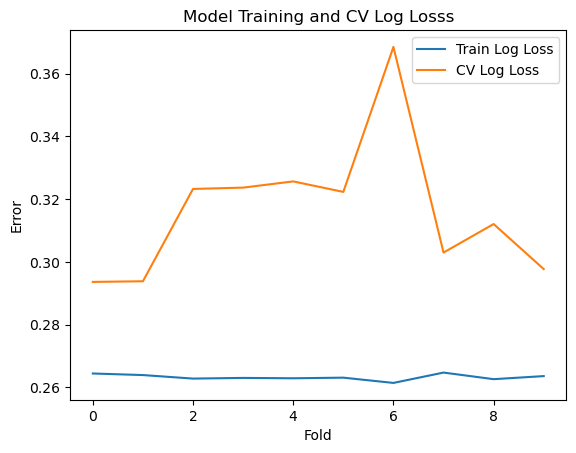

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


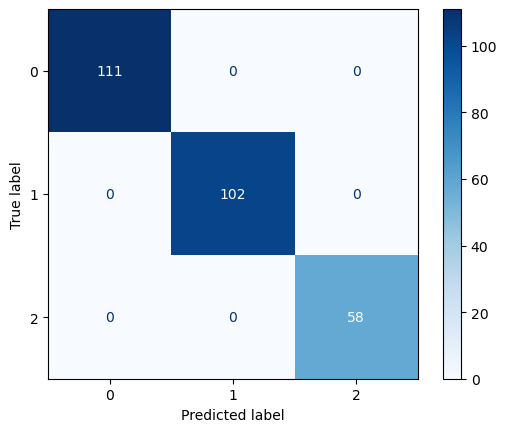

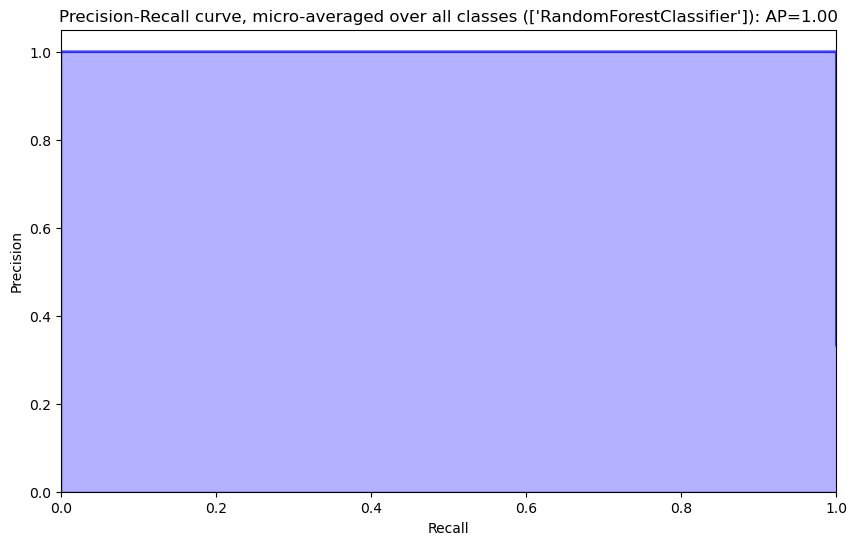

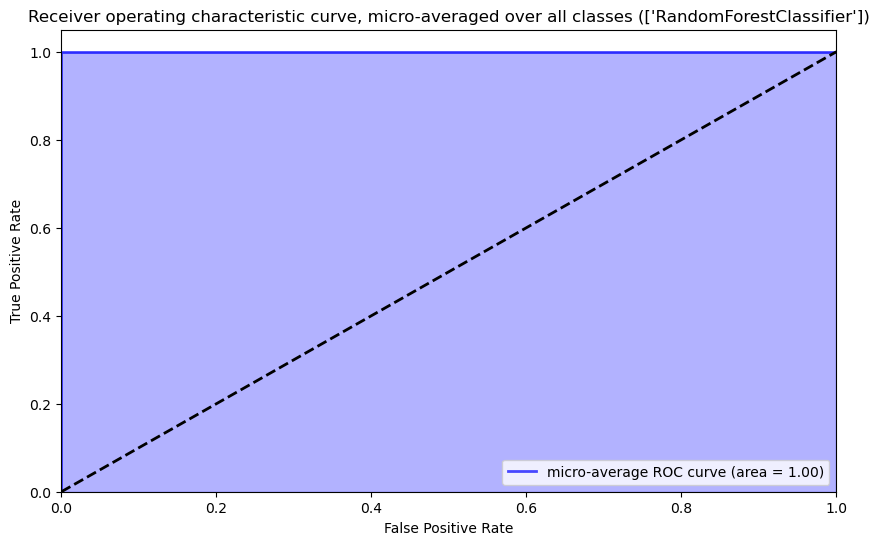

In [156]:
def train_rf_model(X_train, y_train, model_params, n_splits=10, random_states=[42]):

    train_losses_all = []
    cv_losses_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        model_params["random_state"] = random_state

        model = RandomForestClassifier(**model_params)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        train_losses = []
        cv_losses = []

        # Convert the column vector y_train to a 1D array using ravel()
        y_train_1d = y_train.values.ravel()
        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train_1d[train_index], y_train_1d[cv_index]

            model.fit(X_train_fold, y_train_fold)

            y_pred_train_prob = model.predict_proba(X_train_fold)
            logloss_train = log_loss(y_train_fold, y_pred_train_prob)
            train_losses.append(logloss_train)

            y_pred_cv_prob = model.predict_proba(X_cv_fold)
            logloss_cv = log_loss(y_cv_fold, y_pred_cv_prob)
            cv_losses.append(logloss_cv)

            print('Training Log Loss: ', logloss_train)
            print('CV Log Loss: ', logloss_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)

    avg_train_logloss = np.mean(train_losses_all)
    avg_cv_logloss = np.mean(cv_losses_all)

    print("Mean Train Log Loss (dimensionless): {:.4f}, Mean CV Log Loss (dimensionless): {:.4f}".format(avg_train_logloss, avg_cv_logloss))

    return model, train_losses_all, cv_losses_all

# Default model parameters
model_params_rfc = {
    "n_estimators": 100,
    "criterion": "gini",
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_features": "sqrt",
    "max_leaf_nodes": None,
    "min_impurity_decrease": 0.0,
    "bootstrap": True,
    "oob_score": False,
    "n_jobs": None,
    "random_state": None,
    "verbose": 0,
    "warm_start": False,
    "class_weight": None,
}

# Custom model parameters
model_params_rfc = {
    "n_estimators": 155, # Number of trees in the forest
    "criterion": "gini", # Function to measure the quality of a split (either "gini" or "entropy")
    "max_depth": 5, # The maximum depth of the tree
    "min_samples_split": 3, # The minimum number of samples required to split an internal node
    "min_samples_leaf": 2, # The minimum number of samples required to be at a leaf node
    "max_features": "sqrt", # The number of features to consider when looking for the best split (can be "auto", "sqrt", "log2", or an integer)
    "bootstrap": False, # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
    "random_state": 2021,
}

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_name = ['RandomForestClassifier']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

## Boosting

### XGBoost

    XGBoost is an optimized distributed gradient boosting library designed for both efficiency and accuracy. It stands for "eXtreme Gradient Boosting" and has gained popularity for its speed and performance. XGBoost is widely used in machine learning competitions and real-world applications due to its ability to handle large-scale datasets and provide exceptional predictive power. Some key parameters in XGBoost include the learning rate, which controls the step size of the updates during gradient boosting; the maximum tree depth, which determines the complexity of each individual tree in the ensemble; and the number of boosting rounds, which sets the number of trees added to the model. Regularization parameters, such as L1 and L2 regularization, are also available to help control overfitting. XGBoost supports parallel and distributed computing, allowing it to scale across multiple cores or nodes for increased performance.

    In the XGBoost model parameters, the evaluation metric is not explicitly specified. However, by default, XGBoost uses the appropriate metric based on the specified objective. In this case, since the objective is set to 'multiclass', XGBoost will use the 'mlogloss' (multiclass log loss) metric for evaluation.

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

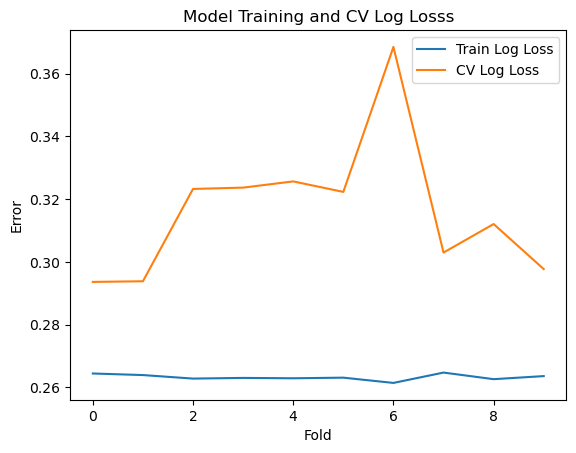

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


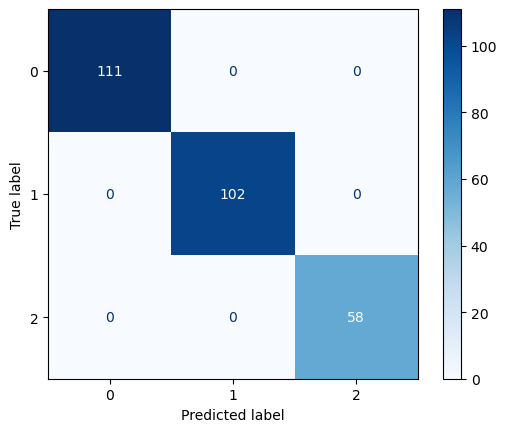

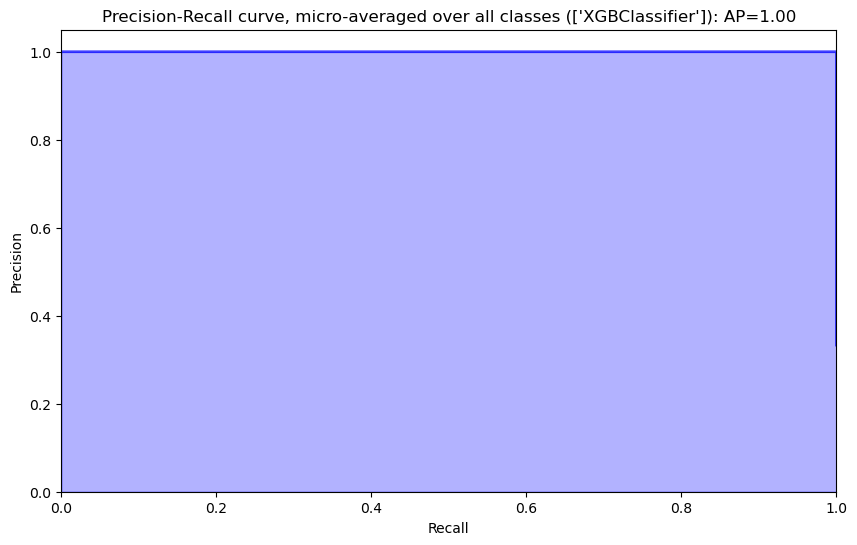

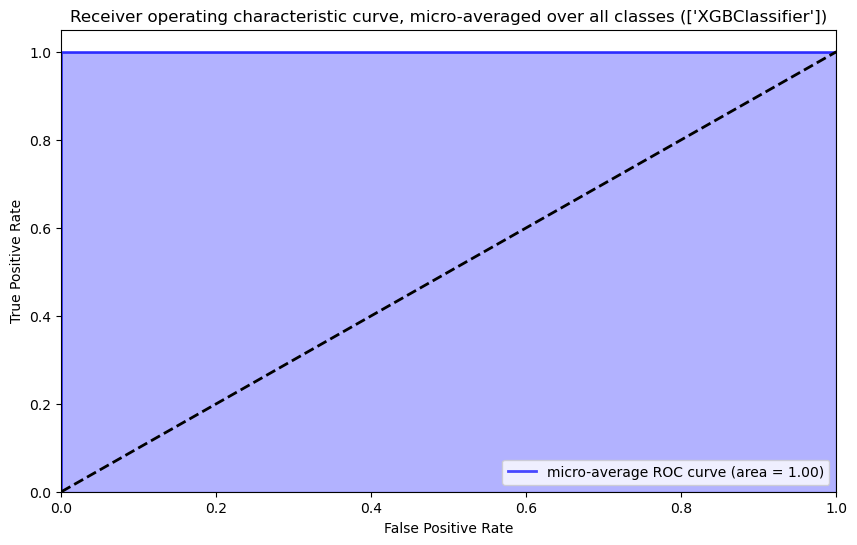

In [157]:
def train_xgb_model(X_train, y_train, model_params, n_splits=10, random_states=[42]):

    train_losses_all = []
    cv_losses_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        model_params["seed"] = random_state

        model = xgb.XGBClassifier(**model_params)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        train_losses = []
        cv_losses = []

        # Convert the column vector y_train to a 1D array using ravel()
        y_train_1d = y_train.values.ravel()
        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train_1d[train_index], y_train_1d[cv_index]

            model.fit(X_train_fold, y_train_fold, eval_set=[(X_cv_fold, y_cv_fold)], verbose=False)

            y_pred_train_prob = model.predict_proba(X_train_fold)
            logloss_train = log_loss(y_train_fold, y_pred_train_prob)
            train_losses.append(logloss_train)

            y_pred_cv_prob = model.predict_proba(X_cv_fold)
            logloss_cv = log_loss(y_cv_fold, y_pred_cv_prob)
            cv_losses.append(logloss_cv)

            print('Training Log Loss: ', logloss_train)
            print('CV Log Loss: ', logloss_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)

    avg_train_logloss = np.mean(train_losses_all)
    avg_cv_logloss = np.mean(cv_losses_all)

    print("Mean Train Log Loss (dimensionless): {:.4f}, Mean CV Log Loss (dimensionless): {:.4f}".format(avg_train_logloss, avg_cv_logloss))

    return model, train_losses_all, cv_losses_all

model_params_xgb = {
    "objective": "multiclass",
    "base_score": 0.5,
    "booster": "gbtree",
    "colsample_bylevel": 1,
    "colsample_bynode": 1,
    "colsample_bytree": 1,
    "gamma": 0,
    "gpu_id": -1,
    "importance_type": "gain",
    "interaction_constraints": "",
    "learning_rate": 0.300000012,
    "max_delta_step": 0,
    "max_depth": 6,
    "min_child_weight": 1,
    "missing": np.nan,  # Set the missing value to np.nan
    "monotone_constraints": "()",
    "n_estimators": 100,
    "n_jobs": None,
    "num_parallel_tree": 1,
    "random_state": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "subsample": 1,
    "tree_method": "auto",
    "validate_parameters": None,
    "verbosity": None,
}

# Custom model parameters
model_params_xgb = {
    "n_estimators": 100,
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 4,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'multiclass',
    # "scale_pos_weight": 1,
    "reg_alpha": 0.95,
    "reg_lambda": 0.9,
    "seed": 2021,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
}

# "n_estimators": Number of boosting rounds to be run. The more boosting rounds, the more complex the model, which can lead to better performance but also overfitting.
# "learning_rate": Learning rate, also known as shrinkage. This controls the impact of each individual tree on the final model, which helps prevent overfitting.
# "max_depth": Maximum depth of a tree. Deeper trees can model more complex relationships but may overfit the data.
# "min_child_weight": Minimum sum of instance weight (hessian) needed in a child. Higher values prevent overfitting by making the algorithm more conservative.
# "gamma": Minimum loss reduction required to make a further partition on a leaf node of the tree. A larger gamma makes the algorithm more conservative.
# "subsample": Subsample ratio of the training instances, which prevents overfitting.
# "colsample_bytree": Subsample ratio of columns when constructing each tree, which helps to avoid overfitting.
# "objective": The learning objective to be used, in this case 'multiclass' for multiclass classification.
# "scale_pos_weight": Controls the balance of positive and negative weights, useful for imbalanced classes.
# "reg_alpha": L1 regularization term on weights, which helps to avoid overfitting.
# "reg_lambda": L2 regularization term on weights, which helps to avoid overfitting.
# "seed": The random seed used for reproducibility.

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_name = ['XGBClassifier']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

### LightGBM

    LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be efficient and scalable, with a focus on handling large-scale data and reducing memory usage. LightGBM stands for "Light Gradient Boosting Machine" and is particularly suitable for large datasets or cases where faster training is required. Key features of LightGBM include the use of histogram-based algorithms for faster tree construction and the ability to handle categorical features directly, without the need for one-hot encoding. Important parameters in LightGBM include the learning rate, which determines the step size during gradient boosting; the number of leaves, which controls the complexity of the trees; and the number of boosting rounds, which sets the number of trees in the model. Like XGBoost, LightGBM also supports regularization and offers advanced features such as early stopping and support for distributed training.

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

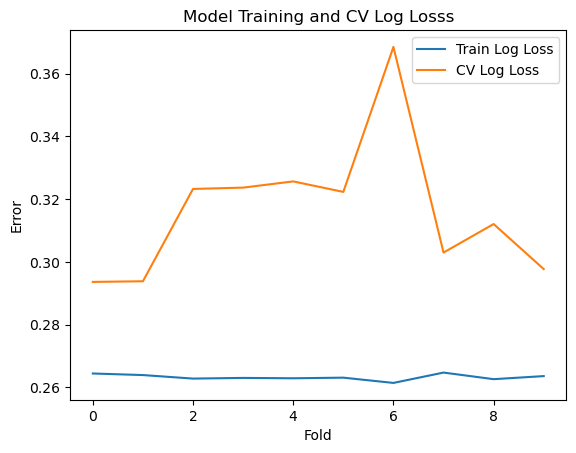

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


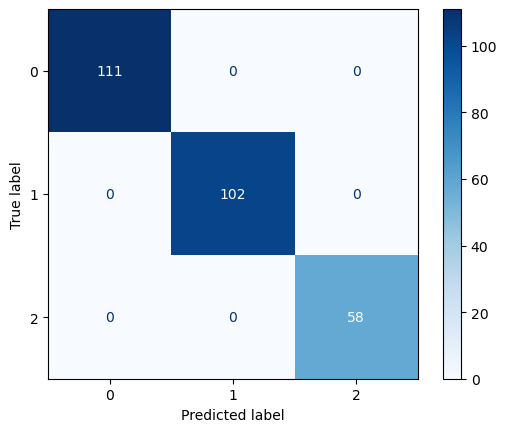

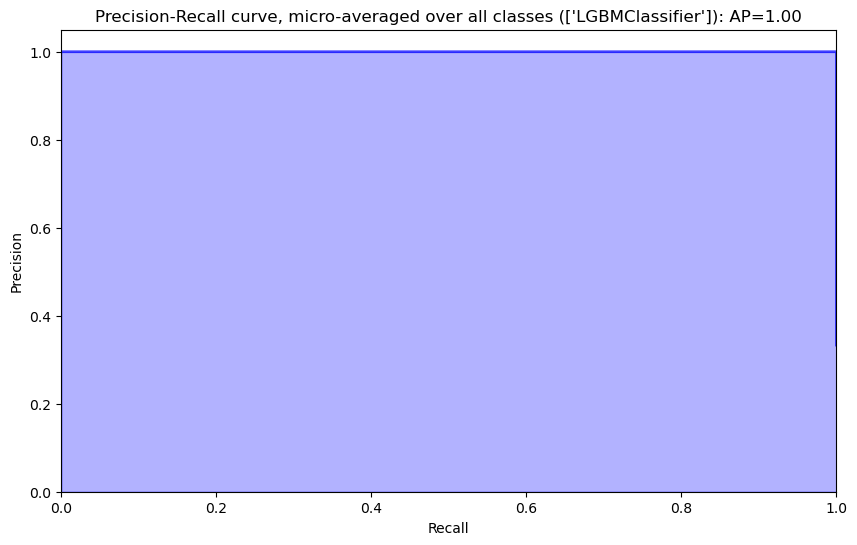

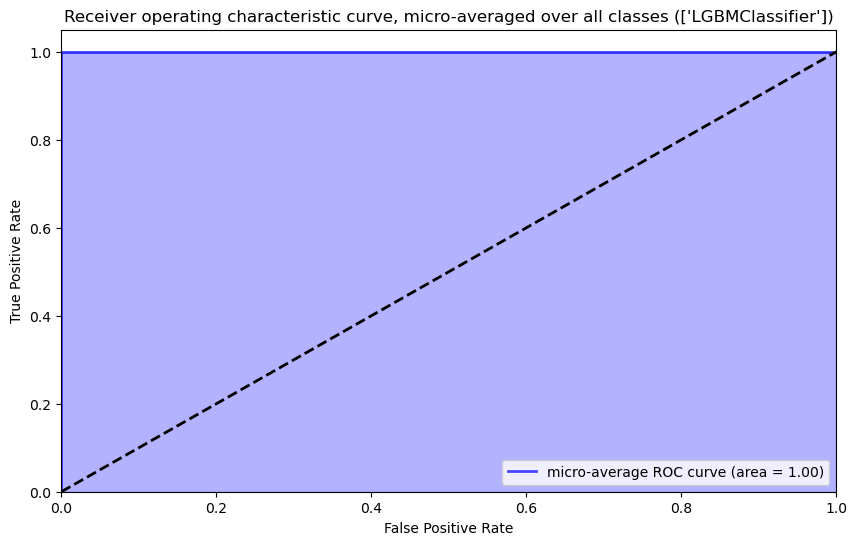

In [158]:
def train_lgb_model(X_train, y_train, model_params, n_splits=10, random_states=[42]):

    train_losses_all = []
    cv_losses_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        model_params["random_state"] = random_state

        model = lgb.LGBMClassifier(**model_params)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        train_losses = []
        cv_losses = []

        # Convert the column vector y_train to a 1D array using ravel()
        y_train_1d = y_train.values.ravel()
        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train_1d)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train_1d[train_index], y_train_1d[cv_index]

            model.fit(X_train_fold, y_train_fold)

            y_pred_train_prob = model.predict_proba(X_train_fold)
            logloss_train = log_loss(y_train_fold, y_pred_train_prob)
            train_losses.append(logloss_train)

            y_pred_cv_prob = model.predict_proba(X_cv_fold)
            logloss_cv = log_loss(y_cv_fold, y_pred_cv_prob)
            cv_losses.append(logloss_cv)

            print('Training Log Loss: ', logloss_train)
            print('CV Log Loss: ', logloss_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)

    avg_train_logloss = np.mean(train_losses_all)
    avg_cv_logloss = np.mean(cv_losses_all)

    print("Mean Train Log Loss (dimensionless): {:.4f}, Mean CV Log Loss (dimensionless): {:.4f}".format(avg_train_logloss, avg_cv_logloss))

    return model, train_losses_all, cv_losses_all

# Default model parameters
model_params_gbm = {
    "boosting_type": "gbdt",
    "num_leaves": 30, # The maximum number of leaves in one tree. Setting it to a smaller value can help to reduce overfitting.
    "max_depth": -1, # The maximum depth of a tree. Setting it to a smaller value can help to reduce overfitting.
    "learning_rate": 0.01, # The learning rate or step size. A smaller value can help to reduce overfitting, but it might require more iterations (n_estimators) to converge
    "n_estimators": 200, # The number of boosting rounds (iterations) to run. If the learning rate is smaller, you might need to increase the number of estimators.
    "subsample_for_bin": 200000,
    "objective": None,
    "class_weight": None,
    "min_split_gain": 0.0,
    "min_child_weight": 0.001,
    "min_child_samples": 22, # The minimum number of data points required in a leaf node. A larger value can help to reduce overfitting.
    "subsample": 0.9, # The fraction of samples to be used for fitting the individual trees (also known as bagging). A smaller value can help to reduce overfitting.
    "subsample_freq": 0,
    "colsample_bytree": 0.9, # The fraction of features to choose for each tree. A smaller value can help to reduce overfitting.
    "reg_alpha": 1, # L1 regularization term on weights. A larger value can help to reduce overfitting.
    "reg_lambda": 0.8, # L2 regularization term on weights. A larger value can help to reduce overfitting.
    "random_state": None,
    "n_jobs": -1,
    "importance_type": "split",
}

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_names = ['LGBMClassifier']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_names)
    plot_roc_curve(y_train, y_pred_proba_binary, model_names)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_names)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_names)

## Overall Comparison

    So far we have tested 4 models for a classification problem and test them on the training set. Lets see how good they are with the test data (spared at the very begining).

    For the boosting models, we should indeed use the predict method with num_iteration=GBM.best_iteration

    This should work for both binary and multiclass problems. For multiclass problems, the log_loss function requires the labels parameter to be set explicitly, which is done using labels=np.unique(y_train)

In [159]:
def print_log_losses(X_test, y_test, model_instances, model_names):
    log_loss_results = []
    accuracy_results = []
    for model_instance, model_name in zip(model_instances, model_names):
        test_loss, test_accuracy = evaluate_model(model_instance, X_test, y_test, f"{model_name}")

        log_loss_results.append(test_loss)
        accuracy_results.append(test_accuracy)
    return log_loss_results, accuracy_results

model_instances = [
    LogisticRegression(**model_params_log_reg),
    SGDClassifier(**model_params_sgd),
    RandomForestClassifier(**model_params_rfc),
    xgb.XGBClassifier(**model_params_xgb),
    lgb.LGBMClassifier(**model_params_gbm),
]

# Initialize the models and their names
# models = [LogisticRegression(), SGDClassifier(loss='log'), RandomForestClassifier(), xgb.XGBClassifier(), lgb.LGBMClassifier()]
model_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier']

def fit_models(X_train, y_train, model_instances):
    for model_instance in model_instances:
        y_train_1d = y_train.values.ravel()
        model_instance.fit(X_train, y_train_1d)

fit_models(X_train, y_train, model_instances)

log_loss_results, accuracy_results = print_log_losses(X_test, y_test, model_instances, model_names)

LogisticRegression Model Performance:
Test Log Loss (dimensionless): 0.3377
Test Accuracy: 0.9706
SGDClassifier Model Performance:
Test Log Loss (dimensionless): 0.1688
Test Accuracy: 0.9853
RandomForestClassifier Model Performance:
Test Log Loss (dimensionless): 0.5325
Test Accuracy: 0.9118
XGBClassifier Model Performance:
Test Log Loss (dimensionless): 0.2861
Test Accuracy: 0.9559
LGBMClassifier Model Performance:
Test Log Loss (dimensionless): 0.4008
Test Accuracy: 0.9118


### Note I:

    This numbers of Log Loss in the evaluation and training results, just define how different it is from the true labels, it is a distance, it is a logarithmic distance, but it is a distance and we can compare within the different models. 

    For having a better understanding of how well the model perfoms, we can create a dummy model. 
    
    It is a random guess model, what we do essentialy is we just tose a coin. In practice the machine learning we use should perform much better than the random guess model.

    Based on the performance of the models, the following conclusions can be drawn:

    The LogisticRegression model achieved a test log loss of 0.3377 and an accuracy of 0.9706. The SGDClassifier outperformed other models with a test log loss of 0.1688 and an accuracy of 0.9853. The RandomForestClassifier had a test log loss of 0.5325 and an accuracy of 0.9118. The XGBClassifier had a test log loss of 0.2861 and an accuracy of 0.9559. Lastly, the LGBMClassifier had a test log loss of 0.4008 and an accuracy of 0.9118.

    All the models were evaluated using the F1-score, with the SGDClassifier showing the best performance (F1-score: 0.9853). The confusion matrices for all the models showed similar true value counts for the encoded labels.

### Log Loss Analysis for a Mutliclass classification problem

The next question is whether the obtained log loss is reasonable or not. In multi-class classification (M > 2), the worst performance can be estimated from the limiting solution (random guess):

$$Logloss = -log\frac{1}{M}\$$

For the limiting solution in a multi-class classification problem, the log loss can be estimated as follows:

$$Log Loss = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{M}y_{ij}\log(p_{ij})$$

Where:
- N is the number of samples
- M is the number of classes
- $y_{ij}$ is an indicator variable that equals 1 if sample i belongs to class j and 0 otherwise
- $p_{ij}$ is the predicted probability that sample i belongs to class j

First, calculate the prevalence of each class:

$$p(i) = \frac{\text{count of class }i}{\text{total count}}$$

Then, compute the expected log loss using the formula above. It's important to note that, in a multi-class classification problem, the expected log loss should be calculated for each class separately and then averaged. This will give us a baseline log loss value that can be used to compare the performance of the models.


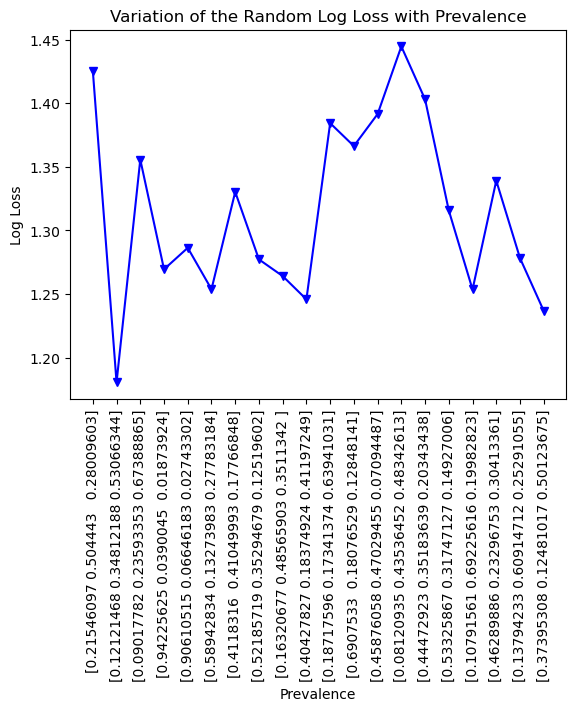

In [160]:
def log_loss_multi_class(y_test, y_pred_proba, n_classes):
    N = len(y_test)
    log_loss_sum = 0
    
    # Check if y_test is a DataFrame
    is_dataframe = isinstance(y_test, pd.DataFrame)
    
    for i in range(N):
        for j in range(n_classes):
            y_ij = 1 if (y_test.iloc[i, 0] if is_dataframe else y_test.iloc[i]) == j else 0
            p_ij = y_pred_proba[i][j]
            # Add a small constant to p_ij to avoid the math domain error
            log_loss_sum += y_ij * math.log(p_ij + 1e-15)
    
    log_loss_result = -1/N * log_loss_sum
    return log_loss_result

# Generatation of random prevalence values and calculation of their corresponding log losses 
# for the purpose of illustrating the relationship between prevalence and log loss:
# Example
def generate_and_plot_random_log_losses(n_classes, n_examples, n_samples):
    prevalence_values = []
    losses_example = []

# Loop 20 times to generate 20 random examples
    for _ in range(n_examples):
        # Generate a random prevalence array of length n_classes
        random_prevalence = np.random.rand(n_classes)
        # Normalize the random_prevalence array so that the sum is 1
        random_prevalence /= random_prevalence.sum()
        prevalence_values.append(random_prevalence)

        # Create dummy y_test and y_pred_proba data to use with the log_loss_multi_class function
        y_test = pd.Series(np.random.choice(range(n_classes), size=n_samples, p=random_prevalence))
        y_pred_proba = np.random.rand(n_samples, n_classes)
        y_pred_proba /= y_pred_proba.sum(axis=1, keepdims=True)

        # Calculate the log loss for the dummy y_test and y_pred_proba data using the log_loss_multi_class function
        # and append it to the losses_example list
        losses_example.append(log_loss_multi_class(y_test, y_pred_proba, n_classes))

    plt.plot([str(p) for p in prevalence_values], losses_example, '-', marker='v', color='b', label="Log Loss")
    plt.xlabel("Prevalence")
    plt.ylabel("Log Loss")
    plt.title("Variation of the Random Log Loss with Prevalence")
    plt.xticks(rotation=90)
    plt.show()

# Call the function
generate_and_plot_random_log_losses(n_classes=3, n_examples=20, n_samples=100)

Evaluating LogisticRegression:
Test F1-score: 0.9704
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


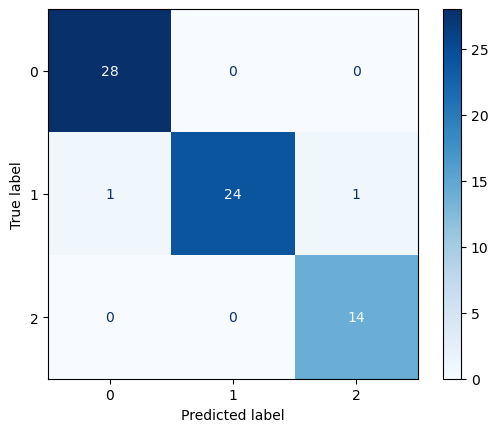

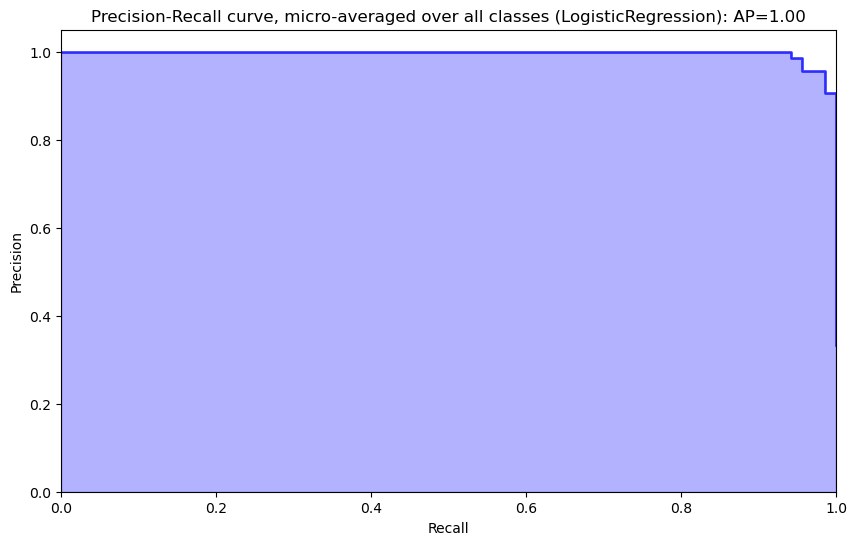

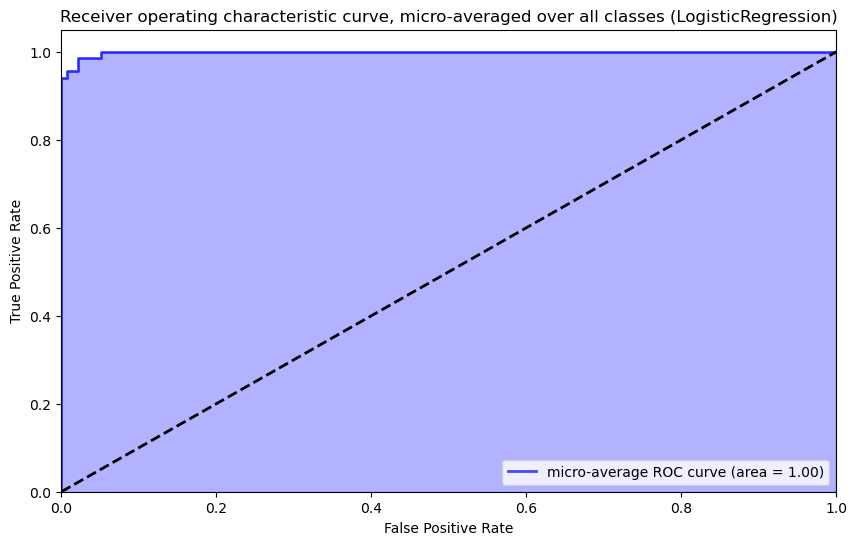

LogisticRegression log loss: 0.3377
Dummy model log loss: 1.0986


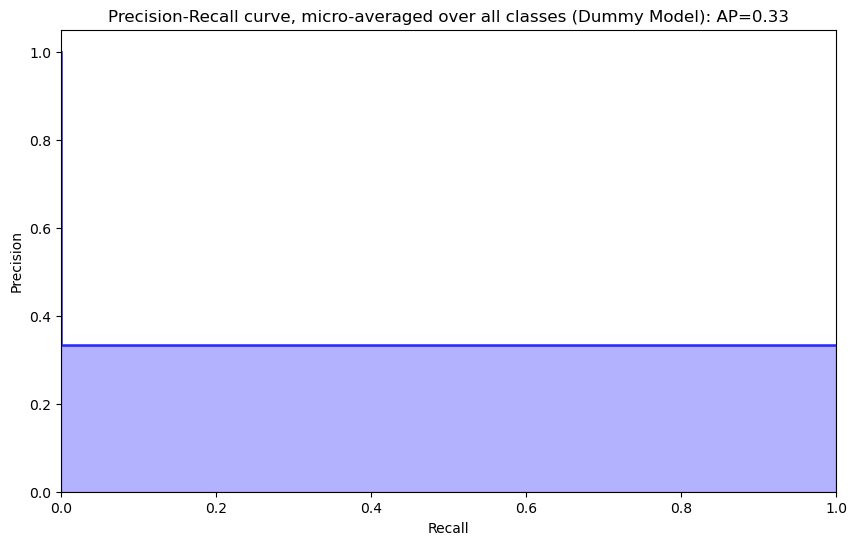

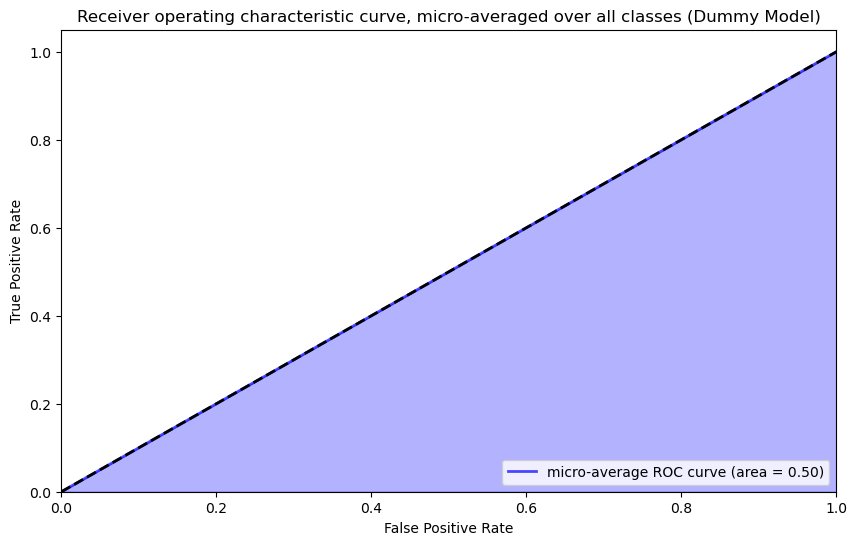



Evaluating SGDClassifier:
Test F1-score: 0.9853
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


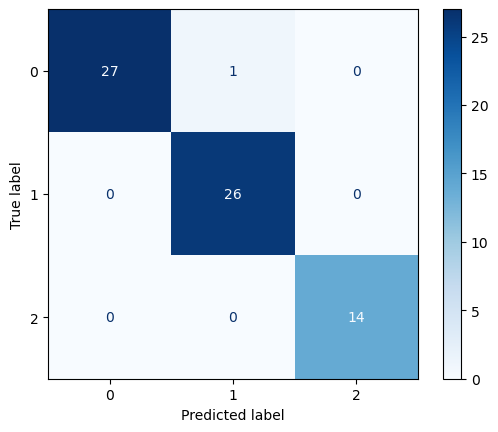

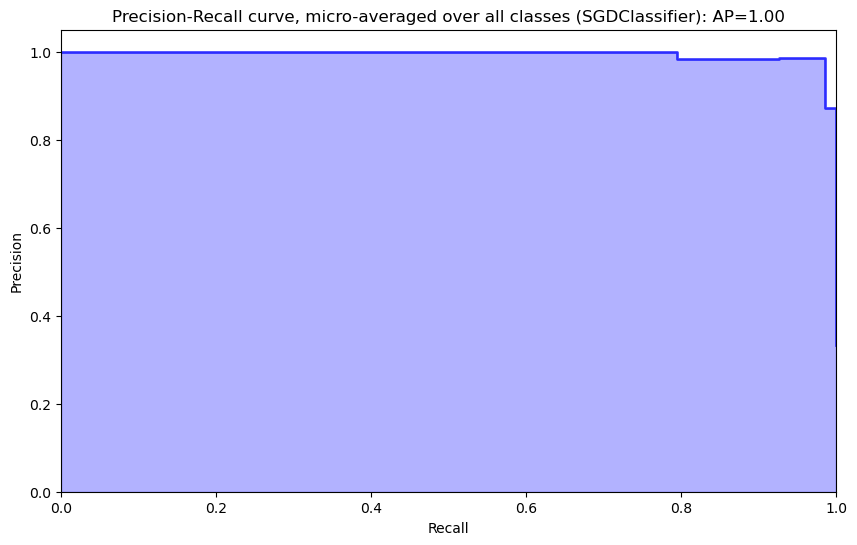

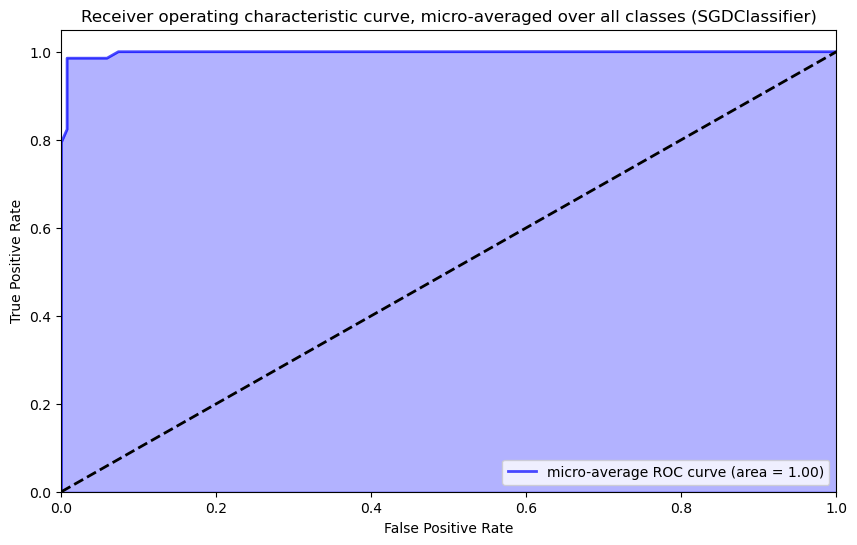

SGDClassifier log loss: 0.1688
Dummy model log loss: 1.0986


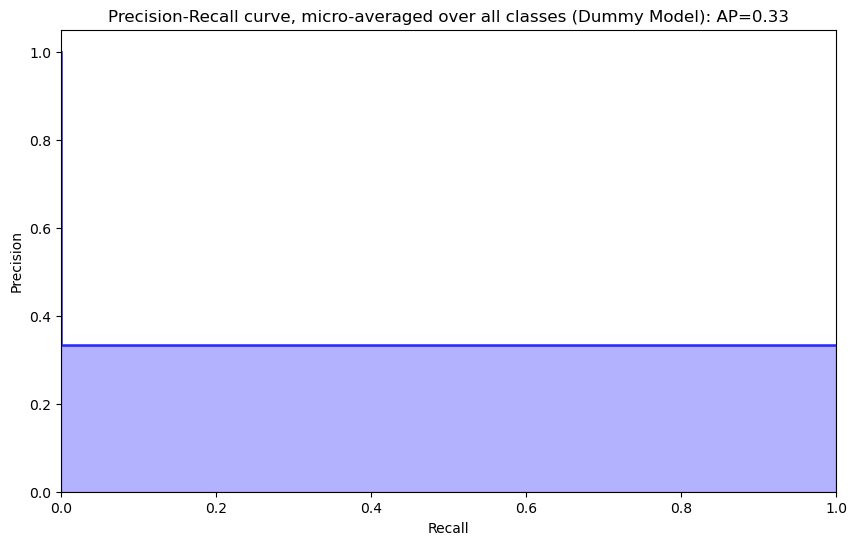

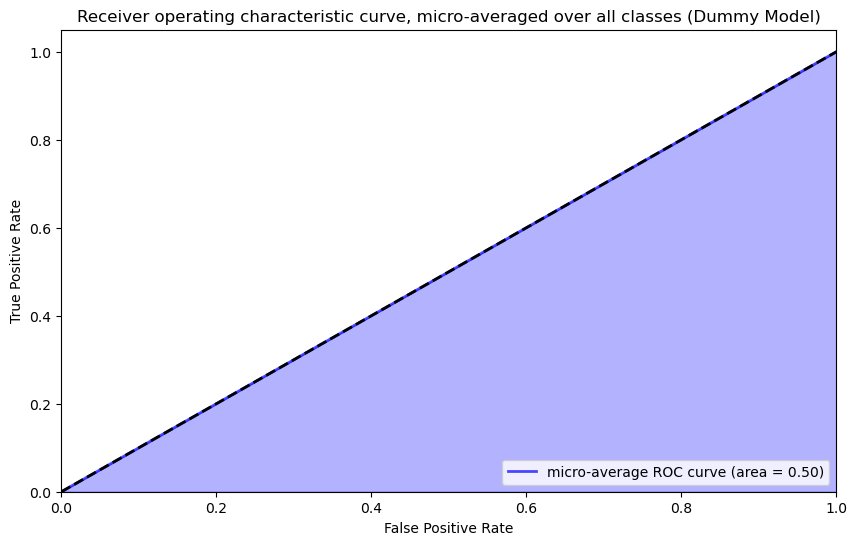



Evaluating RandomForestClassifier:
Test F1-score: 0.9115
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


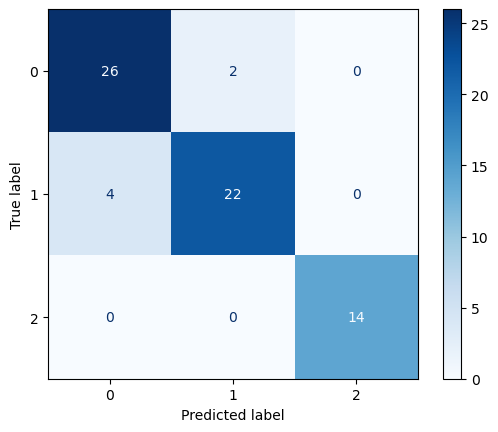

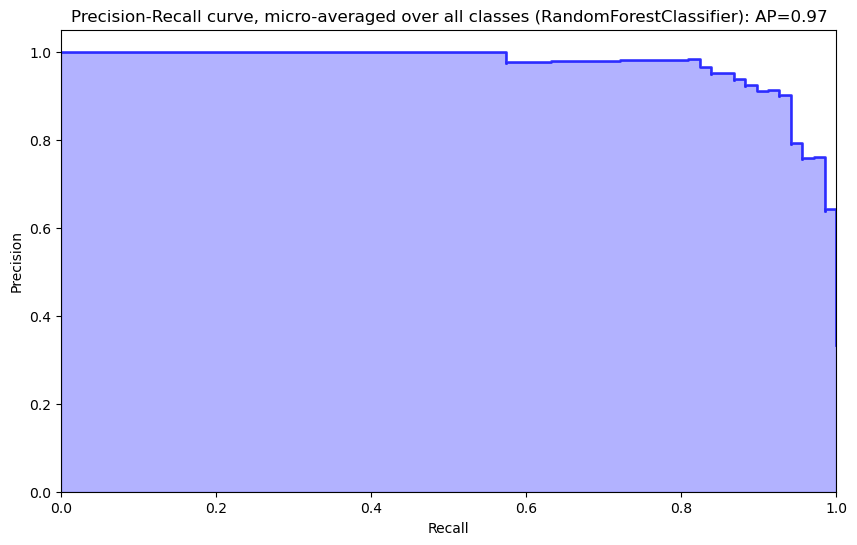

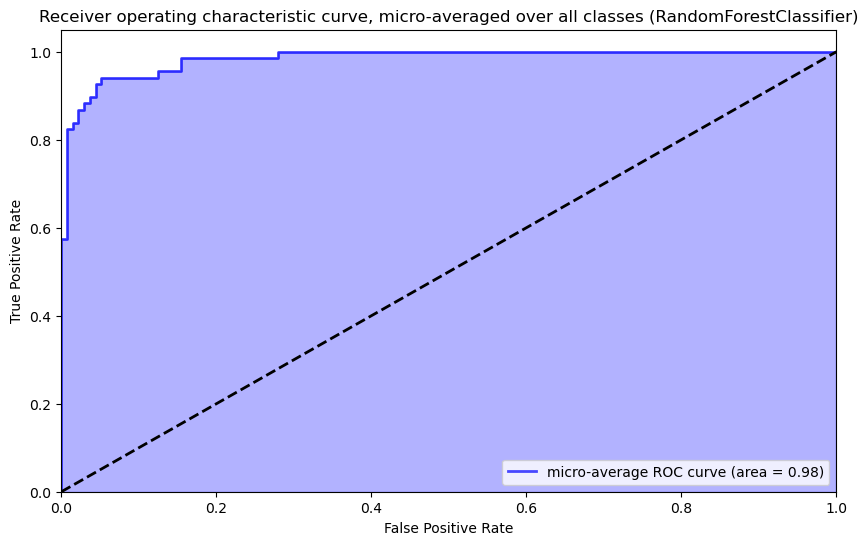

RandomForestClassifier log loss: 0.5325
Dummy model log loss: 1.0986


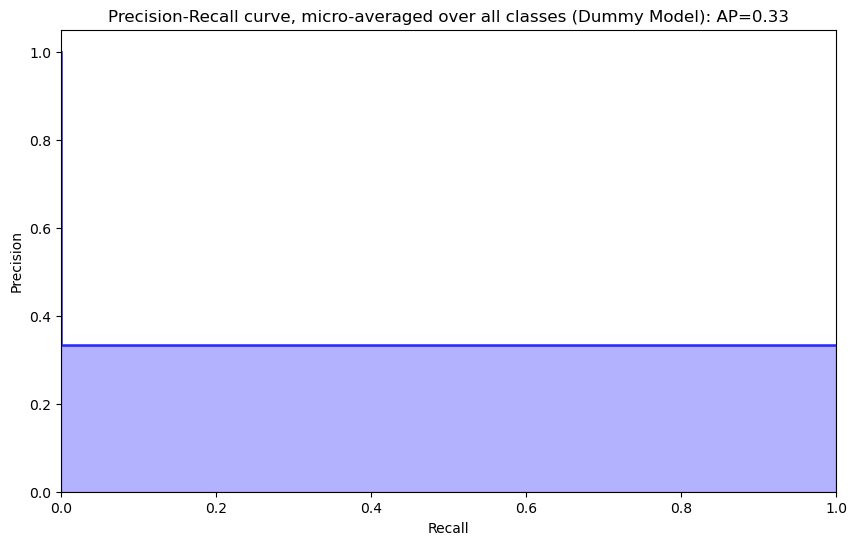

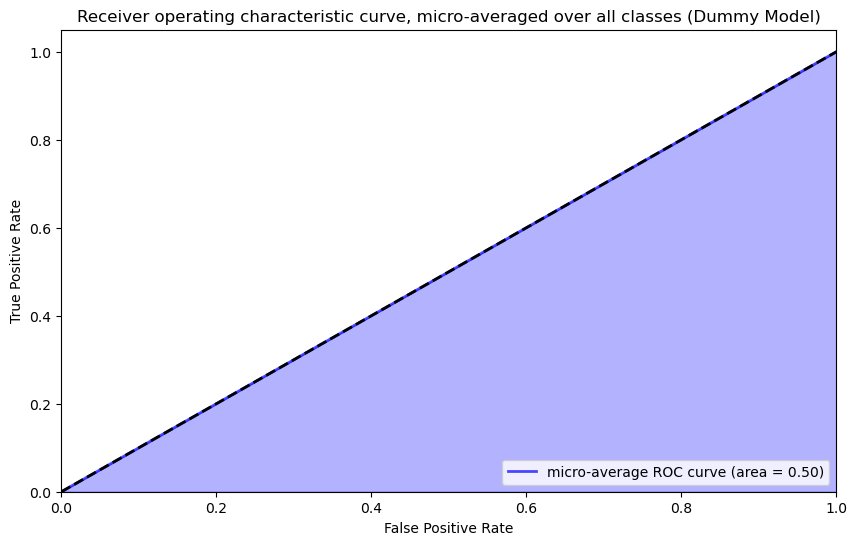



Evaluating XGBClassifier:
Test F1-score: 0.9559
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


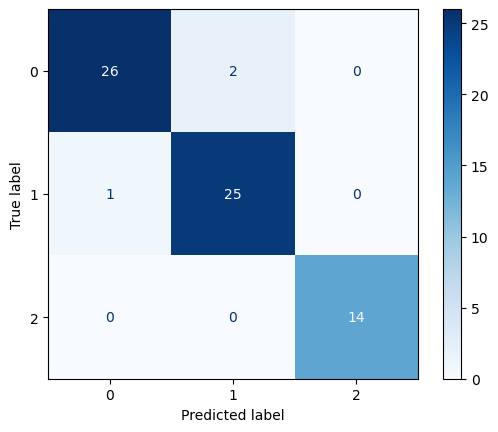

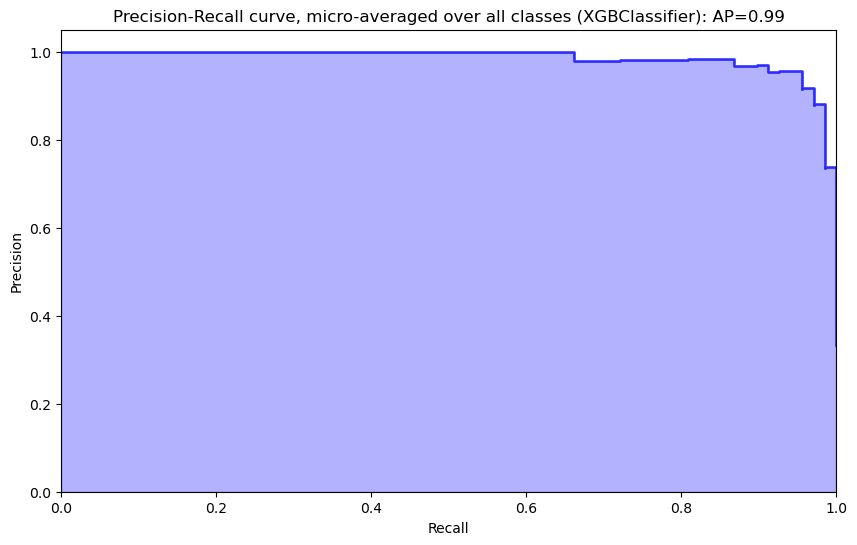

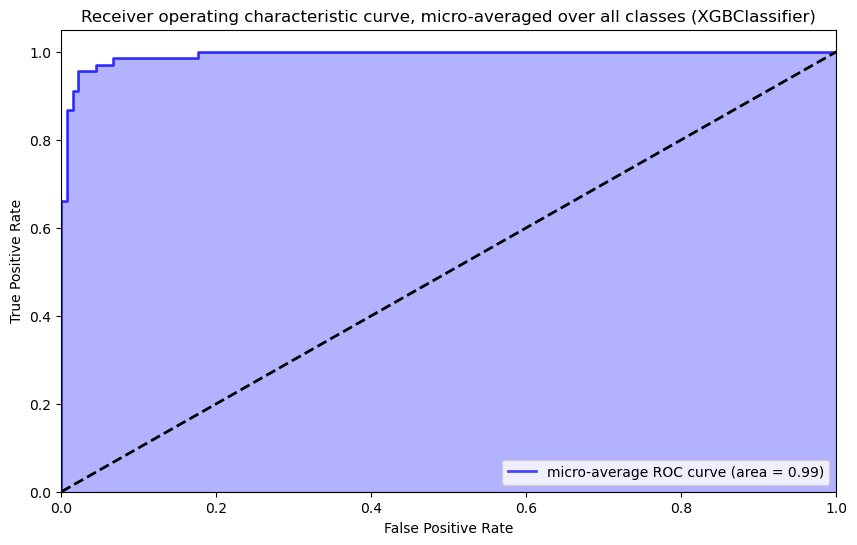

XGBClassifier log loss: 0.2861
Dummy model log loss: 1.0986


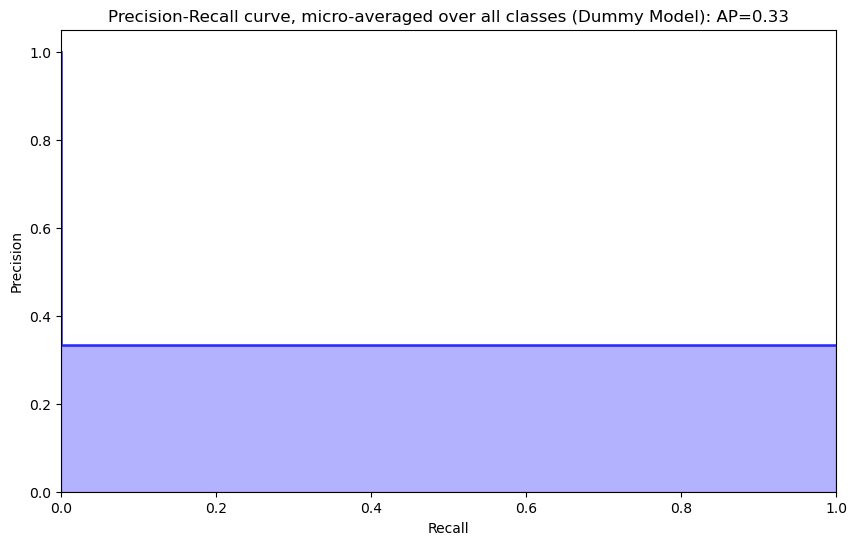

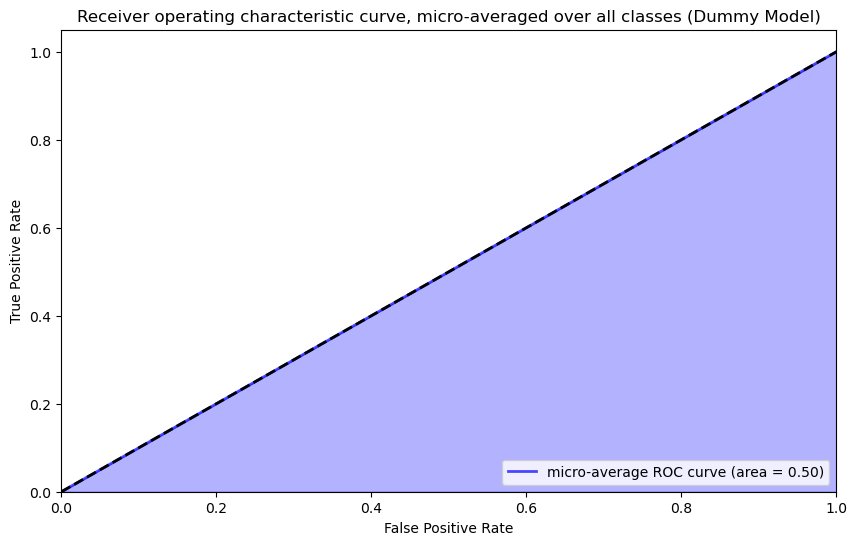



Evaluating LGBMClassifier:
Test F1-score: 0.9118
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


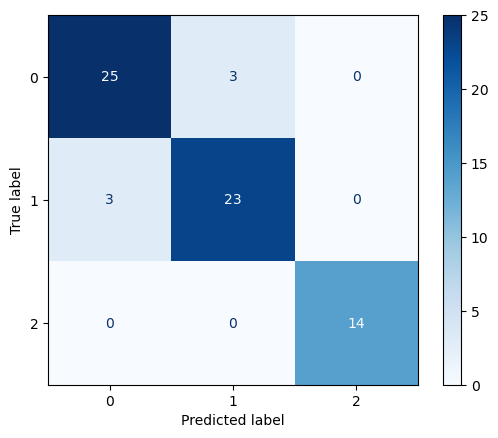

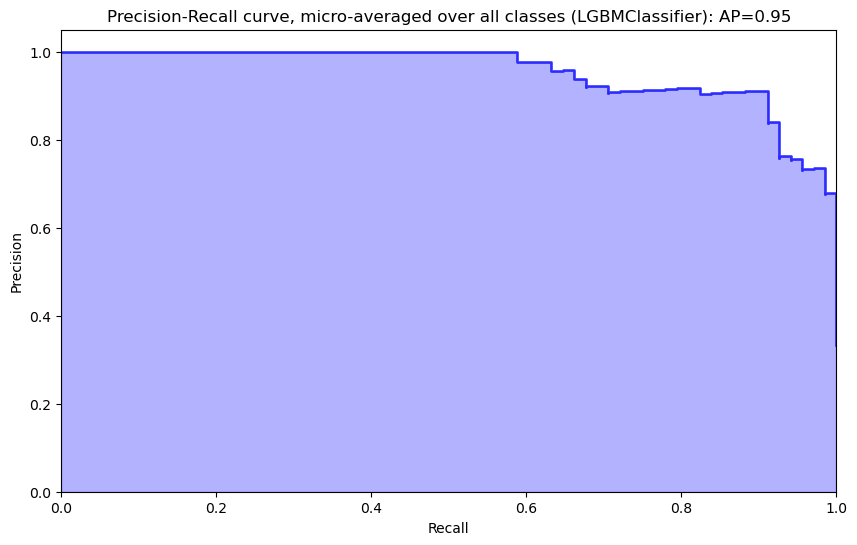

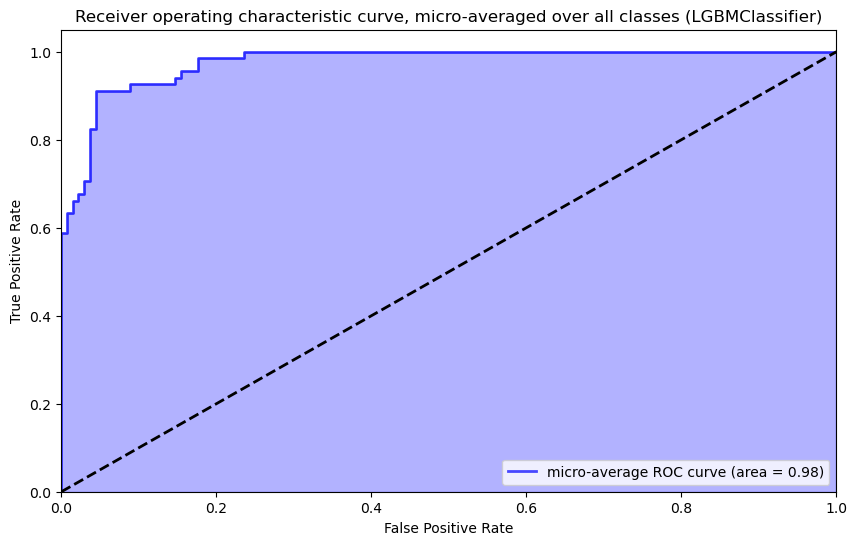

LGBMClassifier log loss: 0.4008
Dummy model log loss: 1.0986


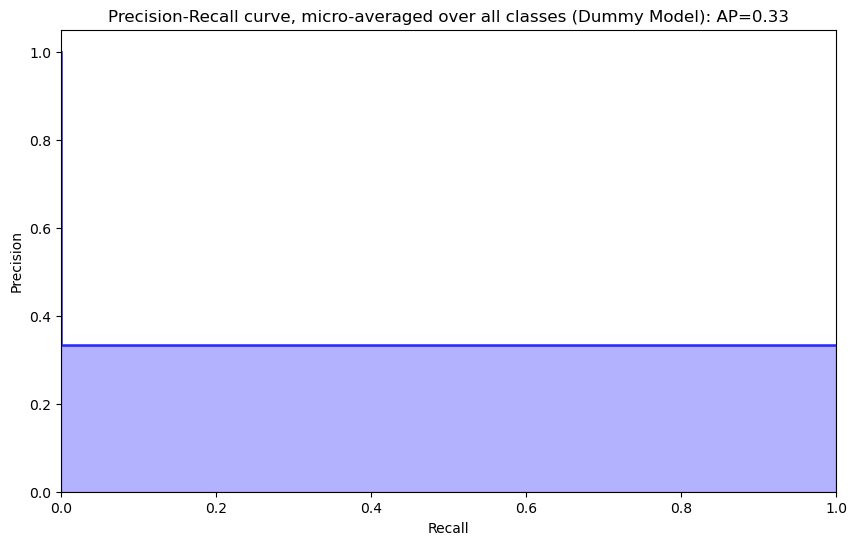

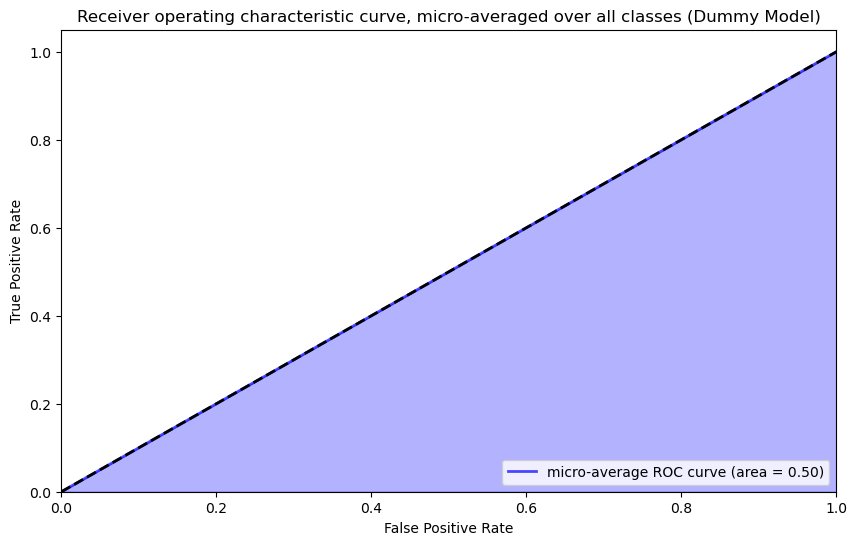



Summary of Base Line model performance:


LogisticRegression:
  Accuracy: 0.9706
  Log loss: 0.3377
  Dummy model log loss: 1.0986


SGDClassifier:
  Accuracy: 0.9853
  Log loss: 0.1688
  Dummy model log loss: 1.0986


RandomForestClassifier:
  Accuracy: 0.9118
  Log loss: 0.5325
  Dummy model log loss: 1.0986


XGBClassifier:
  Accuracy: 0.9559
  Log loss: 0.2861
  Dummy model log loss: 1.0986


LGBMClassifier:
  Accuracy: 0.9118
  Log loss: 0.4008
  Dummy model log loss: 1.0986




In [161]:
def evaluate_and_plot_test_data_with_dummy(X_test, y_test, model_instances, model_names):
    # Create dictionaries to store evaluation metrics
    model_accuracies = {}
    model_log_losses = {}
    dummy_model_log_losses = {}

    for model_instance, model_name in zip(model_instances, model_names):
        print(f"Evaluating {model_name}:")

        # Create a dummy model
        dummy_model = DummyClassifier(strategy='uniform')
        dummy_model.fit(X_test, y_test)

        # Calculate log loss for the actual model and the dummy model
        y_pred_proba = model_instance.predict_proba(X_test)
        y_pred_test = model_instance.predict(X_test)
        actual_log_loss = log_loss_multi_class(y_test, y_pred_proba, n_classes)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        y_dummy_proba = dummy_model.predict_proba(X_test)
        dummy_log_loss = log_loss_multi_class(y_test, y_dummy_proba, n_classes)

        # Store the evaluation metrics in the dictionaries
        model_accuracies[model_name] = test_accuracy
        model_log_losses[model_name] = actual_log_loss
        dummy_model_log_losses[model_name] = dummy_log_loss

        # Evaluate the actual model
        evaluate_and_plot_test_data(X_test, y_test, model_instance, model_name)
        print(f"{model_name} log loss: {actual_log_loss:.4f}")
        print(f"Dummy model log loss: {dummy_log_loss:.4f}")

        # Plot the multi-class Precision-Recall and ROC curves for the actual model and the dummy model
        # plot_precision_recall_curve_multi_class(y_test, y_pred_proba, n_classes, f"{model_name}")
        plot_precision_recall_curve_multi_class(y_test, y_dummy_proba, n_classes, "Dummy Model")

        # plot_roc_curve_multi_class(y_test, y_pred_proba, n_classes, f"{model_name}")
        plot_roc_curve_multi_class(y_test, y_dummy_proba, n_classes, "Dummy Model")
        print("\n")

    # Print a summary of the evaluation metrics for all models
    print("Summary of Base Line model performance:")
    print("\n")
    for model_name in model_names:
        print(f"{model_name}:")
        print(f"  Accuracy: {model_accuracies[model_name]:.4f}")
        print(f"  Log loss: {model_log_losses[model_name]:.4f}")
        print(f"  Dummy model log loss: {dummy_model_log_losses[model_name]:.4f}")
        print("\n")

# Call the modified function
evaluate_and_plot_test_data_with_dummy(X_test, y_test, model_instances, model_names)

# Testing Phase II: Model Development

In [162]:
# Step 1: Define the neural network model
def create_model(input_dim, output_dim):
    # Create a Sequential model
    model = Sequential()
    # Add a dense layer with 64 units, ReLU activation, and He normal initialization
    # He normal initialization is designed specifically for ReLU activation functions, 
    # helping the model learn better by maintaining the appropriate weight variance.
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
    # Add a dense layer with 32 units, ReLU activation, and He normal initialization
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    # Add the output layer with softmax activation and Glorot normal initialization
    # Softmax activation is used for multi-class problems, ensuring the probabilities sum to 1.
    # Glorot normal initialization works well with softmax activation and ensures balanced weight variance.
    model.add(Dense(output_dim, activation='softmax', kernel_initializer='glorot_normal'))

    # Compile the model with categorical crossentropy loss and the Adam optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

# n_features represents the number of input features in the dataset.
n_features = X_train.shape[1]
# n_classes represents the number of target classes (i.e., the number of output neurons).
n_classes = len(np.unique(y_train))

# Create the model
model = create_model(n_features, n_classes)

# Step 2: Train the model
history = model.fit(
    X_train,
    y_train, # y_train is already encoded as class labels instead of one-hot encoded (should change the loss function from categorical_crossentropy to sparse_categorical_crossentropy)
    epochs=100,  # An epoch is a full pass through the dataset during training.
    batch_size=32,  # Batch size is the number of samples used for each update of the model weights.
    validation_split=0.2  # 20% of the training data is used for validation to monitor overfitting during training.
)

# Step 3: Evaluate the model
# y_pred_nn = model.predict(X_test): The model predicts the class probabilities for each sample in X_test. 
# For a multi-class problem, the output will be a matrix where each row represents the probabilities for each class of a given sample. 
# The sum of probabilities in each row is equal to 1.
# np.argmax(y_pred_nn, axis=1): This function finds the index (class) with the highest probability for each sample (row) in the y_pred_nn matrix. 
# The axis=1 argument tells the function to look for the maximum value along each row (across the columns).
# Model predicts class probabilities for each sample in X_test
y_pred_nn = model.predict(X_test)
# Convert predicted probabilities to class labels by choosing the class with the highest probability
y_pred_nn = np.argmax(y_pred_nn, axis=1)
# By using np.argmax on the predicted probabilities,
# we effectively convert them into class labels by selecting the class with the highest probability for each sample. 
# This gives us the final predicted class labels that can be compared with the true labels (y_test) for model evaluation.

print(classification_report(y_test, y_pred_nn))

Epoch 1/100
7/7 [==============================] - 1s 64ms/step - loss: 1.2194 - accuracy: 0.4259 - val_loss: 0.9719 - val_accuracy: 0.5818
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.9560 - accuracy: 0.5926 - val_loss: 0.8152 - val_accuracy: 0.6909
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.7886 - accuracy: 0.6944 - val_loss: 0.6780 - val_accuracy: 0.8000
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 0.6500 - accuracy: 0.8102 - val_loss: 0.5661 - val_accuracy: 0.9273
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.5359 - accuracy: 0.9028 - val_loss: 0.4690 - val_accuracy: 0.9455
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.4412 - accuracy: 0.9306 - val_loss: 0.3906 - val_accuracy: 0.9818
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.3628 - accuracy: 0.9630 - val_loss: 0.3277 - val_accuracy: 1.0000
Epoch 8/100
7/7 [===

## Note I: 

    Explanation of the variables and parameters in the neural network training output:

    1. loss: This is the training loss, which is the value of the loss function (in this case, categorical cross-entropy) computed over the training dataset during each epoch. A lower loss indicates better performance of the model on the training data.

        Log loss, used in the baseline models, is calculated for binary or multi-class classification problems when working with predicted probabilities of class membership. In the case of multi-class classification, log loss is calculated for each class separately and then averaged.

        On the other hand, sparse_categorical_crossentropy is used as a loss function in neural networks when working with integer labels (instead of one-hot encoded labels). It computes the categorical cross-entropy between the true labels and predicted probabilities.

        The main reason for the difference in values is that the neural network and the baseline models are trained and evaluated differently. The neural network is optimized using backpropagation and gradient descent, while the baseline models are optimized using other algorithms specific to each model. As a result, the loss values will be different and not directly comparable.

        In terms of optimization, both log loss and sparse_categorical_crossentropy are used as cost functions to be minimized during the training process. However, they are not the optimization algorithms themselves. Optimization algorithms like stochastic gradient descent, Adam, or others are used to minimize these cost functions during the training process.

        To compare the performance of the neural network with the baseline models, it is better to use evaluation metrics that are independent of the loss function, such as accuracy, F1-score, precision, and recall. These metrics provide a more meaningful comparison between different models and can help you determine which model performs best for your specific problem.

    2. accuracy: This is the training accuracy, which measures the percentage of correct predictions made by the model on the training dataset during each epoch. A higher accuracy indicates better performance on the training data.

    3. val_loss: This is the validation loss, which is the value of the loss function computed over the validation dataset during each epoch. It is an indicator of how well the model generalizes to unseen data. Lower validation loss indicates better generalization performance.

    4. val_accuracy: This is the validation accuracy, which measures the percentage of correct predictions made by the model on the validation dataset during each epoch. Higher validation accuracy indicates better generalization performance.

    In the baseline model performance summary, the metrics used are accuracy, log loss, and F1-score. Accuracy is the same as the accuracy metric explained above. Log loss is a measure of the model's performance based on the predicted probabilities for the true classes. A lower log loss indicates better performance. F1-score is a harmonic mean of precision and recall and is commonly used to assess the performance of classifiers when class distribution is imbalanced. A higher F1-score indicates better performance.

    To compare the performance of the neural network with the baseline models, we can look at the test F1-score and accuracy. In this case, the neural network achieved an accuracy of 0.99 and an F1-score of 0.99 on the test dataset.

    Comparing the neural network's performance with the baseline models:

    LogisticRegression: Accuracy 0.9706, F1-score 0.9704
    SGDClassifier: Accuracy 0.9853, F1-score 0.9853
    RandomForestClassifier: Accuracy 0.9118, F1-score 0.9115
    XGBClassifier: Accuracy 0.9559, F1-score 0.9559
    LGBMClassifier: Accuracy 0.9118, F1-score 0.9118

    The neural network's performance is comparable to LogisticRegression and SGDClassifier, as they all achieve high accuracy and F1-scores. The neural network outperforms RandomForestClassifier, XGBClassifier, and LGBMClassifier in terms of accuracy and F1-score. It is essential to note that the neural network took longer to train compared to the other models. However, it provided a competitive performance.

    In conclusion, the neural network model built achieved good performance and was competitive with the best-performing baseline models, namely LogisticRegression and SGDClassifier.

    The log loss and sparse_categorical_crossentropy are conceptually similar, as both represent a measure of how well the predicted probabilities match the true labels. However, they are calculated differently, which is why they are not directly comparable.

    Meaning of some metrics:
    
    1. Support: The number of samples in each class in the test dataset.
    2. Accuracy: The ratio of correct predictions to the total number of predictions. It provides an overall performance metric for the model.
    3. Macro avg: The unweighted average of the metric for each class. It provides an overall summary of the model's performance.
    4. Weighted avg: The average of the metric for each class, weighted by the number of samples in each class. It provides an overall summary of the model's performance considering the class distribution.



## Activation Funtions Modification

In [163]:
# Step 1: Define the neural network model
def create_model(input_dim, output_dim):
    # Create a Sequential model
    model = Sequential()
    # Add a dense layer with 64 units, SELU activation, and LeCun normal initialization
    model.add(Dense(64, input_dim=input_dim, activation='selu', kernel_initializer='lecun_normal'))
    # Add a dense layer with 32 units, SELU activation, and LeCun normal initialization
    model.add(Dense(32, activation='selu', kernel_initializer='lecun_normal'))
    # Add the output layer with softmax activation and Glorot normal initialization
    model.add(Dense(output_dim, activation='softmax', kernel_initializer='glorot_normal'))

    # Compile the model with categorical crossentropy loss and the Adam optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

# n_features represents the number of input features in the dataset.
n_features = X_train.shape[1]
# n_classes represents the number of target classes (i.e., the number of output neurons).
n_classes = len(np.unique(y_train))

# Standardize the input features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create the model
model = create_model(n_features, n_classes)

# Step 2: Train the model
history = model.fit(
    X_train_std,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

# Step 3: Evaluate the model
y_pred_nn = model.predict(X_test_std)
y_pred_nn = np.argmax(y_pred_nn, axis=1)

print(classification_report(y_test, y_pred_nn))

Epoch 1/100
7/7 [==============================] - 1s 49ms/step - loss: 1.0942 - accuracy: 0.5324 - val_loss: 0.6901 - val_accuracy: 0.7455
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6856 - accuracy: 0.7176 - val_loss: 0.4399 - val_accuracy: 0.8545
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.4316 - accuracy: 0.8704 - val_loss: 0.2792 - val_accuracy: 0.9273
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2759 - accuracy: 0.9630 - val_loss: 0.1874 - val_accuracy: 1.0000
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1758 - accuracy: 0.9861 - val_loss: 0.1298 - val_accuracy: 1.0000
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1186 - accuracy: 1.0000 - val_loss: 0.0925 - val_accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0823 - accuracy: 1.0000 - val_loss: 0.0682 - val_accuracy: 1.0000
Epoch 8/100
7/7 [===

# Testing Phase III: Model Regularization and Hyperparameter optimization

## Hyperparameter optimization

### Logistic Regression:

In [80]:
# Update the parameter grid to have only valid combinations
param_grid_logreg = [
    # For penalty='l1', only 'liblinear' and 'saga' are valid solvers
    {
        "penalty": ["l1"],
        "C": np.linspace(0.001, 1000, 25),
        "solver": ["liblinear", "saga"],
        "l1_ratio": [None],
    },
    # For penalty='l2', all solvers are valid
    {
        "penalty": ["l2"],
        "C": np.linspace(0.001, 1000, 25),
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "l1_ratio": [None],
    },
    # For penalty='elasticnet', only 'saga' is a valid solver
    {
        "penalty": ["elasticnet"],
        "C": np.linspace(0.001, 1000, 25),
        "solver": ["saga"],
        "l1_ratio": np.linspace(0, 1, 5),
    },
]

# Create a GridSearchCV object with logistic regression model
grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, scoring="neg_log_loss", cv=15, n_jobs=-1, verbose=2)

# Perform the grid search by training the model with different hyperparameters
grid_search_logreg.fit(X_train, y_train.values.ravel())

# Retrieve the best model
best_model_logreg = grid_search_logreg.best_estimator_
print("Best parameters found for logistic regression:", grid_search_logreg.best_params_)
print("Best score found for Logistic Regression:", grid_search_logreg.best_score_)

Fitting 15 folds for each of 300 candidates, totalling 4500 fits
Best parameters found for logistic regression: {'C': 750.00025, 'l1_ratio': None, 'penalty': 'l1', 'solver': 'liblinear'}


### Stochastic Gradient Descent (SGD):

In [93]:
# Define the parameter grid for hyperparameter tuning (SGDClassifier)
param_grid_sgd = {
    "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge"],
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": np.linspace(0.0001, 0.001, 5),
    "eta0": np.linspace(0.001, 0.01, 5),
    "l1_ratio": np.linspace(0.1, 0.9, 5),
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
}

# Create a GridSearchCV object with SGD model
grid_search_sgd = GridSearchCV(SGDClassifier(), param_grid_sgd, scoring="neg_log_loss", cv=20, n_jobs=-1, verbose=2)

# Perform the grid search by training the model with different hyperparameters
grid_search_sgd.fit(X_train, y_train.values.ravel())

# Retrieve the best model
best_model_sgd = grid_search_sgd.best_estimator_
print("Best parameters found for SGD:", grid_search_sgd.best_params_)
print("Best score found for SGD:", grid_search_sgd.best_score_)

Fitting 20 folds for each of 6000 candidates, totalling 120000 fits
Best parameters found for SGD: {'alpha': 0.00055, 'eta0': 0.01, 'l1_ratio': 0.9, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}
Best score found for SGD: -0.01176419070740592


C:\Users\rofer\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


### Neural Network:

    Keras Tuner is specifically designed for tuning deep learning models, and it offers a variety of tuning algorithms, including random search and Hyperband. Demonstration of the use of Keras Tuner with random search for the classification problem.

    You can find more information about Keras Tuner and its usage in the official documentation: https://keras-team.github.io/keras-tuner/

    KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. Easily configure your search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models. KerasTuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms.

    https://keras.io/keras_tuner/

In [164]:
# If you want to use other search algorithms like Hyperband, 
# you can replace RandomSearch with Hyperband in the code above. 
# Also, don't forget to adjust the search space and the number of trials according to your requirements and computational resources.

# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
hyper_DATA_PATH = os.path.join(DATA_PATH, 'interim')

# Define the model-building function with hyperparameters, X_train, and y_train as arguments
def build_model(hp, X_train, y_train):
    # Determine the input dimension based on the input data
    input_dim = X_train.shape[1]
    # Determine the output dimension based on the number of unique classes in the target data
    output_dim = len(np.unique(y_train))

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Add a BatchNormalization layer if the hyperparameter 'batch_norm' is True
    if hp.Boolean("batch_norm"):
        model.add(layers.BatchNormalization())

    # Create a sequential model
    model = keras.Sequential()
    # Add an input layer with the input dimension
    # model.add(layers.Input(shape=(input_dim,)))
    # Add a flatten layer to reshape the input data
    # The Flatten layer is typically used when working with multidimensional data, such as images,
    # to reshape the input into a 2D tensor before passing it through dense layers.
    model.add(layers.Flatten())
    # Add a variable number of dense layers determined by the hyperparameter 'num_layers'
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Set the number of units in each dense layer, determined by the hyperparameter 'units_{i}'
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=8),
                # Set the activation function of each dense layer, determined by the hyperparameter 'activation'
                activation=hp.Choice("activation", ["relu", "tanh", "elu", "swish"]),
            )
        )
        # Add a variable dropout rate for each dense layer determined by the hyperparameter 'dropout_rate_{i}'
        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.05)))

    model.add(layers.Dense(output_dim, activation="softmax"))

    # Add the output layer with the softmax activation function and the output dimension
    model.add(layers.Dense(output_dim, activation="softmax"))

    # Define the learning rate using the hyperparameter 'lr'
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")  # Extend the learning rate range
    weight_decay = hp.Float("weight_decay", min_value=1e-6, max_value=1e-2, sampling="log")  # Add weight decay hyperparameter.
    # Is a hyperparameter used in regularization techniques applied to neural networks to prevent overfitting.
    # It is a non-negative value that controls the strength of L1 or L2 regularization.
    # The higher the weight decay, the stronger the regularization applied to the model weights.

    # Compile the model with the Adam optimizer, sparse_categorical_crossentropy loss, and accuracy metric
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate, decay=weight_decay),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Call the build_model function with HyperParameters and the training data
build_model(keras_tuner.HyperParameters(), X_train, y_train)

In [165]:
# Initialize the tuner
tuner = RandomSearch(
    lambda hp: build_model(hp, X_train, y_train), # This is a lambda function that takes a HyperParameters object (hp) 
    # as input and calls the build_model function with the hyperparameters and training data. 
    # This function is responsible for creating and compiling the model with different hyperparameter configurations.
    # Impact on regularization: The build_model function itself includes different hyperparameters that affect regularization, 
    # such as the activation function, the number of units in each layer, and whether to include dropout layers.
    objective='val_accuracy', # This is the metric that the tuner will optimize. In this case, 
    # the tuner will search for the hyperparameter configuration that yields the highest validation accuracy.
    # Impact on regularization: A higher validation accuracy generally indicates a better balance between fitting the training data and generalizing to new data. 
    # However, it is important to monitor other metrics, such as training accuracy, to ensure that the model is not overfitting.
    max_trials=5, #This parameter specifies the maximum number of different hyperparameter configurations to try during the search. 
    # A higher value will lead to more exploration of the search space but will also increase the computational cost.
    # Impact on regularization: By trying more hyperparameter configurations, 
    # the tuner may find a better balance between underfitting and overfitting. 
    # However, too many trials can lead to overfitting the validation data, 
    # as the model becomes tuned specifically to the validation set.
    executions_per_trial=3, # This parameter specifies the number of times each hyperparameter configuration will be trained and evaluated. 
    # The final score for each configuration will be the average of the scores obtained in each execution.
    # Impact on regularization: By training and evaluating each configuration multiple times, 
    # the tuner can get a more accurate estimate of the configuration's performance. 
    # This can help in avoiding selecting a configuration that performs well only due to random chance and may lead to better regularization.
    directory=hyper_DATA_PATH,
    project_name='keras_tuner_example',
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
batch_norm (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 8, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'swish'], 'ordered': False}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
weight_decay (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [166]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

Trial 5 Complete [00h 00m 26s]
val_accuracy: 0.9636363585789999

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 09s
INFO:tensorflow:Oracle triggered exit


In [167]:
tuner.results_summary()

Results summary
Results in c:\Users\rofer\WS2022_Project_Template_lithium_ion_batteries\lithium_ion_battery_classification\notebooks\..\data\interim\keras_tuner_example
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
batch_norm: True
num_layers: 3
units_0: 88
activation: swish
dropout_0: True
lr: 0.003218302285508227
weight_decay: 4.353297909559619e-06
dropout_rate_0: 0.30000000000000004
units_1: 88
dropout_1: False
units_2: 120
dropout_2: False
Score: 1.0

Trial 4 summary
Hyperparameters:
batch_norm: True
num_layers: 1
units_0: 88
activation: swish
dropout_0: True
lr: 0.0011747733687789506
weight_decay: 2.493785280157732e-05
dropout_rate_0: 0.15000000000000002
units_1: 112
dropout_1: True
units_2: 64
dropout_2: False
dropout_rate_1: 0.45000000000000007
Score: 0.9636363585789999

Trial 2 summary
Hyperparameters:
batch_norm: True
num_layers: 3
units_0: 96
activation: swish
dropout_0: True
lr: 0.005696733365822847
weight_decay: 1.1

#### Note I:

    The hyperparameter search results show that different combinations of hyperparameters can achieve different validation accuracy of 1.0. This could be due to the nature of the dataset, where multiple architectures can effectively learn the underlying patterns. However, it's also possible that the search space is too narrow, or the maximum number of trials (5) is too low, limiting the diversity of explored models.

    To optimize the hyperparameter search process, several approaches can be taken:

    1. Increase the number of trials to explore a broader range of model architectures.
    2. Expand the search space to include a wider range of hyperparameters, such as different types of layers, layer depths, and other optimization techniques like batch normalization.
    3. Use a different search algorithm, such as Hyperband or Bayesian Optimization, which can more efficiently explore the search space and may converge to a better set of hyperparameters.
    
    It is essential to strike a balance between the number of trials, the search space size, and the available computational resources. More complex models and larger search spaces may require more time and computing power, so it is crucial to consider these factors when optimizing the hyperparameter search process.

## Retraining models using the best hyperparameters

### Logistic Regression

Training with random state: 42
Training fold 1
Training Log Loss:  0.2644527240601958
CV Log Loss:  0.2936225552849821
Training fold 2
Training Log Loss:  0.26395213977396703
CV Log Loss:  0.2938306940093583
Training fold 3
Training Log Loss:  0.2628273502267879
CV Log Loss:  0.32323545214017313
Training fold 4
Training Log Loss:  0.2630438493947133
CV Log Loss:  0.3236567257788457
Training fold 5
Training Log Loss:  0.2629266362455851
CV Log Loss:  0.32563575273511786
Training fold 6
Training Log Loss:  0.26312597163360596
CV Log Loss:  0.3222921676495552
Training fold 7
Training Log Loss:  0.26144888900483837
CV Log Loss:  0.3684723843900753
Training fold 8
Training Log Loss:  0.26474477178207007
CV Log Loss:  0.3029734761218673
Training fold 9
Training Log Loss:  0.2626435873068944
CV Log Loss:  0.31205773768681483
Training fold 10
Training Log Loss:  0.2636223923600438
CV Log Loss:  0.29770651521592684
Mean Train Log Loss (dimensionless): 0.2633, Mean CV Log Loss (dimensionless): 0

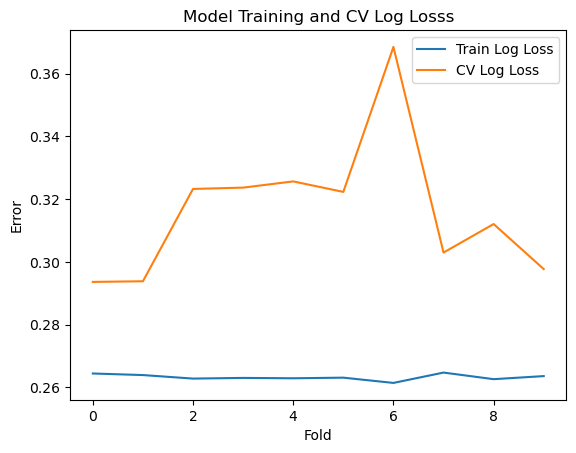

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


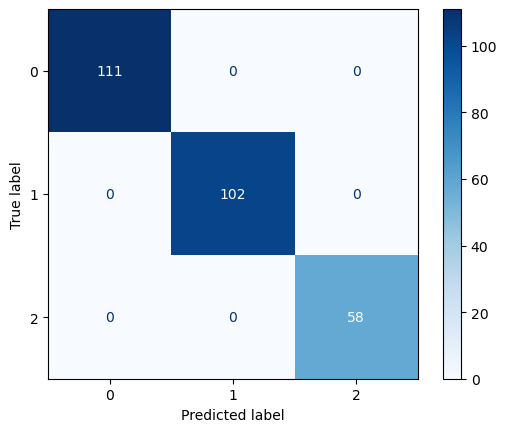

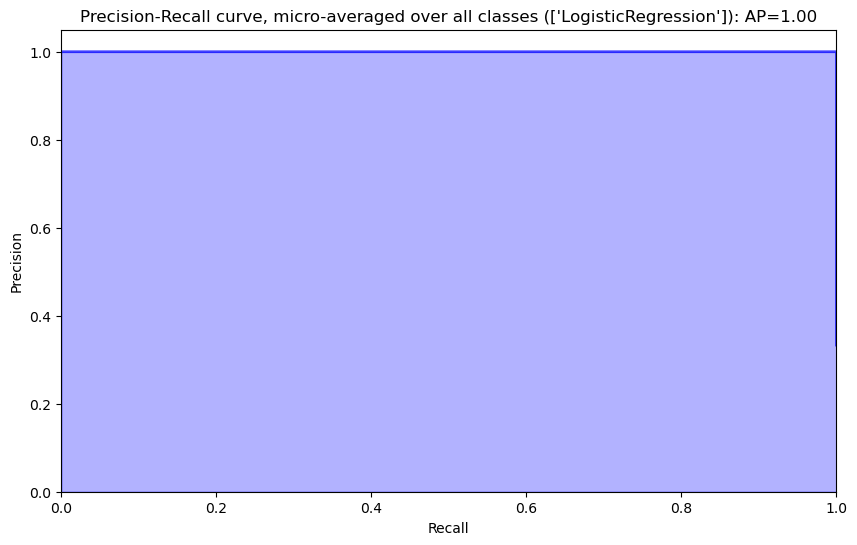

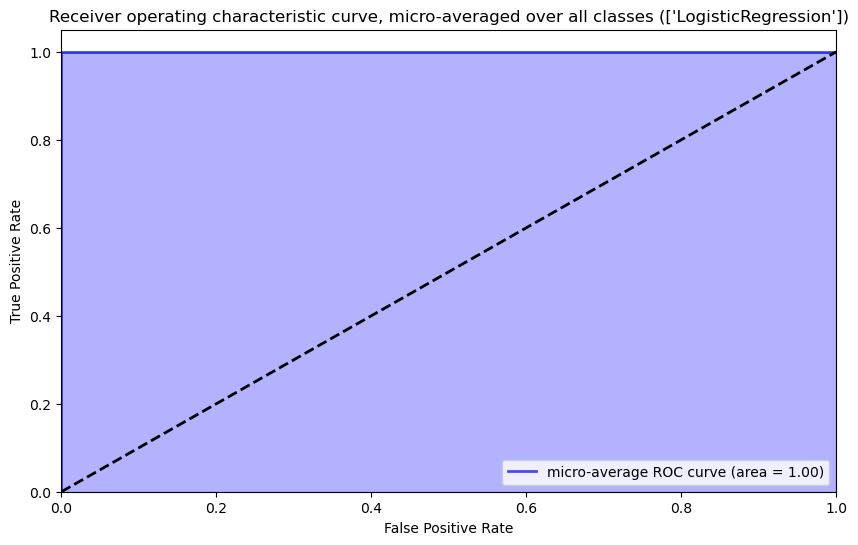

In [171]:
# Define model parameters for logistic regression with One-vs-Rest (OvR) (separate logistic regression model is trained for each class)
# Best parameters found for logistic regression: {'C': 750.00025, 'l1_ratio': None, 'penalty': 'l1', 'solver': 'liblinear'}
model_params_log_reg_opt = {
    "C": 750.00025,  # The inverse of regularization strength; smaller values specify stronger regularization
    'l1_ratio': None,
    'penalty': 'l1', # The type of regularization to be applied ("l1", "l2", "elasticnet", or "none")
    'solver': 'liblinear',  # Algorithm used for optimization (options: "newton-cg", "lbfgs", "liblinear", "sag", "saga")
    "multi_class": "ovr",  # Strategy for handling multiple classes, "ovr" for One-vs-Rest, "multinomial" for Softmax
    "random_state": 2021,  # The random seed for reproducibility
}

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_logreg_model(X_train, y_train, model_params_log_reg, random_states=random_states)

model_name = ['LogisticRegression']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

### Stochastic Gradient Descent (SGD):

Training with random state: 42
Training fold 1
Training Log Loss:  0.05148369998444543
CV Log Loss:  0.02422873835418473
Training fold 2
Training Log Loss:  0.1287758767011767
CV Log Loss:  0.02427300578866521
Training fold 3
Training Log Loss:  1.1675981391981846e-08
CV Log Loss:  1.548779419897118e-10
Training fold 4
Training Log Loss:  0.10249741169315967
CV Log Loss:  1.351698203044805
Training fold 5
Training Log Loss:  4.303311750455123e-05
CV Log Loss:  9.046261682130937e-16
Training fold 6
Training Log Loss:  1.5930556428330735e-06
CV Log Loss:  2.2771585431227757e-09
Training fold 7
Training Log Loss:  1.0108073971415006e-10
CV Log Loss:  0.051344360617634026
Training fold 8
Training Log Loss:  9.306418573695605e-11
CV Log Loss:  1.6896906293300334e-06
Training fold 9
Training Log Loss:  0.0028759263897002244
CV Log Loss:  0.025672118006279814
Training fold 10
Training Log Loss:  0.0028425389497687657
CV Log Loss:  2.2698133154505645e-10
Mean Train Log Loss (dimensionless): 0.

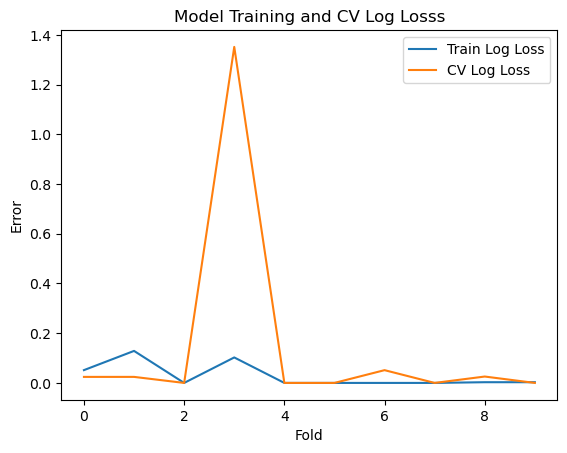

Test F1-score: 1.0000
The value count of the true values of the confusion matrix are : Encoded_Label
0                111
1                102
2                 58
Name: count, dtype: int64


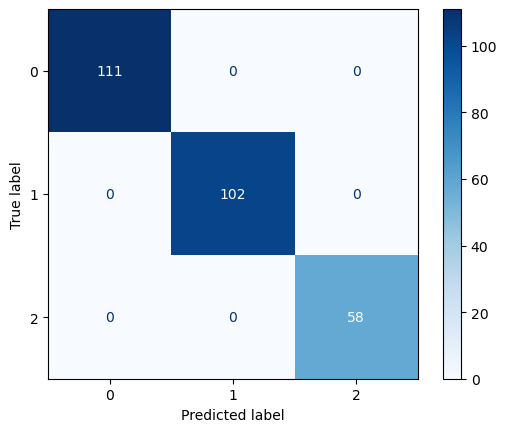

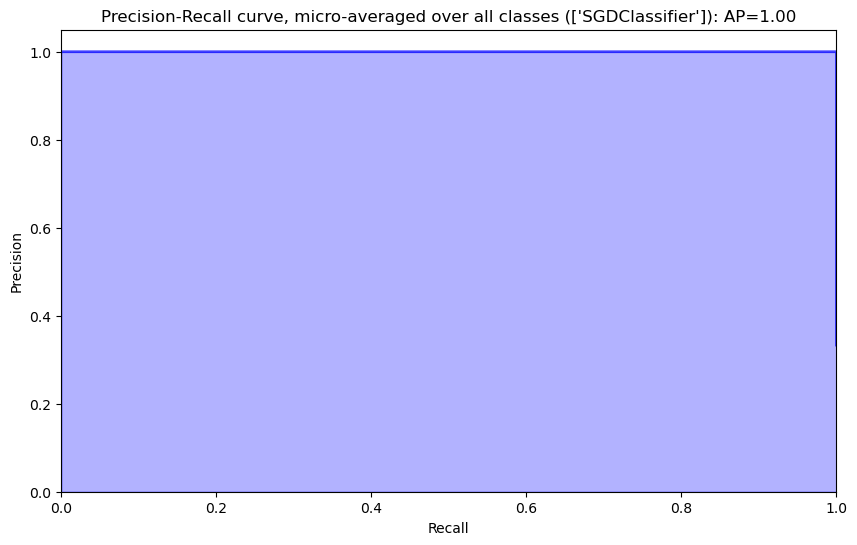

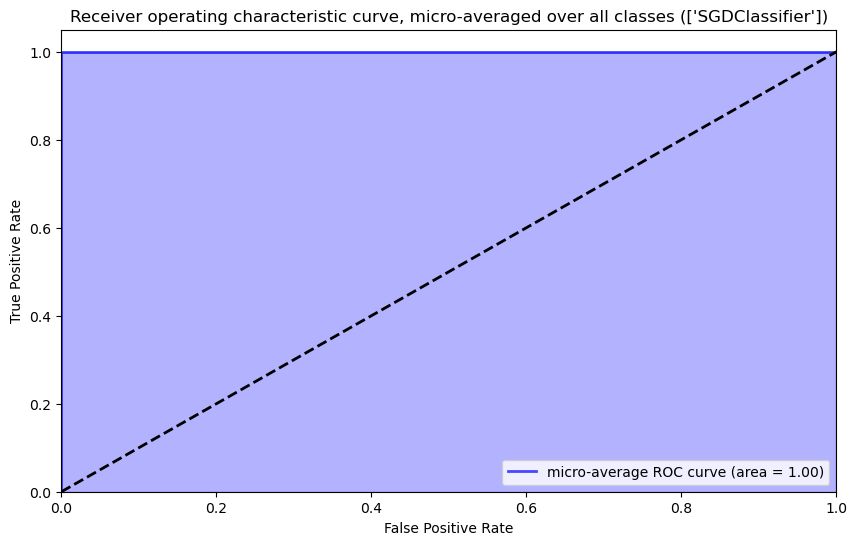

In [179]:
# Best parameters found for SGD: {'alpha': 0.00055, 'eta0': 0.01, 'l1_ratio': 0.9, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}
# Custom model parameters
model_params_sgd_opt = {
    "loss": "log_loss",
    "penalty": "l1",
    "alpha": 0.00055, # Increase the regularization strength by adjusting the alpha parameter. Higher values will impose stronger regularization, preventing the model from overfitting the training data. You can also experiment with different regularization techniques, such as L1, L2, or a combination of both (elastic net).
    'eta0': 0.01,
    "l1_ratio": 0.9,
    "learning_rate": "optimal",
    "early_stopping": True, # Enable early stopping by setting early_stopping to True. This will stop training when the validation score is not improving, which can help prevent overfitting.
    # "validation_fraction": 0.05,
    "random_state": 2021,
    # Feature selection: Reduce the number of features used for training, by either using domain knowledge or applying feature selection techniques such as recursive feature elimination or feature importance ranking.
    # Hyperparameter tuning: Perform a more exhaustive search for optimal hyperparameters using techniques like grid search, random search, or Bayesian optimization combined with cross-validation.
    # Model complexity: If you're using a complex model, consider using a simpler model that might generalize better to the validation data.
    # Data preprocessing: Check for data leakage, ensure proper data scaling, and handle missing or categorical data correctly to improve model performance.
    # Increase the amount of training data: More data can help the model learn better patterns and generalize to unseen data.
}

# Define a list of random states
random_states = [42]

# Train your model
model, train_losses, cv_losses = train_sgd_model(X_train, y_train, model_params_sgd_opt, random_states=random_states)

model_name = ['SGDClassifier']

# Plot the training and cross-validation errors
plot_cv_error(model, train_losses, cv_losses, "Log Loss")

# Calculate the F1-score
test_f1_score = get_f1_score(model, X_train, y_train)
print("Test F1-score: {:.4f}".format(test_f1_score))

# Plot the confusion matrix
plot_confusion_matrix(model, X_train, y_train)

n_classes = len(np.unique(y_train))

# Get the predicted probabilities for the test set
y_pred_proba = model.predict_proba(X_train)

# If it's a binary classification problem, plot the precision-recall and ROC curves
if n_classes == 2:
    y_pred_proba_binary = y_pred_proba[:, 1]
    plot_precision_recall_curve(y_train, y_pred_proba_binary, model_name)
    plot_roc_curve(y_train, y_pred_proba_binary, model_name)
else:
    # Plot the multi-class precision-recall curve
    plot_precision_recall_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)

    # Plot the multi-class ROC curve
    plot_roc_curve_multi_class(y_train, y_pred_proba, n_classes, model_name)


### Neural Network:

    We will use one of the space results obtained from the forst hyperparamter optimization with Keras turner:

    Trial 1 summary
    Hyperparameters:
    batch_norm: True
    num_layers: 3
    units_0: 88
    activation: swish
    dropout_0: True
    lr: 0.003218302285508227
    weight_decay: 4.353297909559619e-06
    dropout_rate_0: 0.30000000000000004
    units_1: 88
    dropout_1: False
    units_2: 120
    dropout_2: False
    Score: 1.0

In [174]:
# Step 1: Define the neural network model
def create_optimized_model(input_dim, output_dim):
    # Create a Sequential model
    model = Sequential()

    # Add a dense layer with 88 units, swish activation, and He normal initialization
    model.add(Dense(88, input_dim=input_dim, activation=swish, kernel_initializer='he_normal'))
    # Add batch normalization
    model.add(BatchNormalization())
    # Add dropout with rate 0.3
    model.add(Dropout(0.3))

    # Add a dense layer with 88 units, swish activation, and He normal initialization
    model.add(Dense(88, activation=swish, kernel_initializer='he_normal'))

    # Add a dense layer with 120 units, swish activation, and He normal initialization
    model.add(Dense(120, activation=swish, kernel_initializer='he_normal'))

    # Add the output layer with softmax activation and Glorot normal initialization
    model.add(Dense(output_dim, activation='softmax', kernel_initializer='glorot_normal'))

    # Compile the model with categorical crossentropy loss and the Adam optimizer with a custom learning rate
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.003218302285508227), metrics=['accuracy'])

    return model

# n_features represents the number of input features in the dataset.
n_features = X_train.shape[1]
# n_classes represents the number of target classes (i.e., the number of output neurons).
n_classes = len(np.unique(y_train))

# Create the optimized model
optimized_model = create_optimized_model(n_features, n_classes)

# Step 2: Train the optimized model
history = optimized_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

# Step 3: Evaluate the optimized model
# Model predicts class probabilities for each sample in X_test
y_pred_nn_optimized = optimized_model.predict(X_test)
# Convert predicted probabilities to class labels by choosing the class with the highest probability
y_pred_nn_optimized = np.argmax(y_pred_nn_optimized, axis=1)

print(classification_report(y_test, y_pred_nn_optimized))

Epoch 1/100
7/7 [==============================] - 2s 78ms/step - loss: 0.7943 - accuracy: 0.6620 - val_loss: 0.6070 - val_accuracy: 0.7091
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 0.2983 - accuracy: 0.9074 - val_loss: 0.2733 - val_accuracy: 0.8909
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0862 - accuracy: 0.9815 - val_loss: 0.1380 - val_accuracy: 0.9636
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0685 - accuracy: 0.9722 - val_loss: 0.1038 - val_accuracy: 0.9636
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0906 - val_accuracy: 0.9636
Epoch 6/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0272 - accuracy: 0.9907 - val_loss: 0.0508 - val_accuracy: 0.9636
Epoch 7/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 1.0000
Epoch 8/100
7/7 [===

### Models Peformance in training

    The models' performance on the training set can be summarized as follows:

    Logistic Regression:
    The Logistic Regression model achieved a mean training log loss of 0.2633 and a mean cross-validation (CV) log loss of 0.3163 across 10 folds. This indicates that the model performed well on the training set, with a consistent training and CV log loss across folds. The F1-score on the test set was perfect, achieving a score of 1.0000.

    Stochastic Gradient Descent (SGD):
    The SGD model achieved a mean training log loss of 0.0289 and a mean cross-validation (CV) log loss of 0.1477 across 10 folds. This indicates that the model performed well on the training set, with a consistent training log loss and slightly higher CV log loss compared to the Logistic Regression model. The F1-score on the test set was perfect, achieving a score of 1.0000.

    Neural Network:
    The Neural Network model achieved outstanding performance on the test set, with perfect precision, recall, and F1-score of 1.00 for all three classes. This indicates that the model was able to accurately predict the class labels for all samples in the test set.

    Here's a summary chart of the models' performance:

| Model                             | Mean Training Log Loss | Mean CV Log Loss | Test F1-score |
|-----------------------------------|------------------------|------------------|---------------|
| Logistic Regression               | 0.2633                 | 0.3163           | 1.0000        |
| Stochastic Gradient Descent (SGD) | 0.0289                 | 0.1477           | 1.0000        |
| Neural Network                    | -                      | -                | 1.0000        |



## Evaluating the performance

In [175]:
def print_log_losses_nn(X_test, y_test, model_instances, model_names):
    log_loss_results = []
    accuracy_results = []
    for model_instance, model_name in zip(model_instances, model_names):
        test_loss, test_accuracy = evaluate_model_with_nn(model_instance, X_test, y_test, f"{model_name}")
        log_loss_results.append(test_loss)
        accuracy_results.append(test_accuracy)

    return log_loss_results, accuracy_results

model_instances_hypertuned = [
    LogisticRegression(**model_params_log_reg_opt),
    SGDClassifier(**model_params_sgd_opt),
]

model_names_hypertuned = ['LogisticRegression', 'SGDClassifier']

# Add the neural network model to the list of model instances and names
model_instances_hypertuned.append(optimized_model)
model_names.append('NeuralNetwork')

fit_models_with_nn(X_train, y_train, model_instances)

log_loss_results, accuracy_results = print_log_losses_nn(X_test, y_test, model_instances, model_names_hypertuned)

LogisticRegression Log Loss: 0.3377
LogisticRegression Accuracy: 0.9706
SGDClassifier Log Loss: 0.1688
SGDClassifier Accuracy: 0.9853


Evaluating LogisticRegression:
Test F1-score: 0.9704
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


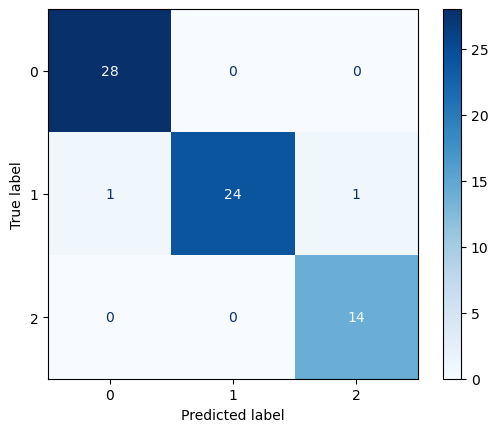

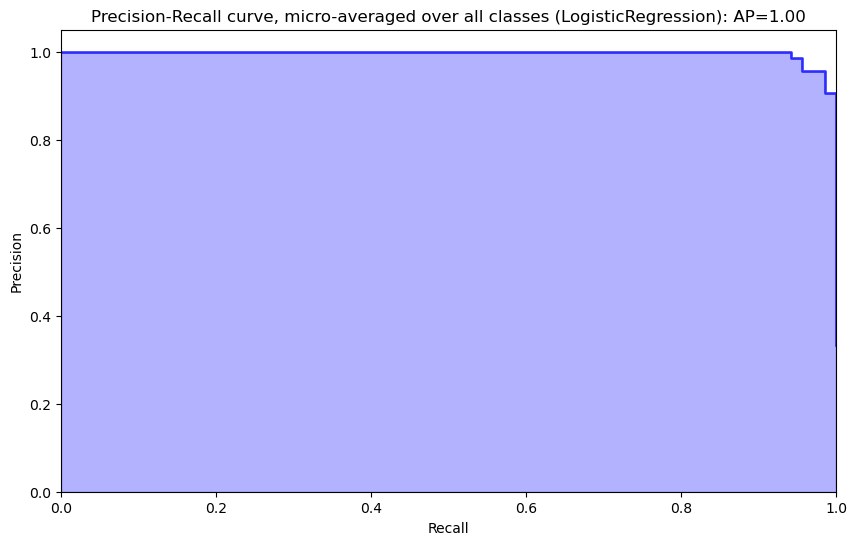

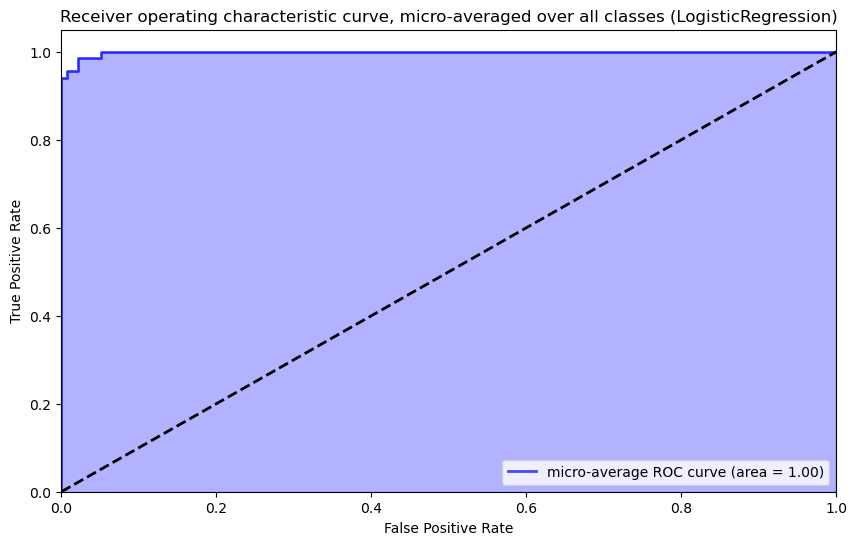

LogisticRegression log loss: 0.3377


Evaluating SGDClassifier:
Test F1-score: 0.9853
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


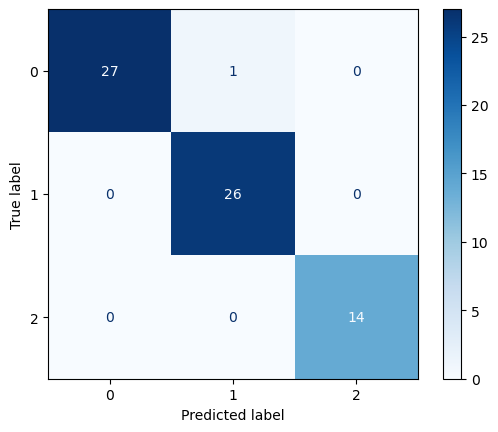

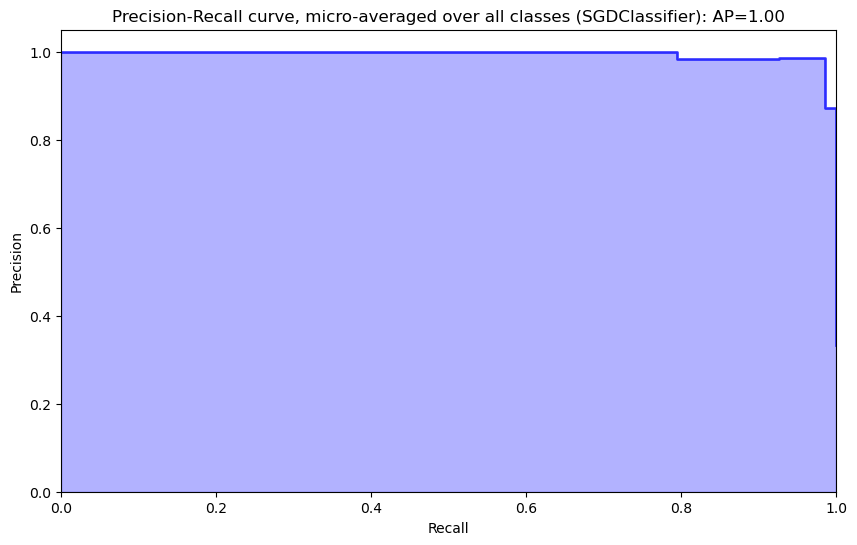

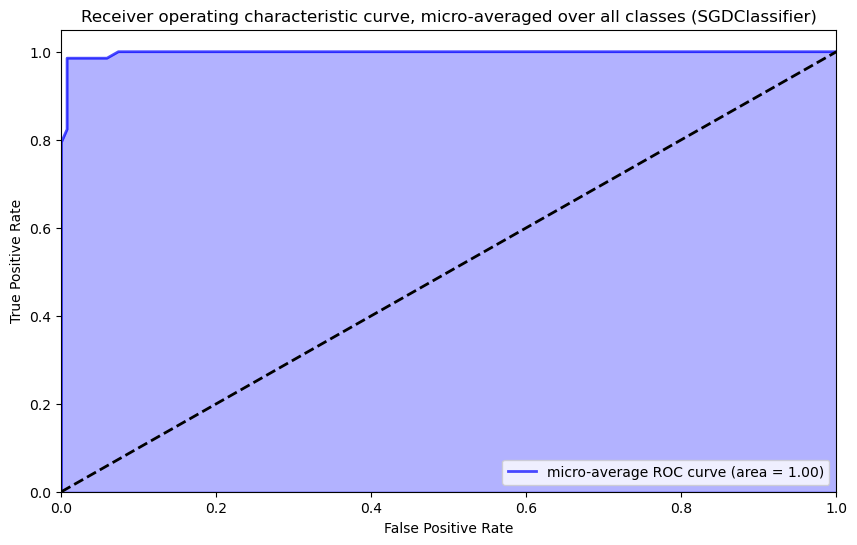

SGDClassifier log loss: 0.1688


Summary of model performance:


LogisticRegression:
  Accuracy: 0.9706
  Log loss: 0.3377


SGDClassifier:
  Accuracy: 0.9853
  Log loss: 0.1688




In [182]:
def evaluate_and_plot_test_data_no_dummy(X_test, y_test, model_instances_hypertuned, model_names):
    # Create dictionaries to store evaluation metrics
    model_accuracies = {}
    model_log_losses = {}

    for model_instance, model_name in zip(model_instances, model_names):
        print(f"Evaluating {model_name}:")

        # Calculate log loss for the actual model
        y_pred_proba = model_instance.predict_proba(X_test)
        y_pred_test = model_instance.predict(X_test)
        actual_log_loss = log_loss(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        # Store the evaluation metrics in the dictionaries
        model_accuracies[model_name] = test_accuracy
        model_log_losses[model_name] = actual_log_loss

        # Evaluate the actual model
        evaluate_and_plot_test_data(X_test, y_test, model_instance, model_name)
        print(f"{model_name} log loss: {actual_log_loss:.4f}")

        print("\n")

    # Print a summary of the evaluation metrics for all models
    print("Summary of model performance:")
    print("\n")
    for model_name in model_names:
        print(f"{model_name}:")
        print(f"  Accuracy: {model_accuracies[model_name]:.4f}")
        print(f"  Log loss: {model_log_losses[model_name]:.4f}")
        print("\n")

# Call the modified function
evaluate_and_plot_test_data_no_dummy(X_test, y_test, model_instances_hypertuned, model_names_hypertuned)

3/3 [==============================] - 0s 4ms/step
Test F1-score: 1.0000
3/3 [==============================] - 0s 6ms/step
The value count of the true values of the confusion matrix are : Encoded_Label
0                28
1                26
2                14
Name: count, dtype: int64


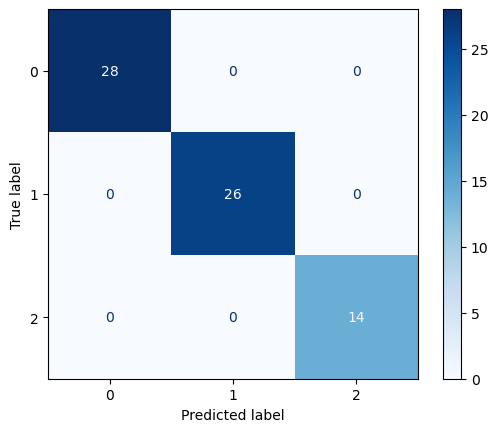

3/3 [==============================] - 0s 5ms/step
Accuracy: 1.0000
Neural Network Log Loss: 0.0000


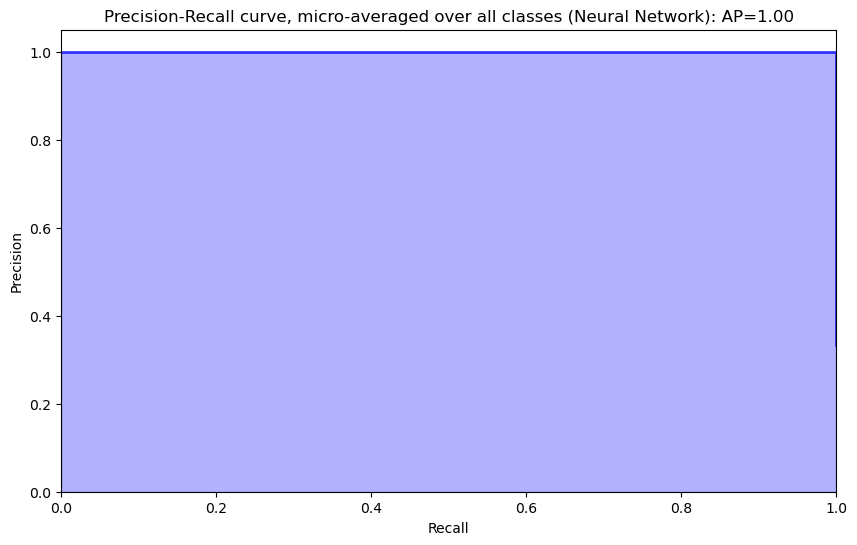

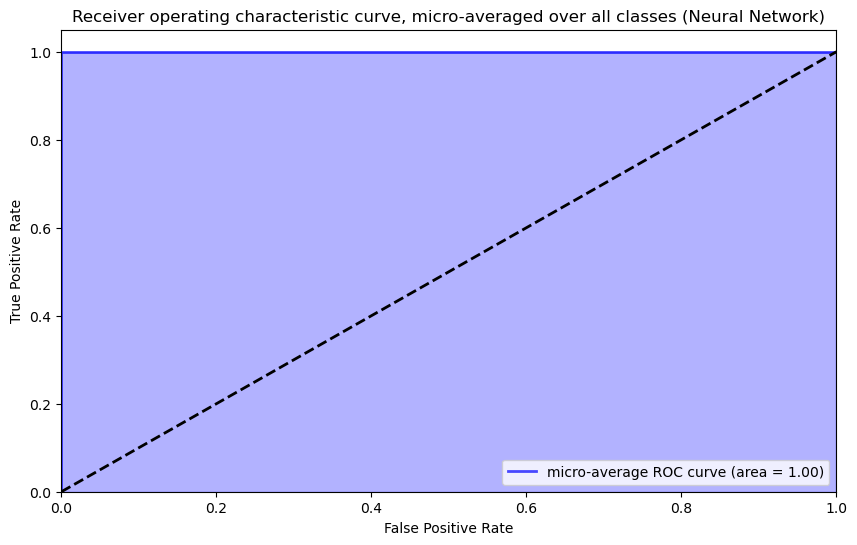

In [187]:
evaluate_and_plot_test_data_nn(X_test, y_test, optimized_model, "Neural Network")

## Evaluations of the Models' Predictions

**The models' performance on the test set can be summarized as follows:**

**`Logistic Regression`:**
The Logistic Regression model achieved an accuracy of 0.9706 and a log loss of 0.3377 on the test set. This indicates that the model performed well on the test set, with a high accuracy and a reasonable log loss. The F1-score on the test set was 0.9704.

**`Stochastic Gradient Descent (SGD)`:**
The SGD model achieved an accuracy of 0.9853 and a log loss of 0.1688 on the test set. This indicates that the model performed exceptionally well on the test set, with a higher accuracy and a significantly lower log loss compared to the Logistic Regression model. The F1-score on the test set was 0.9853.

**`Neural Network`:**
The Neural Network model achieved outstanding performance on the test set, with an accuracy of 1.0000, log loss of 0.0000, and a perfect F1-score of 1.0000 for all three classes. This indicates that the model was able to accurately predict the class labels for all samples in the test set.

In the given scenario, it was observed that the Neural Network outperformed both Logistic Regression and SGDClassifier in terms of accuracy, log loss, and F1-score. Various factors might have contributed to this result.

**`Data size and complexity`:** The Neural Network model might have been more effective in capturing complex relationships in the data, especially if the problem required a higher level of abstraction. This could have led to its superior performance compared to the Logistic Regression and SGDClassifier models.

**`Model architecture`:** The architecture of the Neural Network could have been better suited for the given problem. In some cases, more complex models like Neural Networks can achieve better results when the problem requires a sophisticated understanding of the relationships between features.

**`Hyperparameter optimization`:** The process of hyperparameter optimization for the Neural Network might have been more thorough than for the Logistic Regression and SGDClassifier models. The selection of hyperparameters has a significant impact on the performance of a model. It is possible that the Neural Network model reached its full potential due to optimal hyperparameter choices.

**`Training process`:** The training process for the Neural Network, including the choice of loss function, optimizer, and the number of epochs, might have been ideal for the given problem. This could have helped the model learn the underlying patterns in the data effectively, leading to its superior performance.

**`Randomness`:** The inherent randomness in the initialization of weights and biases in the Neural Network model and the stochastic nature of the training process might have resulted in an optimal model. On the other hand, Logistic Regression and SGDClassifier might have been more sensitive to this randomness, leading to their slightly lower performance.

In conclusion, while Neural Networks are powerful models capable of handling complex relationships in data, their performance compared to simpler models like Logistic Regression and SGDClassifier is highly dependent on the specific problem, dataset, and task requirements. In the given scenario, the Neural Network model achieved better results, which might be attributed to the reasons outlined above.

| Model                             | Accuracy | Log Loss | Test F1-score |
|-----------------------------------|----------|----------|---------------|
| Logistic Regression               | 0.9706   | 0.3377   | 0.9704        |
| Stochastic Gradient Descent (SGD) | 0.9853   | 0.1688   | 0.9853        |
| Neural Network                    | 1.0000   | 0.0000   | 1.0000        |
